# Gene-level analysis of HC association

In [11]:
import scanpy as sc
import numpy as np
import pandas as pd
import scvi
import seaborn as sns
import anndata
import warnings 
import scipy.stats
from collections import Counter
import os

warnings.filterwarnings('ignore')
#os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/ImageSpot/')
#import scvi_wrapper as s_w
import statsmodels.api as sm

In [12]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

sc.logging.print_header()
import matplotlib.pyplot as plt
sc.settings.set_figure_params(dpi = 200, color_map = 'RdYlBu_r', dpi_save = 300, format = 'pdf',fontsize=5)
plt.rcParams["figure.figsize"] = [6,6]
plt.rcParams['pdf.fonttype'] = 42
# sns.set_palette('colorblind')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.3 scipy==1.8.0 pandas==1.4.2 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.6


In [13]:
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 300, format = 'pdf',fontsize=5)

# Gene expression analysis

In [14]:
adata_scvi = sc.read_h5ad('/nfs/team205/ny1/ThymusSpatialAtlas/figure6/HTSA_adata_vis_scvi_corrected_v3.h5ad')

In [15]:
adata_scvi = adata_scvi[adata_scvi.obs['tot_cell_abundance']>30,:].copy()
adata_scvi = adata_scvi[adata_scvi.obs['n_genes_by_counts']>1500,:].copy()
adata_scvi = adata_scvi[adata_scvi.obs['Age_group']!='fetal',:].copy()
adata_scvi

AnnData object with n_obs × n_vars = 18937 × 20733
    obs: 'Sample', 'Sample_hr', 'SampleID', 'SlideID', 'Position', 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'percent_mito', 'annotations_level_0', 'annotations_level_0_number', 'annotations_level_1', 'annotations_level_1_number', 'annotations_lobules_0', 'annotations_lobules_0_number', 'L2_dist_annotations_level_0_Artifacts', 'L2_dist_annotations_level_0_Cortex', 'L2_dist_annotations_level_0_Edge', 'L2_dist_annotations_level_0_Medulla', 'L2_dist_annotations_level_1_HS', 'L2_dist_annotations_level_1_PVS', 'L2_dist_annotations_level_1_fat', 'L2_dist_annotations_level_1_vessels', 'L2_dist_annotations_level_0_lymph', 'L2_dist_annotations_level_1_unassigned', 'cm', 'cc', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN/DV200', 'Visium_type', 'Funding', 'Sequen

In [16]:
adata_scvi = adata_scvi[((adata_scvi.obs['annotations_level_1']!="fat") & (adata_scvi.obs['annotations_level_0']!="Artifacts")),:].copy()

## remove meduala less lobules 
adata_scvi.obs['full_lobule'] = 0
for s in adata_scvi.obs['SampleID'].cat.categories.tolist():
    sample = adata_scvi[adata_scvi.obs['SampleID'].isin([s])]
    for l in sample.obs['annotations_lobules_0'].cat.categories:
        lobule = sample.obs['annotations_lobules_0'] == l
        med = np.where(sample.obs['annotations_level_0'][lobule] == 'Medulla')[0]
        cortex = np.where(sample.obs['annotations_level_0'][lobule] == 'Cortex')[0]
        if (cortex.size>=5) & (med.size>=5):
            adata_scvi.obs['full_lobule'][lobule.iloc[np.where(lobule)].index] = 1
adata_scvi.obs['full_lobule'] = adata_scvi.obs['full_lobule'].astype('category')
adata_scvi.obs['full_lobule'].value_counts()
adata_scvi = adata_scvi[adata_scvi.obs['full_lobule']==1] # remove spots that don't have either medullar or cortical data
adata_scvi = adata_scvi.copy()

1    18554
0      383
Name: full_lobule, dtype: int64

In [17]:
# version 3 hybrid wighted mean 
def mean_space_gene(adata_vis,anno,threshold = 0.5,minspots=20):
    space_map = {}
    obs_ind = np.where(adata_vis.obs.columns == anno)[0]
    for c in adata_vis.var_names:
        temp = adata_vis.X[:,adata_vis.var_names==c]
        points_above = np.where(temp>threshold)[0]
        if len(points_above)>minspots:
                spot_counts = np.squeeze(np.array(temp)[points_above])      
                axis_value = np.squeeze(np.array(adata_vis.obs.iloc[points_above,obs_ind]))
                space_map[c] = (np.dot(spot_counts,axis_value)/np.sum(spot_counts))
    return space_map

In [21]:
%%time
space_map_cma = mean_space_gene(adata_scvi,'cma_v2',threshold=0.2,minspots=20)
space_map_hc = mean_space_gene(adata_scvi,'L2_dist_annotations_level_1_HS',threshold=0.2,minspots=20)

CPU times: user 21min 30s, sys: 2min 2s, total: 23min 32s
Wall time: 11min 48s


In [22]:
space_map_cma_filt = {}
for i in space_map_cma:
    if space_map_cma[i]!=None:
        if space_map_cma[i]>0.55:
            space_map_cma_filt[i] = space_map_cma[i] # remove cells that are not medullar centered  
print(len(space_map_cma_filt))

848


In [23]:
space_map_hc_filt = {}
for i in space_map_cma_filt:
#     space_map_hc[i] = space_map_hc[i]*2 # correct back to linear and micron distance ppm=0.5 hence the 2 
    if space_map_hc[i]<350/2:
        if space_map_hc[i]!=None:
                space_map_hc_filt[i] = space_map_hc[i]*2 # space_map_hc[i]*2 # correct back to linear and micron distance ppm=0.5 hence the 2 
print(len(space_map_hc_filt))

848


In [ ]:
# generate genes that are cadidates for marker genes 
keys_list = np.array(list(space_map_hc_filt.keys()))
np.save('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/Candidate_broad_HC_genes.npy', keys_list)


In [24]:
# read back marker genes 
marker_dict_1 = np.load('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/marker_genes_max_1.npy',allow_pickle=True).item()
marker_dict_2 = np.load('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/marker_genes_max_2.npy',allow_pickle=True).item()

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [26]:
df = pd.DataFrame.from_dict({'space_map_cma': space_map_cma_filt, 'space_map_hc': space_map_hc_filt}, orient='index').T.dropna()

space_map_cma  space_map_hc  B-memory_unique  DC1_unique  \
AGRN             0.637796    107.629249            False       False   
AL390719.2       0.619878     79.755674            False       False   
TNFRSF18         0.642635    131.810371            False       False   
TNFRSF4          0.572574    161.734681            False       False   
TP73             0.640571    127.909767            False       False   
...                   ...           ...              ...         ...   
SLITRK2          0.650449     34.025981            False       False   
GABRE            0.622722    130.940622            False       False   
PNMA3            0.625008    158.945739            False       False   
CLIC2            0.600574    158.352162            False       False   
AC145212.1       0.551247     79.979523            False       False   

            Macrophage-APOC2_unique  TEC-myo_unique  T_CD8αα(II)_unique  \
AGRN                          False           False               False   
AL390719.2                    False           False               False   
TNFRSF18                      False           False               False   
TNFRSF4                       False           False               False   
TP73                          False           False               False   
...                             ...             ...                 ...   
SLITRK2                       False           False               False   
GABRE                         False           False               False   
PNMA3                         False           False               False   
CLIC2                         False           False               False   
AC145212.1                    False           False               False   

            T_NK_unique  T_Treg_recirc_unique  aDC3_unique  mTECII_unique  \
AGRN              False                 False        False          False   
AL390719.2        False                 False        False          False   
TNFRSF18          False                  True        False          False   
TNFRSF4           False                 False        False          False   
TP73              False                 False        False          False   
...                 ...                   ...          ...            ...   
SLITRK2           False                 False        False          False   
GABRE             False                 False        False          False   
PNMA3             False                 False        False          False   
CLIC2             False                 False        False          False   
AC145212.1        False                 False        False          False   

            mTECIII_unique  pDC_unique  
AGRN                 False       False  
AL390719.2           False       False  
TNFRSF18             False       False  
TNFRSF4              False       False  
TP73                 False       False  
...                    ...         ...  
SLITRK2              False       False  
GABRE                False       False  
PNMA3                False       False  
CLIC2                False       False  
AC145212.1           False       False  

[848 rows x 13 columns]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 0, 'space_map_cma')

Text(0, 0.5, 'space_map_hc')

(0.75, 0.55)

(0.0, 200.0)

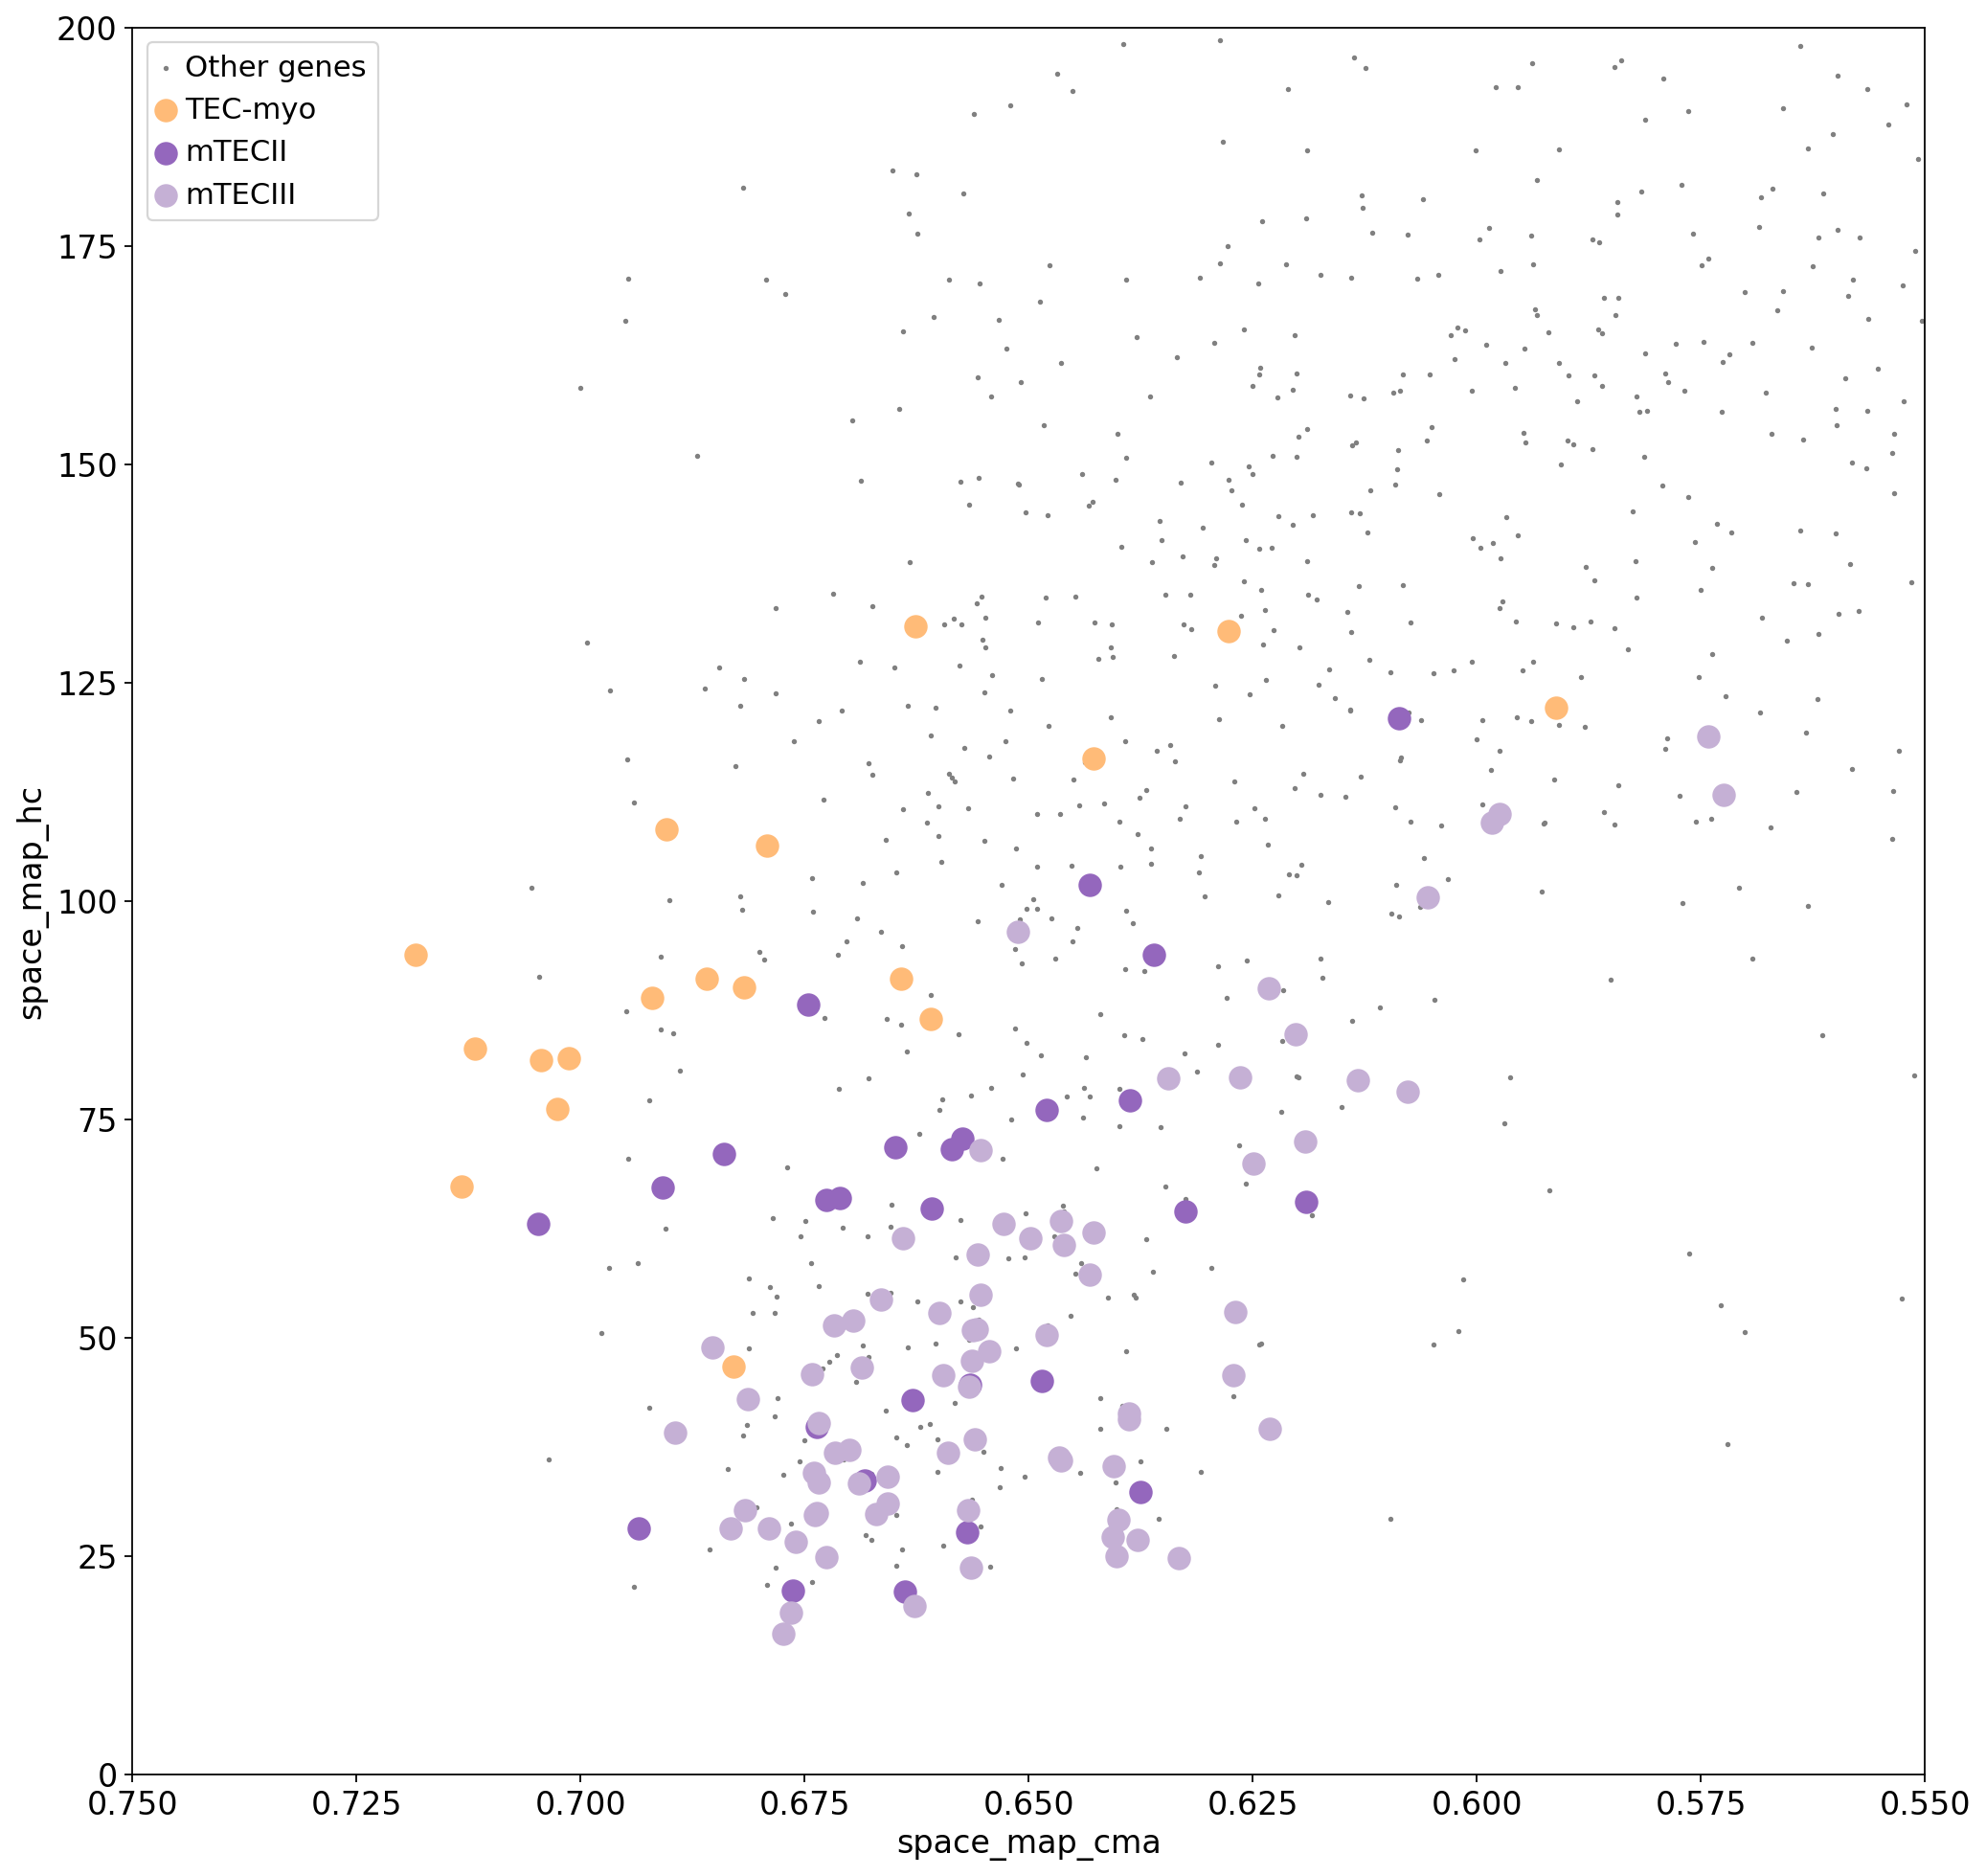

In [27]:
import matplotlib.pyplot as plt
sc.set_figure_params(figsize=[15,15],fontsize=15)
cmap = plt.get_cmap('tab20')
cell_spots = {}
for key in marker_dict_1.keys():
    df[key+'_unique'] = df.index.isin(marker_dict_1[key])
df

colors = sns.color_palette('tab20', 20)
# cmap = ListedColormap(colors)

plt.scatter(df['space_map_cma'], df['space_map_hc'], c='gray', label='Other genes', s=2)
for idx, key in enumerate(marker_dict_1.keys()):
    if 'TEC' in key:
        plt.scatter(df[df[key + '_unique']]['space_map_cma'], df[df[key + '_unique']]['space_map_hc'], c=colors[idx], label=key, s=100)

plt.grid(False)

# add axis labels
plt.xlabel('space_map_cma')
plt.ylabel('space_map_hc')

plt.legend()
plt.gca().invert_xaxis()

# Set axis limits
plt.xlim(0.75, 0.55) # Since you're inverting the x-axis, the limits are given in reverse order
plt.ylim(0, 200)

# plt.savefig('figures/HC_CMA_association_genes_Visium_scvi_cma0.55.pdf')
plt.show()


<Figure size 1200x1200 with 0 Axes>

Text(0.637795910732124, 107.62924853446242, 'AGRN')

Text(0.6198778025212911, 79.75567355277434, 'AL390719.2')

Text(0.6426345463502141, 131.81037102194225, 'TNFRSF18')

Text(0.5725742299665076, 161.73468086037894, 'TNFRSF4')

Text(0.6405708816620906, 127.90976720440534, 'TP73')

Text(0.6940005176336566, 21.400501938980536, 'HES2')

Text(0.6566624951361447, 49.72942663211759, 'ESPN')

Text(0.6708094213743979, 121.7587101089564, 'TNFRSF9')

Text(0.6176884034167253, 124.76847465417706, 'ERRFI1')

Text(0.6221274171656849, 100.65039047428101, 'GPR157')

Text(0.6172153218054032, 91.17420412455215, 'SLC25A33')

Text(0.6021583597617541, 165.63618726467845, 'FBXO6')

Text(0.5581597134112392, 150.14509370454232, 'PDPN')

Text(0.6124224740668384, 195.294045229254, 'TMEM51')

Text(0.5719976607040566, 37.74571931560042, 'EPHA2')

Text(0.5846090793778425, 108.73868873400801, 'ARHGEF19')

Text(0.579236060027367, 194.10443397694, 'BX284668.5')

Text(0.654350570481205, 116.46966935068045, 'PADI2')

Text(0.6190770411762113, 178.17927965217987, 'ARHGEF10L')

Text(0.6048087638996054, 126.10185932411166, 'TMCO4')

Text(0.6464350805493516, 63.37454082423691, 'PLA2G2F')

Text(0.6620778236014704, 39.79346665376955, 'CAMK2N1')

Text(0.6531624634807287, 35.063741722123254, 'WNT4')

Text(0.5705950624792491, 265.05502698645904, 'TCEA3')

Text(0.636391956162737, 105.92776371073766, 'MDS2')

Text(0.593833451336429, 195.8844491690854, 'CNR2')

Text(0.6741381277125913, 21.990021305175055, 'CRYBG2')

Text(0.6159768147922033, 204.3891941096224, 'ZNF683')

Text(0.5581764077626039, 115.10692683424139, 'MAP3K6')

Text(0.6609238295508955, 118.86649051860839, 'MECR')

Text(0.6677941424706823, 34.11026555419325, 'PTPRU')

Text(0.6707777705242837, 62.552312727656556, 'TMEM54')

Text(0.6791475750966001, 21.60866678375269, 'SH3D21')

Text(0.5911094033870116, 131.70725819905752, 'ZC3H12A')

Text(0.6436752393337593, 115.83627219144167, 'FHL3')

Text(0.6785466467415641, 105.68769815919711, 'MYCL')

Text(0.6318657279781933, 131.0440085653342, 'COL9A2')

Text(0.6678338315739433, 79.68341630568794, 'CITED4')

Text(0.5750394297948229, 135.5515028790156, 'B4GALT2')

Text(0.6189387515667445, 138.87244312688466, 'CCDC163')

Text(0.6836008766696493, 34.89479103620335, 'TSPAN1')

Text(0.6640602917913592, 61.38228177622945, 'CYP4B1')

Text(0.6716818295570157, 51.337771229008204, 'PDZK1IP1')

Text(0.6090071767667372, 101.8103920392631, 'TACSTD2')

Text(0.6785721417130035, 63.6189113825493, 'FGGY')

Text(0.5787186032449227, 118.54327747686708, 'PDE4B')

Text(0.6242863037522013, 160.25151140126368, 'MCOLN2')

Text(0.5937677516919441, 127.32585747923912, 'GBP3')

Text(0.6293025906139823, 163.89814303712552, 'GBP4')

Text(0.6633264384993071, 178.7314153394394, 'GBP5')

Text(0.576217873581639, 224.64702919943474, 'LRRC8C')

Text(0.6948451332935228, 87.35011166485508, 'EVI5')

Text(0.6402900295113045, 33.386767478917946, 'F3')

Text(0.6306106275039038, 142.69313430452127, 'CLCC1')

Text(0.6346495199731569, 39.546316079937306, 'CELSR2')

Text(0.559949791309111, 156.344036318929, 'CD58')

Text(0.640267359502745, 148.24515438073325, 'LINC02591')

Text(0.6399188175389244, 78.46884753044654, 'NBPF20')

Text(0.6307626337454286, 34.63673589182477, 'ANKRD35')

Text(0.5971863778938413, 134.31523600370014, 'AC245297.3')

Text(0.6648025102093444, 38.582505370024776, 'BNIPL')

Text(0.635449877164029, 29.238063325695883, 'TUFT1')

Text(0.6230821713939693, 39.56990002973886, 'RPTN')

Text(0.6562916883111064, 47.29805075177792, 'FLG')

Text(0.6764816306830573, 18.431105855266374, 'FLG2')

Text(0.6638293018081112, 20.920533387089534, 'LCE3D')

Text(0.6427465697870929, 62.00098006217565, 'IVL')

Text(0.6725150509227428, 24.820133127970177, 'SPRR3')

Text(0.6249133253108724, 69.86918751516386, 'SPRR1B')

Text(0.6760137598533343, 26.57864785572218, 'SPRR2D')

Text(0.6669563367165356, 29.806642885666864, 'SPRR2E')

Text(0.6736445883229866, 39.76667696983281, 'SPRR2G')

Text(0.6191976939574603, 72.43889069183713, 'LOR')

Text(0.6722370173252673, 47.22155639971498, 'PGLYRP4')

Text(0.6132380261442054, 79.40467854156802, 'S100A7')

Text(0.5993433994423799, 110.99294284137517, 'S100A2')

Text(0.6092830334015996, 158.21469532311863, 'IL6R')

Text(0.5653857847762771, 129.7717365585864, 'ZBTB7B')

Text(0.6783760962786154, 40.909767870672546, 'MUC1')

Text(0.6368706428777222, 61.28819380860888, 'RAB25')

Text(0.6203165734862615, 164.75777406523815, 'SEMA4A')

Text(0.6432183515272604, 77.58026821899105, 'CRABP2')

Text(0.6330054674073047, 147.84953090986252, 'FCRL5')

Text(0.6476588974040361, 172.71574232331963, 'FCRL3')

Text(0.644788175709025, 200.5117120041106, 'FCRL2')

Text(0.5564591154721178, 192.88292100490023, 'MNDA')

Text(0.6641511617758564, 25.69033292798744, 'VSIG8')

Text(0.6808257877678382, 52.826266000725056, 'IGSF9')

Text(0.5597650264044622, 194.52187071969607, 'SLAMF7')

Text(0.6465659043956272, 36.25940617203859, 'NECTIN4')

Text(0.6896978882141795, 84.76777104173955, 'FCRLA')

Text(0.5616008360014443, 211.9224476924137, 'OLFML2B')

Text(0.6501939668201312, 99.03251481418559, 'UAP1')

Text(0.59465955061008, 163.25673447068937, 'TBX19')

Text(0.5939125115286036, 176.19086034461242, 'XCL1')

Text(0.6074186020946312, 131.82732697228724, 'FMO1')

Text(0.608199067018387, 136.18918371671168, 'SOAT1')

Text(0.6750280196917932, 38.25935765239283, 'INAVA')

Text(0.6817775522411504, 90.07065893838092, 'TNNT2')

Text(0.6390892709321175, 98.90808990901101, 'LAD1')

Text(0.6859524972275348, 91.01892759855409, 'TNNI1')

Text(0.6189732085954426, 185.86331591707327, 'NAV1')

Text(0.6671290588609369, 53.96734274428487, 'ELF3')

Text(0.7184081172053411, 93.81774457747046, 'MYBPH')

Text(0.5752799309547918, 125.55881926756722, 'CHI3L1')

Text(0.5892425101642426, 152.28738625174043, 'CHIT1')

Text(0.5749302266070893, 172.7671367783864, 'FMOD')

Text(0.6178920187735898, 134.44716156063984, 'TMCC2')

Text(0.6540653978915023, 125.87225662604881, 'NUAK2')

Text(0.6095165226449515, 98.54947748732599, 'CDK18')

Text(0.6334478044332936, 162.20818159904158, 'RAB7B')

Text(0.6686426018723327, 46.54006187282647, 'PIGR')

Text(0.5700714911207443, 169.63469522940275, 'PLXNA2')

Text(0.6375044592888427, 35.790088890747136, 'ATF3')

Text(0.5871290047926753, 175.74257233319693, 'BATF3')

Text(0.6624679716576511, 183.15476055919967, 'HLX')

Text(0.6221974093257715, 157.61591863920256, 'DUSP10')

Text(0.6743201873298054, 58.50714128758333, 'SUSD4')

Text(0.7012512525468032, 81.94460176684274, 'ACTA1')

Text(0.6600556464589612, 107.45499281117853, 'C1orf198')

Text(0.6004887143893829, 141.48588624802127, 'GPR137B')

Text(0.6696691128691742, 154.99940023332246, 'ACTN2')

Text(0.5564508036856773, 156.0636880459666, 'CHRM3-AS2')

Text(0.6781784654524666, 123.75961241511685, 'CMPK2')

Text(0.6433116497863034, 145.1943546162876, 'RSAD2')

Text(0.6308937833510275, 171.34890343237788, 'ASAP2')

Text(0.6728391960339727, 24.93650174076184, 'GRHL1')

Text(0.657654943397816, 63.43383863845431, 'LRATD1')

Text(0.6134803088788205, 152.4302185174562, 'FAM49A')

Text(0.6512210629052269, 96.38919438814695, 'SDC1')

Text(0.6368308136584262, 112.61812649548513, 'TTC27')

Text(0.6889467147165752, 80.57092480667666, 'LTBP1')

Text(0.6588934902102795, 114.53642271560628, 'RASGRP3')

Text(0.6520885497579616, 191.04990658827253, 'QPCT')

Text(0.6242322409614823, 49.13497755933645, 'ASPRV1')

Text(0.6058555680470268, 104.88301344720759, 'RTKN')

Text(0.6525273665344419, 163.19155917335965, 'GNLY')

Text(0.5957054374171656, 158.7676066074907, 'LINC01943')

Text(0.5624826768977605, 172.63548967937507, 'CYTOR')

Text(0.6441664124157201, 58.47107267167387, 'PROM2')

Text(0.5540585563862167, 188.85439526334818, 'CNNM4')

Text(0.595582615881369, 120.96145219141205, 'SEMA4C')

Text(0.6325369963490745, 110.80800276667419, 'LINC01127')

Text(0.5762940773061308, 59.64770089107341, 'IL1R2')

Text(0.6242616481485247, 140.29362564829864, 'IL18R1')

Text(0.5671098962273611, 153.48348534941235, 'POLR1B')

Text(0.6388519252596105, 77.95885199658602, 'IL1RN')

Text(0.6710904354103664, 65.94109571258556, 'MARCO')

Text(0.6923791988619924, 41.99117096063525, 'STEAP3')

Text(0.6900862898733817, 100.0941735571362, 'LYPD1')

Text(0.6342248486030522, 117.87425566869925, 'GPD2')

Text(0.6623726775074065, 54.15123950801976, 'DAPL1')

Text(0.618415858403683, 64.03685791901754, 'GAD1')

Text(0.6395250363744639, 42.115042669184774, 'CHRNA1')

Text(0.6291090362161719, 139.24255882724026, 'CTLA4')

Text(0.6215942197478401, 89.70529765652932, 'ADAM23')

Text(0.6642432713410047, 91.08715746736698, 'MYL1')

Text(0.6204946199776146, 158.47823854847812, 'RUFY4')

Text(0.6596888250754432, 77.2616193188581, 'EPHA4')

Text(0.6257229070833799, 67.63161731620941, 'SGPP2')

Text(0.6688690560207446, 127.33600551794078, 'SP140')

Text(0.6447644474198622, 134.81709749703376, 'RAMP1')

Text(0.6486183111110135, 82.32886202699252, 'HES6')

Text(0.6695360445917975, 51.95493775491459, 'MAB21L4')

Text(0.6457630058440225, 77.63232961523168, 'FARP2')

Text(0.6353437569551027, 143.50268311417096, 'SUMF1')

Text(0.6567006297514268, 30.259092883315915, 'TMEM40')

Text(0.5877964920941418, 138.21600214336135, 'NR1D2')

Text(0.6158436100401782, 123.19327901701872, 'ZNF621')

Text(0.6629979334468769, 42.84611239425876, 'CCK')

Text(0.6129030936383744, 202.43247977984313, 'XCR1')

Text(0.5599016023436924, 154.44096170821012, 'CCRL2')

Text(0.6781874266336552, 133.49820770873805, 'CISH')

Text(0.6235148704352349, 125.28577578430802, 'ACY1')

Text(0.7044007662854525, 81.72516123968316, 'TNNC1')

Text(0.5792866615166947, 147.5189270717572, 'PRKCD')

Text(0.6310472613093765, 103.25437311566232, 'WNT5A')

Text(0.6597178999596602, 104.42217637375903, 'ABHD6')

Text(0.6832673895087941, 28.08083208916675, 'FAM3D')

Text(0.6436612563160378, 82.12770980906699, 'FEZF2')

Text(0.6379263150989575, 164.54084012775343, 'LRIG1')

Text(0.6506860364168309, 80.09992465473634, 'TMEM45A')

Text(0.5857701015448099, 110.16026429068683, 'NFKBIZ')

Text(0.6508800150560003, 159.35563327270918, 'TIGIT')

Text(0.6463512602912154, 161.5342450989192, 'CD86')

Text(0.6212310827365943, 172.81566778854727, 'ALDH1L1')

Text(0.6307560434022965, 105.10478065090953, 'RBP1')

Text(0.6644229802672275, 156.34913021363565, 'GPR87')

Text(0.6490318517584517, 99.11832212889765, 'P2RY1')

Text(0.6562158607968662, 53.43841497746491, 'PLD1')

Text(0.6935236132693081, 28.131593143304585, 'SST')

Text(0.6420251720972635, 87.04024058159507, 'TPRG1')

Text(0.6000663661726894, 118.49562055339922, 'CLDN1')

Text(0.6401995035340172, 24.944287534873872, 'MUC4')

Text(0.6063394008117297, 99.32077818604296, 'FGFR3')

Text(0.6432187077565887, 57.18665219449494, 'S100P')

Text(0.6856466283063437, 25.678658921798633, 'PSAPL1')

Text(0.5658341559731073, 190.71090081507575, 'CLNK')

Text(0.6754061217367279, 61.588364130077, 'LGI2')

Text(0.6271769562339916, 43.31056579282524, 'SLC34A2')

Text(0.5507721983608297, 184.91939572514593, 'SEL1L3')

Text(0.6296220330438085, 150.212683157937, 'TLR10')

Text(0.6773800972621159, 34.26917667619422, 'FAM114A1')

Text(0.5988176344009178, 108.2993789987826, 'LIMCH1')

Text(0.6238257664990314, 129.3418618823281, 'PDGFRA')

Text(0.6096535301830711, 126.1423450107209, 'HOPX')

Text(0.6948156459641488, 116.13493502527264, 'SPINK2')

Text(0.6605824597859907, 166.83508770120633, 'STAP1')

Text(0.6514636088249138, 94.43422589254412, 'CSN2')

Text(0.6189897947014951, 65.51774357149709, 'FDCSP')

Text(0.6976634230093195, 50.49864570783438, 'CXCL6')

Text(0.6657879317540243, 86.46637067573431, 'CXCL1')

Text(0.5587816990896372, 209.4215766832994, 'NAAA')

Text(0.5682657039001295, 180.51034017087173, 'CXCL9')

Text(0.6189211413184813, 154.02637311845, 'CXCL10')

Text(0.6554301733231354, 170.68491800571616, 'CXCL11')

Text(0.66740058474772, 133.67977641484515, 'CXCL13')

Text(0.5537688244115221, 209.29637862591736, 'ANTXR2')

Text(0.6209596217006119, 103.04204416619332, 'TMEM150C')

Text(0.5614542237640082, 84.62251800315796, 'PTPN13')

Text(0.6257962988855971, 141.29355180778936, 'SPP1')

Text(0.5786320788972661, 159.39841094536754, 'HERC6')

Text(0.6548562169884555, 132.40411259943812, 'HERC5')

Text(0.5630650560519805, 186.0998382269965, 'GPRIN3')

Text(0.612679421999464, 157.5187978628294, 'DAPP1')

Text(0.6201476290427775, 160.35602963540586, 'BANK1')

Text(0.6641621227399086, 94.84325614358994, 'FGF2')

Text(0.5869116638264621, 136.63205370041803, 'TMEM154')

Text(0.587495652400677, 226.90844614719524, 'MARCH1')

Text(0.578972744025518, 117.39311313701145, 'MSMO1')

Text(0.670688643683409, 36.03513166274804, 'TENM3')

Text(0.5939521333338483, 120.6012057339886, 'ACSL1')

Text(0.5914861848182341, 203.72215635998376, 'SEMA5A')

Text(0.5613146162065461, 180.96144310253064, 'OTULINL')

Text(0.5511323064035071, 174.42729525004287, 'EGFLAM')

Text(0.5997090396061181, 175.70775571384507, 'OSMR')

Text(0.6651509984930675, 183.56834998994856, 'GZMK')

Text(0.551738914719155, 221.4846143635116, 'VCAN')

Text(0.65146722604888, 85.41619000678875, 'ELL2')

Text(0.6489948328951699, 131.87591377892747, 'MCC')

Text(0.654826724339455, 128.97388954804882, 'SEMA6A')

Text(0.6679692348497059, 61.56055207447317, 'SNCAIP')

Text(0.6734619867823464, 33.375029282140304, 'AC113410.2')

Text(0.6202550882530141, 84.67714000220924, 'SPINK5')

Text(0.6692339310623436, 52.31916789094136, 'SPINK6')

Text(0.6566837613170367, 44.35828516538401, 'SPINK7')

Text(0.6464304558600695, 35.941071906574415, 'SPINK9')

Text(0.5837532060195695, 206.49398193518562, 'PCYOX1L')

Text(0.5845811858218661, 167.10174907251752, 'SYNPO')

Text(0.6325803469753842, 82.56830896724831, 'FAT2')

Text(0.6728576932726752, 111.57986778004134, 'THG1L')

Text(0.6359867264760152, 93.81222415947661, 'FABP6')

Text(0.6510609389753899, 147.6215466470412, 'MIR3142HG')

Text(0.6558430811605913, 50.96261603303554, 'GABRP')

Text(0.6193945222254694, 114.57727038157736, 'TSPAN17')

Text(0.5841857607460292, 169.0199679442114, 'IRF4')

Text(0.6556760593625485, 97.70235025981295, 'TUBB2B')

Text(0.5828202281804674, 236.9025694867539, 'PXDC1')

Text(0.6286025955440471, 173.00521684154904, 'LY86')

Text(0.6241047761897826, 135.54578719837747, 'ADTRP')

Text(0.5778196110180118, 163.7465898549443, 'PHACTR1')

Text(0.5838363617932539, 196.1899915159609, 'RNF144B')

Text(0.6271694018534708, 45.69791051546259, 'C6orf15')

Text(0.6739278120104731, 34.44045903582425, 'CDSN')

Text(0.6599469669067477, 52.767658410843666, 'PSORS1C2')

Text(0.6548959779098875, 123.8730555355746, 'LTA')

Text(0.6734410817960517, 40.20492905177443, 'LY6G6C')

Text(0.5520006557267787, 191.22183817366462, 'NEU1')

Text(0.642036241149897, 43.09210789204256, 'SLC44A4')

Text(0.5670205522712187, 181.4969068301079, 'CFB')

Text(0.5677881748806848, 158.13573688905265, 'HLA-DOB')

Text(0.6420562133491374, 39.47989967728676, 'TEAD3')

Text(0.667855210015549, 115.75972312363307, 'ETV7')

Text(0.6283141296977639, 186.86998974379142, 'MDGA1')

Text(0.6391746979584383, 150.70663386684618, 'TREML1')

Text(0.5954680328680414, 141.82930923224671, 'TFEB')

Text(0.5927811147886418, 101.02632520860257, 'MYO6')

Text(0.6384040260549738, 97.39675031622629, 'ANKRD6')

Text(0.5639103750567305, 197.89234668624397, 'CALHM6')

Text(0.639289766419218, 84.626559281695, 'SMPDL3A')

Text(0.5737406408564618, 128.26981682314232, 'SAMD3')

Text(0.6870172874955041, 150.91555779821815, 'ZC3H12D')

Text(0.6966666646508782, 124.1180811408845, 'CCR6')

Text(0.6588881665003977, 171.06800493617624, 'PDGFA')

Text(0.6462164896442103, 65.06962664016415, 'TMEM184A')

Text(0.6674755201296318, 114.40378033139156, 'SDK1')

Text(0.5843234786962228, 178.57404145200917, 'FBXL18')

Text(0.6549849946439935, 106.83491260505718, 'ICA1')

Text(0.6575807316709809, 54.06563655747437, 'AGR2')

Text(0.66481637050225, 23.804716272008385, 'ITGB8')

Text(0.6613426008871088, 108.97553218778633, 'UPP1')

Text(0.6236647027925216, 109.40785146028753, 'CLDN3')

Text(0.6040160477415842, 108.57065901987556, 'CLDN4')

Text(0.6085289583260316, 158.3583175337084, 'LAT2')

Text(0.6296657786152662, 57.96119766244929, 'GTF2IRD1')

Text(0.6396169130696624, 140.5625831893602, 'GSAP')

Text(0.6136854107649126, 196.49828648605217, 'SEMA3E')

Text(0.6242008454439514, 160.986283578541, 'CDK14')

Text(0.5770673631872099, 99.7691998452834, 'VPS50')

Text(0.6052516879002763, 160.31241208756688, 'TFPI2')

Text(0.663510210254087, 48.882944705134506, 'DLX5')

Text(0.6821711744592612, 100.50643062155928, 'CADPS2')

Text(0.6903650623297757, 108.16703345610843, 'FLNC')

Text(0.6291841371177425, 124.60484892723811, 'IRF5')

Text(0.6140536786697423, 130.7456355893997, 'AHCYL2')

Text(0.6734193131223192, 120.52199099987284, 'CPA5')

Text(0.6241085366288401, 49.27432847293772, 'AKR1B10')

Text(0.6239442752266062, 209.8215305465362, 'TMEM140')

Text(0.6513999152411982, 48.764334146588645, 'PRSS2')

Text(0.6799971327647535, 94.09104700063061, 'KEL')

Text(0.5665501946537916, 268.61043765810086, 'GIMAP8')

Text(0.6632626046621174, 138.76337264543935, 'AOC1')

Text(0.5573046560366394, 175.9316615201948, 'AGAP3')

Text(0.5984626981209374, 114.96697961627312, 'PRKAG2')

Text(0.6012639377723304, 165.33832427173672, 'TDRP')

Text(0.5682114758816009, 132.42273547530633, 'ANGPT2')

Text(0.6479072995946442, 51.384238866919645, 'DEFB1')

Text(0.6324532542841171, 64.42986672054282, 'DEFB4B')

Text(0.6585523645103971, 71.49735598179905, 'DEFB4A')

Text(0.6520460933188444, 121.72578528082745, 'PRAG1')

Text(0.5863461860336693, 175.36835370244262, 'MSRA')

Text(0.604183504479947, 146.51635740039532, 'BLK')

Text(0.623297469368737, 106.44618330490391, 'SLC7A2')

Text(0.6351328406685353, 141.32883511126957, 'SLC39A14')

Text(0.6503014049924131, 144.51774612479244, 'ADAM28')

Text(0.6078019519411552, 204.34978237350578, 'ADAMDEC1')

Text(0.5718181705374752, 162.54766516608822, 'SCARA3')

Text(0.5822115346305209, 157.77366235827313, 'DUSP4')

Text(0.6210506862856383, 192.92548731335228, 'IDO2')

Text(0.5630353699570667, 99.35993590829568, 'AP3M2')

Text(0.6400594552750326, 153.51435044479376, 'LYN')

Text(0.668980262918029, 33.31379093217532, 'SDR16C5')

Text(0.613145470771278, 135.98769570980375, 'MSC')

Text(0.6634665584182952, 122.30040117733553, 'HEY1')

Text(0.681189583475438, 56.78216343935526, 'CALB1')

Text(0.6779747227523678, 43.044529930828055, 'ESRP1')

Text(0.6740198714505226, 98.77766290652383, 'LAPTM4B')

Text(0.6025314308004892, 162.03057535668535, 'NIPAL2')

Text(0.6398535089191858, 109.08145371056517, 'GRHL2')

Text(0.6910516029347793, 85.23146552406804, 'NCALD')

Text(0.633495400981692, 211.403113235293, 'DPYS')

Text(0.6036469790914712, 265.5027959690975, 'EXT1')

Text(0.6715600457002993, 36.78484969705207, 'MAL2')

Text(0.6372599787632272, 84.15445933988397, 'SNTB1')

Text(0.6397823741861306, 103.90884381426021, 'SQLE')

Text(0.6128208998106138, 180.72904337120104, 'LINC00861')

Text(0.6362533545101016, 138.8004455563952, 'PVT1')

Text(0.6236740383470828, 133.26990666639568, 'COL22A1')

Text(0.5636413042694385, 152.81583051060142, 'PTK2')

Text(0.6910764586791087, 93.55617073327596, 'ADGRB1')

Text(0.665759368361999, 30.963339476803544, 'PSCA')

Text(0.678209063888938, 23.63654748294017, 'SLURP1')

Text(0.6232506507264856, 89.96136042218335, 'LYPD2')

Text(0.6544433559241174, 48.41547742191334, 'SLURP2')

Text(0.6263617044788754, 79.76047042175469, 'LY6D')

Text(0.5643786468926735, 112.4497494437952, 'MROH6')

Text(0.6647134453501693, 103.28368766861804, 'MAPK15')

Text(0.6217707439146452, 75.86050572233707, 'FAM83H')

Text(0.6015106876518174, 56.692265924051945, 'KANK1')

Text(0.606195409744753, 120.71171775191235, 'JAK2')

Text(0.5755253515312527, 109.0070200676468, 'ERMP1')

Text(0.6560757225185829, 28.250679491089574, 'CDKN2A')

Text(0.6405657282700439, 27.10184985123637, 'CDKN2B')

Text(0.6286226643516595, 198.47740419218638, 'TUSC1')

Text(0.6311939005055067, 80.48131375620306, 'CCL27')

Text(0.6391566264478349, 48.3951793528351, 'UNC13B')

Text(0.5741813881331658, 173.47771145629076, 'PAX5')

Text(0.5945837341965835, 152.46988410245967, 'SHB')

Text(0.5821905376551568, 134.67571595792216, 'BX255923.2')

Text(0.6682250790083469, 27.3720845252447, 'GDA')

Text(0.6243860218353403, 170.62504127756105, 'NTRK2')

Text(0.6331757501527717, 109.41330133273767, 'NFIL3')

Text(0.6056007717759593, 152.70963975459114, 'AOPEP')

Text(0.6198434505265025, 201.71094067918912, 'ANKS6')

Text(0.5722781025463941, 123.43448806011698, 'KLF4')

Text(0.6347902503368528, 67.24602507008127, 'PTPN3')

Text(0.6519504508424129, 74.90530056991047, 'PTGR1')

Text(0.6256379449812757, 93.11737641174523, 'SLC31A2')

Text(0.6647409120740925, 29.620942624147848, 'BSPRY')

Text(0.5524523592832596, 170.41679295509385, 'RGS3')

Text(0.6407843579357314, 129.03455226709085, 'NEK6')

Text(0.6086617369607508, 98.20244657317514, 'NIBAN2')

Text(0.6076882506904688, 78.13775939863586, 'LCN2')

Text(0.6566648331108199, 145.30426357092395, 'DNM1')

Text(0.6503881197257944, 64.22339053031476, 'IER5L')

Text(0.617388489335182, 112.0807989435783, 'PTGES')

Text(0.6636275453012627, 82.71089368002905, 'NCS1')

Text(0.5989083733962862, 163.66664964891285, 'NTNG2')

Text(0.6860970692148464, 124.26758337857594, 'SLC2A6')

Text(0.582236987655715, 138.85245344324227, 'SARDH')

Text(0.6610257583757788, 40.113677245089654, 'AL590226.2')

Text(0.6487490595780616, 168.61592456863858, 'C9orf139')

Text(0.5563771194639852, 166.6337926965471, 'UAP1L1')

Text(0.600520881141036, 127.37957521797907, 'TPRN')

Text(0.5700565041151499, 50.643300030338345, 'NRARP')

Text(0.5602571426250113, 187.74329670415267, 'EXD3')

Text(0.5982707455830902, 108.94261074170558, 'CALML5')

Text(0.5533168589143594, 200.29444172678885, 'PLXDC2')

Text(0.6478293016244511, 120.00185997426573, 'MAP3K8')

Text(0.6174338754196038, 171.6250430247496, 'ALOX5')

Text(0.5863996674666894, 165.36106673317585, 'ARHGAP22')

Text(0.681349436294698, 42.9876069574286, 'SLC16A9')

Text(0.558356722315611, 138.52236061961838, 'ANK3')

Text(0.6905322367656455, 62.45269407707488, 'H2AFY2')

Text(0.5597757235758634, 176.8317785013542, 'PRF1')

Text(0.6727629217687167, 86.552220739526, 'ADAMTS14')

Text(0.6531999944941762, 32.900586282379095, 'UNC5B-AS1')

Text(0.6120260884439063, 127.53389895093285, 'PLAU')

Text(0.674544749335663, 88.13375223783775, 'SFTPA2')

Text(0.7047668451218749, 62.96436954599161, 'SFTPA1')

Text(0.6031777482724415, 102.44979612814909, 'SNCG')

Text(0.6400144933952132, 29.117865898134323, 'FAM25A')

Text(0.6261605327057549, 145.37877616979242, 'CH25H')

Text(0.6139522773540275, 152.1409074038369, 'IFIT2')

Text(0.6337878390729375, 128.05804829587248, 'IFIT5')

Text(0.6771146914391135, 169.49121862408273, 'HHEX')

Text(0.6803495032948339, 30.551764920605155, 'CYP26A1')

Text(0.5919935065286122, 165.13616907141989, 'ENTPD1')

Text(0.6741243876864523, 102.620863804579, 'BLNK')

Text(0.6001289737642578, 185.89043431595252, 'PIK3AP1')

Text(0.6090786088806649, 110.72687195232363, 'RRP12')

Text(0.6703232044921789, 95.38556547761918, 'LOXL4')

Text(0.5764598086189769, 190.42407919377078, 'GSTO2')

Text(0.6347422487528834, 135.0418408547302, 'DUSP5')

Text(0.5746549065780311, 163.96460933338795, 'SHTN1')

Text(0.6734114159520984, 55.833480639384675, 'BAG3')

Text(0.6287374600447491, 120.73353899140588, 'INPP5F')

Text(0.5858620122818974, 168.9787126882981, 'FGFR2')

Text(0.6612854966201233, 112.36821584420424, 'PWWP2B')

Text(0.555276841200597, 160.96090329115077, 'ADAM8')

Text(0.5536411237021464, 107.08029619773511, 'PKP3')

Text(0.6392185643472498, 92.16671675487785, 'EPS8L2')

Text(0.7132177055306556, 67.29122107315837, 'TNNI2')

Text(0.5911038617445302, 122.07758039254695, 'TNNT3')

Text(0.5756108085944195, 141.07178451362918, 'TSPAN32')

Text(0.6512188386056572, 147.73190024522052, 'PPFIBP2')

Text(0.5514967374859664, 136.44235093666018, 'PDE3B')

Text(0.6585926827216202, 114.10732444015088, 'NAV2')

Text(0.6453163796463938, 52.515596998243566, 'NELL1')

Text(0.669297230698912, 44.869709225448744, 'MUC15')

Text(0.6599732919902187, 76.04766242839675, 'PRRG4')

Text(0.6718614473611877, 135.11776943290374, 'PRR5L')

Text(0.6783288313775745, 52.75096853884313, 'SLC35C1')

Text(0.558930501111147, 159.76641670148345, 'PTPRJ')

Text(0.6582743032692581, 42.54448626067416, 'TMEM132A')

Text(0.6227725216016373, 150.99276260878452, 'VPS37C')

Text(0.665437158965386, 62.721766958329084, 'SCGB2A1')

Text(0.6485422648206471, 45.02659881964357, 'SCGB2A2')

Text(0.668334883597085, 33.580863960181205, 'SCGB1A1')

Text(0.6122000620801636, 142.1191465379218, 'PLAAT3')

Text(0.6818068774871554, 181.63441901876922, 'NAALADL1')

Text(0.6231416705794268, 206.86511903490256, 'CTSW')

Text(0.6554064748339363, 71.42449427290778, 'CST6')

Text(0.6968609477800645, 57.92916484498839, 'SPTBN2')

Text(0.651419292876163, 105.99159003446337, 'SSH3')

Text(0.6603441672162764, 122.0508684691961, 'CARNS1')

Text(0.6553643562187937, 54.8784628563265, 'ALDH3B2')

Text(0.6678115061083765, 47.750447485828474, 'GAL')

Text(0.6748948021965855, 63.30105585153013, 'DGAT2')

Text(0.6182521786751057, 144.1490218538524, 'MYO7A')

Text(0.5967672584427766, 161.52318994119997, 'RAB30')

Text(0.5768656023798854, 158.39461279231887, 'SYTL2')

Text(0.6648861447796361, 71.81131690526806, 'MMP7')

Text(0.6130358243600741, 144.3633095937499, 'MMP12')

Text(0.689405700150085, 39.06718278235209, 'CARD18')

Text(0.6380422733410547, 54.50975156663356, 'SLC35F2')

Text(0.6398984678374523, 74.17643632379718, 'COLCA1')

Text(0.5619310043735785, 175.90888819404847, 'POU2AF1')

Text(0.6443769888429512, 110.88555664880896, 'LAYN')

Text(0.6762571453897929, 20.982191518912604, 'APOC3')

Text(0.6442738852774256, 34.48460457910442, 'TMPRSS4')

Text(0.671221475984736, 78.42168726271346, 'MPZL3')

Text(0.5993922989288474, 120.66655610404219, 'NECTIN1')

Text(0.57244787804474, 227.6044350462564, 'OAF')

Text(0.553523364567361, 112.53043002656507, 'ZNF202')

Text(0.5565861320380232, 149.45827577319199, 'ST14')

Text(0.6428828835597177, 145.72476101341172, 'WNT5B')

Text(0.6827578547977204, 115.46049859502429, 'AC005842.1')

Text(0.6729742027166176, 46.49476755218636, 'SCNN1A')

Text(0.6391336946482127, 171.0868897355508, 'LAG3')

Text(0.6344453492651169, 79.69973801857346, 'A2ML1')

Text(0.6557187270711923, 159.91038707022798, 'KLRB1')

Text(0.6992870696335874, 129.53833834860794, 'AC010186.3')

Text(0.6127818455752191, 179.33092445910194, 'KLRK1')

Text(0.6556202385930403, 148.3908308234371, 'BCL2L14')

Text(0.6164743099072795, 126.46537576735666, 'PLBD1')

Text(0.6600378214241557, 110.77766755694785, 'MGST1')

Text(0.6047702492590671, 88.6410262829757, 'PKP2')

Text(0.6624440125965784, 176.35287035184203, 'LRRK2')

Text(0.6664755804185418, 96.4827056471402, 'NELL2')

Text(0.6141644667743865, 157.8366113618337, 'PCED1B')

Text(0.676933007849631, 69.51526605513999, 'WNT10B')

Text(0.6200991400082327, 79.85332854662258, 'ACVR1B')

Text(0.6736414595850967, 29.914071485181683, 'KRT80')

Text(0.6437779933753718, 78.54057473668465, 'KRT7')

Text(0.6388466442069203, 40.610383861435025, 'KRT75')

Text(0.6460769663519842, 60.56575134745627, 'KRT6B')

Text(0.6324690216786016, 65.87908865284878, 'KRT2')

Text(0.6852882911331546, 48.89702915827143, 'KRT77')

Text(0.6388226089883169, 41.33189763458591, 'KRT4')

Text(0.6497670191850142, 61.392813147266025, 'KRT79')

Text(0.6564476047217557, 23.60849349629623, 'KRT78')

Text(0.5738790904341686, 109.39752489997757, 'KRT18')

Text(0.6712540988134521, 93.84344433303386, 'RARG')

Text(0.6375020550389938, 32.28258285790517, 'LACRT')

Text(0.6402030421079391, 30.364783321603444, 'MUCL1')

Text(0.6270926737710695, 113.61796624433335, 'SUOX')

Text(0.6574481062300039, 131.66461003266522, 'IKZF4')

Text(0.676533953632817, 28.683292642062376, 'ERBB3')

Text(0.5975014872035666, 133.54007337559543, 'HELB')

Text(0.6139833862243126, 171.28726927683928, 'PLXNC1')

Text(0.6562974184901864, 31.092918880946584, 'MYBPC1')

Text(0.5773184839160896, 111.97231682302167, 'CHPT1')

Text(0.6446203652983425, 96.84402568916131, 'DRAM1')

Text(0.6025393299960689, 126.38685801421578, 'ASCL1')

Text(0.6482630505792104, 154.47731112835064, 'NUAK1')

Text(0.5596336498122161, 132.80131063109283, 'CKAP4')

Text(0.5954647004728738, 193.18135489451385, 'CMKLR1')

Text(0.5846403240749792, 131.17756686366974, 'MVK')

Text(0.5812432477349165, 162.65460708800944, 'HVCN1')

Text(0.6090826514589004, 147.6884478628259, 'PLBD2')

Text(0.6845653814722307, 126.69017824777195, 'OASL')

Text(0.7046429187340131, 91.24257730101132, 'P2RX2')

Text(0.6812594467379767, 48.701491129808105, 'TNFRSF19')

Text(0.6468615058174917, 194.6689107850546, 'ATP8A2')

Text(0.6364136148962628, 157.78947588053992, 'FLT3')

Text(0.589901955997367, 152.70823836575246, 'POSTN')

Text(0.6819515770084947, 98.93062879217813, 'FAM124A')

Text(0.6580962771499731, 59.154349373035934, 'OLFM4')

Text(0.5842188592505432, 113.22140360815429, 'KLF5')

Text(0.5692018237801497, 163.83403379265863, 'TBC1D4')

Text(0.6789532468171516, 28.180015076350443, 'SCEL')

Text(0.6150486148536121, 76.38200793316523, 'ABCC4')

Text(0.5966592874718933, 143.89865347605286, 'GPR183')

Text(0.6196188748247873, 104.14643112640893, 'GAS6-AS1')

Text(0.593244428472722, 182.53168820611904, 'SLC7A7')

Text(0.5813294560672513, 150.78915495097925, 'MMP14')

Text(0.7035066620535817, 36.05192214935324, 'AJUBA')

Text(0.6228636221529295, 140.40029015523638, 'SLC22A17')

Text(0.6494803899229037, 100.11788130966255, 'EFS')

Text(0.6626649108753487, 131.43182548291975, 'MYH7')

Text(0.6143915946313354, 133.0438555283347, 'PCK2')

Text(0.6755102818076921, 35.857322228767025, 'TGM1')

Text(0.6609390771008333, 89.17859734406382, 'CBLN3')

Text(0.6594054502482108, 131.68832572161512, 'GZMB')

Text(0.694717812121041, 70.43312262631805, 'STXBP6')

Text(0.5974672635362086, 117.18147278377582, 'LINC01588')

Text(0.5650288643872577, 297.2244541304533, 'PYGL')

Text(0.5996441225452358, 140.4528379889226, 'TMEM30B')

Text(0.6138924595833929, 86.19728291284385, 'PLEKHG3')

Text(0.667967121929092, 54.94697387352806, 'GPX2')

Text(0.6259506011609222, 165.42877881178467, 'PLEKHH1')

Text(0.6558033693331032, 134.0042283473695, 'BATF')

Text(0.6077619628774641, 176.25129074590453, 'VASH1')

Text(0.5935448778704768, 167.74759453313047, 'TCL1A')

Text(0.6451149981935259, 95.36749106026515, 'DLK1')

Text(0.6085067061370598, 116.41293516420215, 'CKB')

Text(0.5973157917806365, 139.2604176672646, 'PPP1R13B')

Text(0.6700086235861358, 37.11009883041309, 'ASPG')

Text(0.6653294995865614, 65.18791773144582, 'CEP170B')

Text(0.6326892708526635, 131.68728358044783, 'PLD4')

Text(0.6781503535671902, 215.80873449603962, 'IGHA2')

Text(0.6532896001560534, 166.48146736103647, 'IGHE')

Text(0.5972997341323211, 172.12588210352004, 'FAM30A')

Text(0.6465300809386089, 109.91912922148087, 'GABRA5')

Text(0.679192165930096, 106.30693207036319, 'ACTC1')

Text(0.5599252115410567, 142.02051746486148, 'MEIS2')

Text(0.6658992657580525, 107.0052429015718, 'CCDC9B')

Text(0.5873176103105049, 131.97910533949369, 'CHST14')

Text(0.5831551062521801, 128.83734500490598, 'SPINT1')

Text(0.6439460044153115, 75.13285407495434, 'RHOV')

Text(0.6141377397001748, 121.84445448832703, 'AC020659.1')

Text(0.6048629205695046, 49.14747696273048, 'DUOX1')

Text(0.6303289450919507, 100.46537864318445, 'C15orf48')

Text(0.5503038713580698, 166.37328796072921, 'CGNL1')

Text(0.568431171446691, 121.49958011003463, 'MYO1E')

Text(0.584313070525196, 180.00094667577528, 'RORA')

Text(0.6583844017156736, 132.30865957478247, 'C2CD4B')

Text(0.665962898089375, 41.66061399175796, 'CILP')

Text(0.6241054612062102, 237.40116773986816, 'CD276')

Text(0.5692387082679203, 93.31826773676914, 'ADAMTS7')

Text(0.6087677077326328, 151.63576831253647, 'BCL2A1')

Text(0.6552987147142899, 134.86314393501678, 'ARNT2')

Text(0.6452088828302176, 104.00418637269273, 'ABHD17C')

Text(0.5534251478068137, 153.43394640053734, 'HAPLN3')

Text(0.6817997698098829, 125.35700513927465, 'ZNF710')

Text(0.6541619162819133, 157.78537933496708, 'SV2B')

Text(0.5932435289262806, 167.0306440120824, 'SLCO3A1')

Text(0.5715595283984701, 142.18974982920508, 'TTC23')

Text(0.5908684008298142, 161.59235910600185, 'LRRK1')

Text(0.5892536488047445, 131.30561643097917, 'AC009041.2')

Text(0.6337082596335237, 116.00245089108395, 'CCDC154')

Text(0.6781051684718464, 54.69164037902489, 'NOXO1')

Text(0.6603628868862389, 49.339156463735904, 'LINC00514')

Text(0.663549355832471, 37.68643127954824, 'BICDL2')

Text(0.6036974163772271, 202.83195702963022, 'MMP25')

Text(0.6713878706382331, 47.93293629228689, 'SMIM22')

Text(0.6502513377625169, 83.69894121844553, 'PPL')

Text(0.6394952124220697, 198.12940038975597, 'EEF2KMT')

Text(0.6203430200100825, 112.90829683832519, 'EMP2')

Text(0.7028920394023626, 76.24124201952294, 'TVP23A')

Text(0.5540763656445642, 226.31457818439455, 'SCNN1G')

Text(0.5771605962364317, 181.9317137432983, 'APOBR')

Text(0.5860732624364002, 158.91627052302186, 'CD19')

Text(0.6276688003886872, 130.8322678328054, 'MYLPF')

Text(0.6510274635418768, 97.85041656432955, 'ZNF764')

Text(0.6742092992010493, 45.825648324256285, 'PYDC1')

Text(0.6642751744344082, 85.78552582551181, 'ITGAM')

Text(0.6814808033724967, 39.98480916244856, 'NETO2')

Text(0.642210799095365, 127.73599802632403, 'NKD1')

Text(0.6936211398627695, 58.46526933926984, 'IRX3')

Text(0.6541471577149003, 78.56611920751, 'CES1')

Text(0.6908385577098638, 67.20753156867588, 'MT3')

Text(0.6576171346303422, 147.95729631227223, 'ADGRG5')

Text(0.649098267981582, 103.85227813295687, 'KIFC3')

Text(0.667517371101296, 34.34404889236172, 'NDRG4')

Text(0.5937539157346897, 172.86228623747886, 'CDH11')

Text(0.6684669630913851, 49.126620214256846, 'RRAD')

Text(0.6424273043221955, 69.41027885083238, 'TPPP3')

Text(0.6577277483726343, 126.89050672877941, 'DDX28')

Text(0.5529057096623285, 117.15300127173609, 'IL34')

Text(0.6141444356945933, 121.77288287695396, 'ZNF821')

Text(0.6279252027468379, 88.85945076517802, 'KIAA0513')

Text(0.6278100923844777, 174.92293117725544, 'SCARF1')

Text(0.5979362501849417, 193.14767193066467, 'SERPINF2')

Text(0.6789080731678332, 55.73770300881332, 'GGT6')

Text(0.6384253537060601, 248.43099428251756, 'CLEC10A')

Text(0.6264971442123326, 71.98163848852766, 'CLDN7')

Text(0.6249922146184953, 148.84188871553042, 'TMEM102')

Text(0.6239686351459182, 177.84905487377853, 'TNFSF12')

Text(0.5949350273817698, 126.41312217721823, 'TMEM88')

Text(0.6542945556463878, 23.782046732860014, 'ALOX12B')

Text(0.585018164972649, 91.00252833412662, 'PIK3R6')

Text(0.6427149377035661, 116.25784636175295, 'MYH3')

Text(0.6449647042226937, 113.90914524358132, 'ALDOC')

Text(0.6504534953498439, 59.116084980384, 'TLCD1')

Text(0.6320169216803799, 135.05197219168113, 'NEK8')

Text(0.5763734404246682, 146.24345008994626, 'DHRS13')

Text(0.6187786662814202, 135.01816133736293, 'RNF135')

Text(0.5573890512814369, 133.16117494420652, 'RAB11FIP4')

Text(0.5956591872196452, 131.9563708733076, 'CCL3')

Text(0.7054509789934349, 101.48730083664685, 'EPOP')

Text(0.58126078203413, 189.4144074130736, 'PCGF2')

Text(0.6480647835149329, 134.71929644484743, 'PGAP3')

Text(0.6074172266193505, 109.00081445307792, 'ERBB2')

Text(0.5919043204940406, 66.83749891506658, 'RAPGEFL1')

Text(0.5887604187882793, 157.16254488720227, 'RARA')

Text(0.5665438404922312, 213.95647336649813, 'AC004585.1')

Text(0.6269649614681935, 52.94065973709035, 'KRT23')

Text(0.6550453578333093, 36.92475188466944, 'KRT33B')

Text(0.6601933660879861, 34.65429145705721, 'KRT31')

Text(0.6621685896854377, 73.34690560399459, 'KRT36')

Text(0.5908554445713347, 120.13519785979221, 'KRT13')

Text(0.610775794980132, 87.7703016923362, 'KRT9')

Text(0.570798375179704, 101.4785447345822, 'KRT16')

Text(0.6479610768280339, 76.06795353424987, 'GAST')

Text(0.632837089879732, 139.47181132366296, 'P3H4')

Text(0.7000362016327378, 158.75404139864435, 'CNTNAP1')

Text(0.6565304225146065, 44.54978467346742, 'PYY')

Text(0.5826722898296659, 218.93786070098938, 'TBKBP1')

Text(0.6197412218757824, 128.9814789120706, 'ITGA3')

Text(0.562606007458052, 163.34098328325385, 'ACSF2')

Text(0.6020687087105943, 50.68513488271808, 'RNF43')

Text(0.6059800601071121, 180.30683294087103, 'TANC2')

Text(0.6529432865696525, 70.43317707660978, 'CYB561')

Text(0.6829536372835423, 46.67149434699925, 'CSH1')

Text(0.6971707831220404, 228.47749691069515, 'PRKCA')

Text(0.6675254214578394, 26.765679854359536, 'C17orf58')

Text(0.5672490816870273, 108.44414429323017, 'AC005332.6')

Text(0.552572101994618, 54.481663613237984, 'WIPI1')

Text(0.67925628124457, 171.14290392660087, 'LINC00511')

Text(0.6352599096750505, 74.07987911902353, 'SLC39A11')

Text(0.6564511432692992, 77.67570167665708, 'KIF19')

Text(0.6129607986305468, 114.21794788720958, 'LLGL2')

Text(0.6405134591585663, 35.266347226587335, 'SMIM5')

Text(0.6562830509265841, 31.42693103901157, 'EVPL')

Text(0.6411313966715687, 54.52183468880468, 'ZACN')

Text(0.5825969112620907, 144.59798597083957, 'RHBDF2')

Text(0.6946535136600682, 171.2463660099695, 'SLC26A11')

Text(0.6431614491516516, 101.76098678411758, 'NPB')

Text(0.5908209054424073, 186.03660860543135, 'SECTM1')

Text(0.6570539907755375, 28.200450961297307, 'ZNF750')

Text(0.5947936991689005, 153.6038488843524, 'TUBB6')

Text(0.6276554563389957, 148.2345202618066, 'CABLES1')

Text(0.6517159733841127, 113.93317369592098, 'ANKRD29')

Text(0.628841783594191, 92.4405714143084, 'DSC3')

Text(0.6726024380820547, 65.69223193537785, 'TTR')

Text(0.5524168021501354, 157.16154046377744, 'SMAD7')

Text(0.6447388894199093, 57.31383950348045, 'MYO5B')

Text(0.6139846256173148, 144.41804962891877, 'ALPK2')

Text(0.6762407787332433, 118.30359581996882, 'TNFRSF11A')

Text(0.6561686668665642, 50.87624756993556, 'SERPINB13')

Text(0.65563988699052, 59.49713229019905, 'SERPINB4')

Text(0.6528044268783134, 62.962920675109466, 'SERPINB3')

Text(0.6479855401037542, 50.26991151652105, 'SERPINB7')

Text(0.6657731794873365, 34.08354232128487, 'SERPINB2')

Text(0.5759127888594887, 176.38336465921572, 'CD226')

Text(0.6082524643283573, 160.29324511619242, 'MBP')

Text(0.6116681391637497, 176.51615354407065, 'GNG7')

Text(0.5868333632805492, 160.12388628036192, 'MATK')

Text(0.5898117841161354, 160.13157349487284, 'EBI3')

Text(0.6270454600542463, 213.9230674409591, 'TICAM1')

Text(0.6485703239330406, 125.35587043819758, 'NRTN')

Text(0.6075768171686196, 121.51588976084231, 'SLC25A23')

Text(0.6840392290417302, 70.96371516378855, 'CD70')

Text(0.6259408280576549, 136.596116813692, 'TRIP10')

Text(0.5913683744887067, 113.90630119335137, 'SH2D3A')

Text(0.6292745798535961, 138.40323152156452, 'FCER2')

Text(0.6360863591020636, 57.47211044276357, 'MUC16')

Text(0.584671393623209, 195.4239713194694, 'S1PR2')

Text(0.6029168463991793, 164.7404701377703, 'AC011511.5')

Text(0.5620028409425064, 123.14046897143693, 'ZSWIM4')

Text(0.6165621461728227, 99.88690318040554, 'AC020916.1')

Text(0.6816392553174344, 30.18321040072383, 'CASP14')

Text(0.665369060367717, 55.05712744064559, 'EPHX3')

Text(0.6550958308440576, 129.8856322903153, 'CYP4F12')

Text(0.6470726202310629, 93.37903121496525, 'CPAMD8')

Text(0.5818290765525245, 155.9992898889816, 'NIBAN3')

Text(0.5646135046821221, 136.38595535503808, 'FXYD3')

Text(0.6474766872340482, 97.9377878771527, 'LSR')

Text(0.6050570616730506, 154.2750519493682, 'CD22')

Text(0.6054443141672626, 100.42227129022278, 'KRTDAP')

Text(0.5879880143029477, 119.87799339436894, 'DMKN')

Text(0.6288424143512863, 83.51449881674125, 'SBSN')

Text(0.5975034994483923, 109.87797265745218, 'C19orf33')

Text(0.619842620876813, 153.10524570587202, 'CAPN12')

Text(0.6522391452278403, 59.06427340930254, 'LGALS7B')

Text(0.5737351421152702, 138.15824792626267, 'NCCRP1')

Text(0.5630503067805072, 136.2385979382355, 'FCGBP')

Text(0.5731545696748687, 143.16163471722828, 'SERTAD1')

Text(0.6574039358650744, 72.78416454340773, 'MIA')

Text(0.5968826803533793, 74.56340295200006, 'CYP2S1')

Text(0.647894025953557, 144.1223133498254, 'LINC01480')

Text(0.6217215222394225, 120.06743488261272, 'CEACAM21')

Text(0.6332128389393482, 24.744352849119284, 'CEACAM6')

Text(0.6382743330501744, 54.88160808958451, 'CNFN')

Text(0.6774035642339545, 16.02828868160084, 'CXCL17')

Text(0.5924126063464698, 108.96305357596695, 'LYPD3')

Text(0.6460991386460962, 64.47152430350602, 'PVR')

Text(0.6639786527798218, 165.2472921281299, 'APOC2')

Text(0.7118043803847911, 83.03347123579782, 'CKM')

Text(0.65780666012962, 84.67371642300603, 'PPP1R13L')

Text(0.5962346637009535, 79.80340936132906, 'SIX5')

Text(0.6627203459603626, 19.24123695769594, 'IGFL2-AS1')

Text(0.6594922219213342, 26.127955795115735, 'IGFL1')

Text(0.6376062301169603, 111.76822501497571, 'PTGIR')

Text(0.6821904182563069, 122.3191075912243, 'GNG8')

Text(0.6221474168588541, 144.05232868628684, 'TRPM4')

Text(0.611463412709914, 237.009466060707, 'TEAD2')

Text(0.5981996414905584, 140.9858213034393, 'IL4I1')

Text(0.6471893691539499, 61.5661594211122, 'MYH14')

Text(0.5906120303841836, 150.00549636546933, 'SPIB')

Text(0.679473316249358, 93.28878845582611, 'MYBPC2')

Text(0.6608928467459038, 86.50824675551412, 'AC020909.2')

Text(0.659003760518755, 36.77478066962509, 'KLK6')

Text(0.6559996209079055, 38.30217292647183, 'KLK7')

Text(0.673856473375594, 29.61860723434776, 'KLK8')

Text(0.6595330734328658, 45.72697543877867, 'KLK10')

Text(0.6602171810874841, 38.37367403107298, 'KLK11')

Text(0.6336734325117122, 226.87928894866985, 'SIGLEC10')

Text(0.5578728168090195, 244.04974994314725, 'SIGLEC14')

Text(0.6407197691605212, 131.6444089997222, 'LILRA4')

Text(0.6216857760689884, 83.91088148447021, 'NLRP2')

Text(0.655523123130326, 52.06058723177199, 'EPS8L1')

Text(0.692018924850263, 88.8896784300256, 'TNNT1')

Text(0.6553579755148502, 28.32699626082013, 'SDCBP2')

Text(0.5790259947750966, 160.37828226760269, 'SIRPA')

Text(0.6392036321009816, 118.29541470604502, 'EBF4')

Text(0.5727034073812948, 156.02685360899628, 'JAG1')

Text(0.5684906500798802, 177.1501519757149, 'FLRT3')

Text(0.6378385078269194, 26.775145918700133, 'AL121761.1')

Text(0.6201197909735136, 102.8951676995296, 'INSM1')

Text(0.638669709065759, 77.1841502218046, 'CST4')

Text(0.6608099559008642, 64.70225914519223, 'CST1')

Text(0.6569050289756051, 27.705534845289055, 'CST2')

Text(0.6273867631064258, 146.99712727535947, 'CST7')

Text(0.6572327542698432, 180.93929241947475, 'MIR663AHG')

Text(0.637106051050917, 91.94925436889191, 'NECAB3')

Text(0.5632160272316418, 119.2101859366857, 'PXMP4')

Text(0.6248298315368084, 110.61381081282815, 'MAP1LC3A')

Text(0.5618748474039593, 130.59166680219607, 'SOGA1')

Text(0.5536672337503444, 151.25536311135232, 'SRC')

Text(0.6491080572683172, 109.89474658177862, 'NNAT')

Text(0.6582751862710802, 113.67863436058086, 'VSTM2L')

Text(0.6174373923696483, 93.35366647279182, 'LPIN3')

Text(0.5586208894632775, 169.2646545748951, 'PKIG')

Text(0.5724645208241392, 112.1746274104614, 'PI3')

Text(0.5742148989512359, 118.80106952011566, 'SLPI')

Text(0.5925044124864067, 108.79391392856566, 'SDC4')

Text(0.6268134989023916, 109.06786802172186, 'WFDC2')

Text(0.7025984404210903, 76.10590838660899, 'TNNC2')

Text(0.6530611462542043, 101.86915520944301, 'B4GALT5')

Text(0.6649720350094178, 126.6938747993984, 'NFATC2')

Text(0.56648175909, 167.5926040438732, 'ZFP64')

Text(0.5639071653120099, 142.4374215046014, 'FAM210B')

Text(0.6819007999899523, 38.81697228146246, 'TFAP2C')

Text(0.6639959977111103, 110.46208097788178, 'ZBP1')

Text(0.5986267913123708, 177.0478972221933, 'PMEPA1')

Text(0.6096780611917988, 29.18586803735173, 'CDH26')

Text(0.6560705059429414, 190.05922884973174, 'SLC17A9')

Text(0.6085216386305135, 116.0243025357595, 'ZBTB46')

Text(0.6416197405052605, 111.18646712560792, 'SAMD10')

Text(0.640819795421511, 120.96016239532777, 'EVA1C')

Text(0.5884249637228985, 125.66193333557453, 'FAM3B')

Text(0.6525876010452263, 118.25975157681671, 'ICOSLG')

Text(0.6086220689619088, 120.88234844941245, 'AIRE')

Text(0.6684654509609844, 102.03900432371557, 'AP001062.1')

Text(0.5816752959210334, 181.2400395856529, 'MICAL3')

Text(0.6940788244631448, 111.19379879432445, 'ARVCF')

Text(0.6066279566213796, 171.2644407565322, 'VPREB3')

Text(0.6440036211165368, 148.89595436920715, 'DERL3')

Text(0.6263073254406947, 132.6093835088688, 'MIAT')

Text(0.5990164199903902, 229.48972653203148, 'HSCB')

Text(0.6571878306543006, 117.52312005931958, 'APOL4')

Text(0.611921771749808, 147.0414167530546, 'NCF4')

Text(0.6205117415140937, 142.9985683848166, 'CSF2RB')

Text(0.6253740867233367, 123.58848268673357, 'TST')

Text(0.5860266555205282, 164.95195040844868, 'IL2RB')

Text(0.6664994140109628, 54.30351821792431, 'APOBEC3A')

Text(0.5728225260530553, 53.65760976845363, 'SYNGR1')

Text(0.6491686865340607, 60.97564312183747, 'MGAT3')

Text(0.6403677090085497, 208.71551042389933, 'MEI1')

Text(0.6687646232028877, 148.1273251693417, 'SHISA8')

Text(0.5810022516854969, 156.1141578181194, 'TNFRSF13C')

Text(0.565885830105563, 169.76780456048277, 'PARVB')

Text(0.5580151558971415, 171.12448698116108, 'PRR5')

Text(0.6923759610971209, 77.15304096295186, 'WNT7B')

Text(0.6507977602553638, 92.8087815935326, 'CELSR1')

Text(0.6687734145031816, 256.255255243518, 'MAPK12')

Text(0.6356699337633921, 117.14861616713152, 'MAPK11')

Text(0.66916301480283, 97.99584150819739, 'DENND6B')

Text(0.6088587122722422, 149.3615475675217, 'CSF2RA')

Text(0.6254075374404279, 149.77865945866017, 'IL3RA')

Text(0.553401476441153, 146.69730807322114, 'ACOT9')

Text(0.6363632950287695, 104.19279574562188, 'SLC9A7')

Text(0.620055532510755, 150.87353667425106, 'FOXP3')

Text(0.6567909967411522, 110.6062844410043, 'PPP1R3F')

Text(0.6146405235972581, 111.92851244202096, 'FAAH2')

Text(0.5871158167119915, 151.70768272650918, 'DLG3')

Text(0.6949722221054649, 166.43402479084475, 'CXCR3')

Text(0.6043276126244679, 171.61859634499632, 'P2RY10')

Text(0.6451220939048826, 192.69227881639853, 'BTK')

Text(0.6566720817392675, 44.465856851790434, 'TCEAL7')

Text(0.6504488791326327, 34.02598078036924, 'SLITRK2')

Text(0.622722243253148, 130.9406220670721, 'GABRE')

Text(0.6250075009300805, 158.94573906057582, 'PNMA3')

Text(0.6005743786543618, 158.3521615772204, 'CLIC2')

Text(0.5512468937922171, 79.9795229998712, 'AC145212.1')

Text(0.5, 0, 'space_map_cma')

Text(0, 0.5, 'space_map_hc')

(0.75, 0.55)

(0.0, 200.0)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


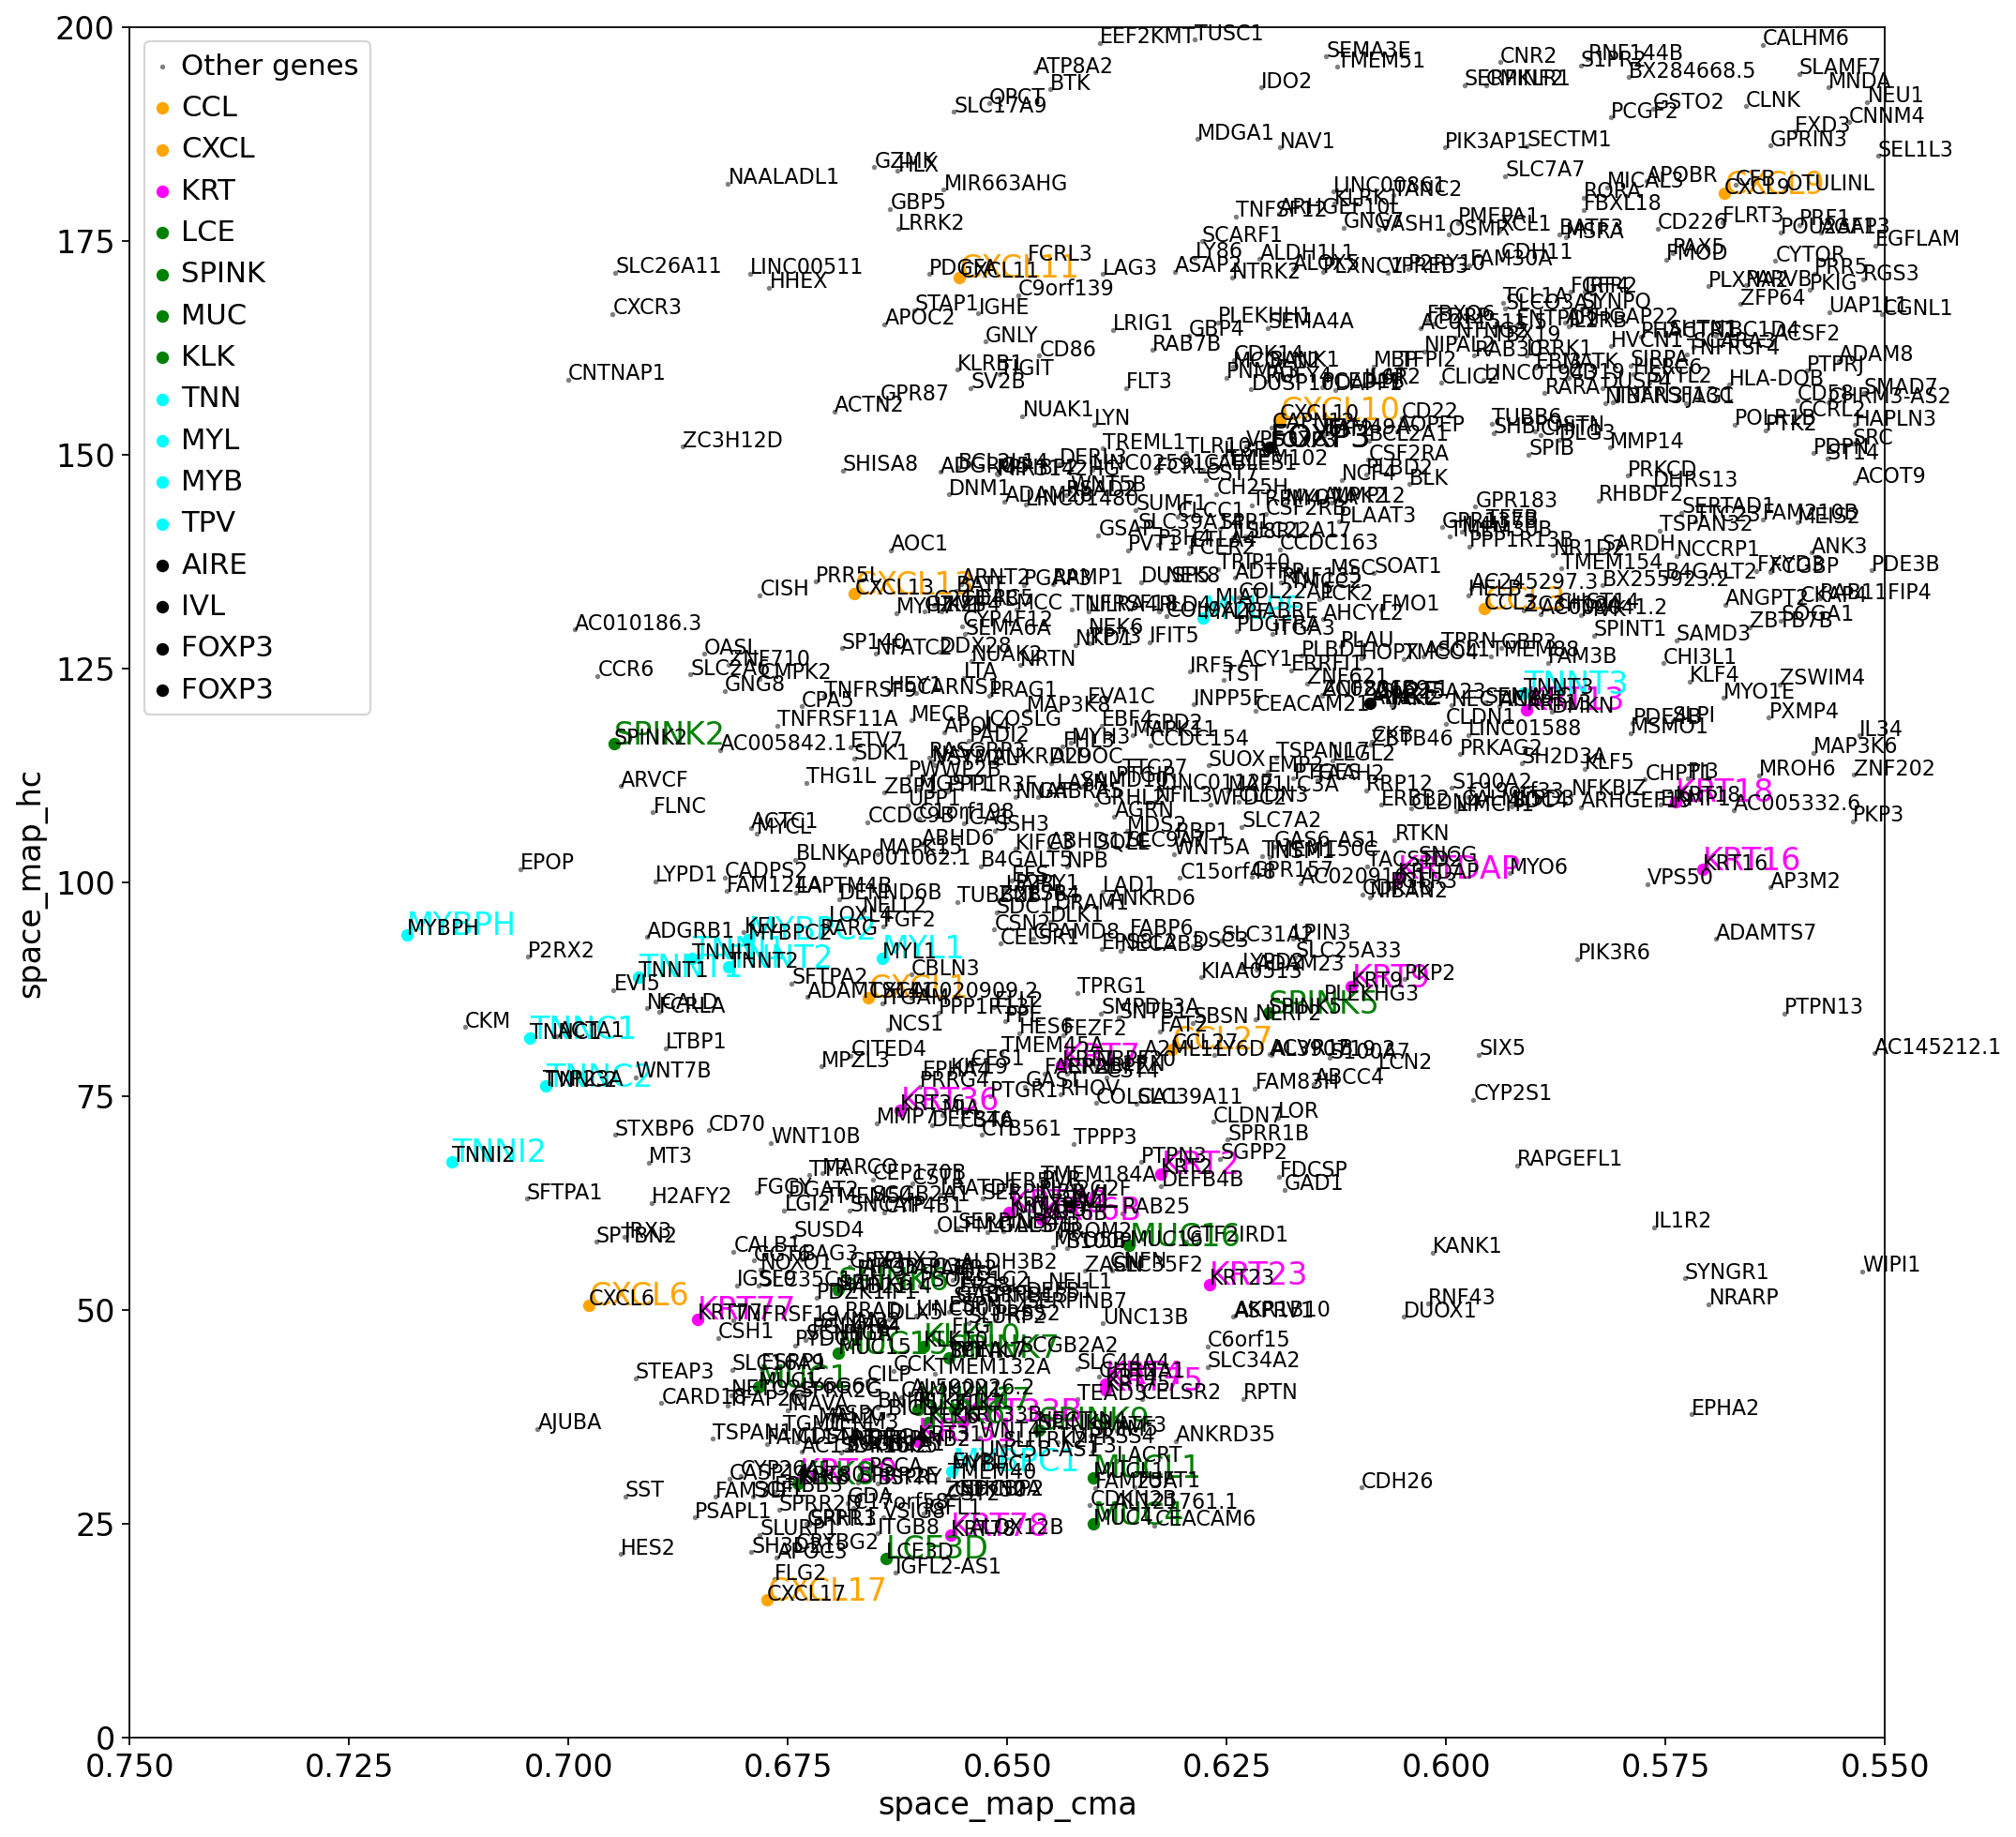

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def annotate_matching_positions(df,search_string, color,anno=True):
    matching_positions = np.where(df.index.str.contains(search_string))[0]
    df_tmp = df.iloc[matching_positions, :]
    plt.scatter(df_tmp['space_map_cma'], df_tmp['space_map_hc'], c=color, label=search_string, s=25)
    for i in matching_positions:
        if anno:
            plt.annotate(df.index[i], (df['space_map_cma'][i], df['space_map_hc'][i]), fontname='Arial', fontsize=15, color=color)

plt.figure(figsize=[15, 15])

cmap = plt.get_cmap('tab20_r')
colors = [cmap(i) for i in range(len(marker_dict_1))]

# Adding unique markers
for key in marker_dict_1.keys():
    df[key+'_unique'] = df.index.isin(marker_dict_1[key])

plt.scatter(df['space_map_cma'], df['space_map_hc'], c='gray', label='Other genes', s=2)
# for idx, key in enumerate(marker_dict_1.keys()):
#     if 'TEC' in key:
#         plt.scatter(df[df[key + '_unique']]['space_map_cma'], df[df[key + '_unique']]['space_map_hc'], c=[colors[idx]], label=key + '_unique', s=50)

# Define strings to search for and corresponding colors
search_strings = ['CCL', 'CXCL', 'KRT', 'LCE', 'SPINK','MUC', 'KLK','TNN','MYL','MYB','TPV','AIRE','IVL','FOXP3','FOXP3','SYT8']
colors = ['orange', 'orange', 'magenta','green', 'green', 'green','green','cyan','cyan','cyan','cyan','black','black','black','black']
# Define strings to search for and corresponding colors
# search_strings = ['KRT','IVL']
# colors = ['green','magenta']

# Use a loop to match partial strings, plot scatter points, and add annotations
for search_string, color in zip(search_strings, colors):
    annotate_matching_positions(df,search_string, color)

# Annotate all the spots with their index values
for i, (x, y) in enumerate(zip(df['space_map_cma'], df['space_map_hc'])):
    plt.annotate(df.index[i], (x, y), fontname='Arial', fontsize=10, color='black')

plt.grid(False)
plt.xlabel('space_map_cma')
plt.ylabel('space_map_hc')
plt.legend()
plt.gca().invert_xaxis()
plt.xlim(0.75, 0.55)
plt.ylim(0, 200)
# 
# plt.savefig('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/figures/scatter_specific_gene_association.pdf', format='pdf')  # Save to PDF
plt.show()


## Load TEC adata

In [29]:
adata_tec = sc.read("../Figure1/annotation_done/TEC_spatlas_scvi_dbrm_2023-07-19.h5ad")

In [30]:
adata_tec_paed = adata_tec[~(adata_tec.obs['age_group'] == 'fetal'),:].copy()
adata_tec_paed_med = adata_tec_paed[adata_tec_paed.obs['annotation_level_3'].isin([ 'mTECI',
       'mTECI-trans', 'mTECII', 'mTECIII', 'TEC-neuro', 'TEC-cilliated',
       'TEC-myo'])]
adata_tec_paed_med

View of AnnData object with n_obs × n_vars = 6945 × 36751
    obs: 'age_group', 'age_numeric', 'annotation_level_0', 'annotation_level_1', 'annotation_level_2', 'annotation_level_3', 'backup_barcode', 'barcode_sequence', 'batch', 'bh_pval', 'c_call_VDJ', 'c_call_VDJ_main', 'c_call_VJ', 'c_call_VJ_main', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'c_call_gdT_VDJ', 'c_call_gdT_VJ', 'cc_phase', 'chain_status', 'chemistry', 'chemistry_simple', 'cite_w_protein', 'clone_id', 'clone_id_by_size', 'cluster_scrublet_score', 'ctp_pred', 'ctp_pred_prob', 'ctp_pred_uncertain', 'd_call_VDJ', 'd_call_VDJ_main', 'd_call_abT_VDJ', 'd_call_abT_VDJ_main', 'donor', 'doublet_score', 'duplicate_count_abT_VDJ', 'duplicate_count_abT_VJ', 'enrichment', 'enzyme', 'g2m_Score', 'good_qc_cluster_mito20', 'has_contig', 'isotype', 'isotype_status', 'j_call_VDJ', 'j_call_VDJ_main', 'j_call_VJ', 'j_call_VJ_main', 'j_call_abT_VDJ', 'j_call_abT_VDJ_main', 'j_call_abT_VJ', 'j_call_abT_VJ_main', 'j_call_gdT_VDJ', 'j_call_gdT_VDJ_

In [31]:
sc.set_figure_params(figsize=[10,10],fontsize=30)
sc.pp.neighbors(adata_tec_paed_med,use_rep='X_scVI')
sc.tl.umap(adata_tec_paed_med)

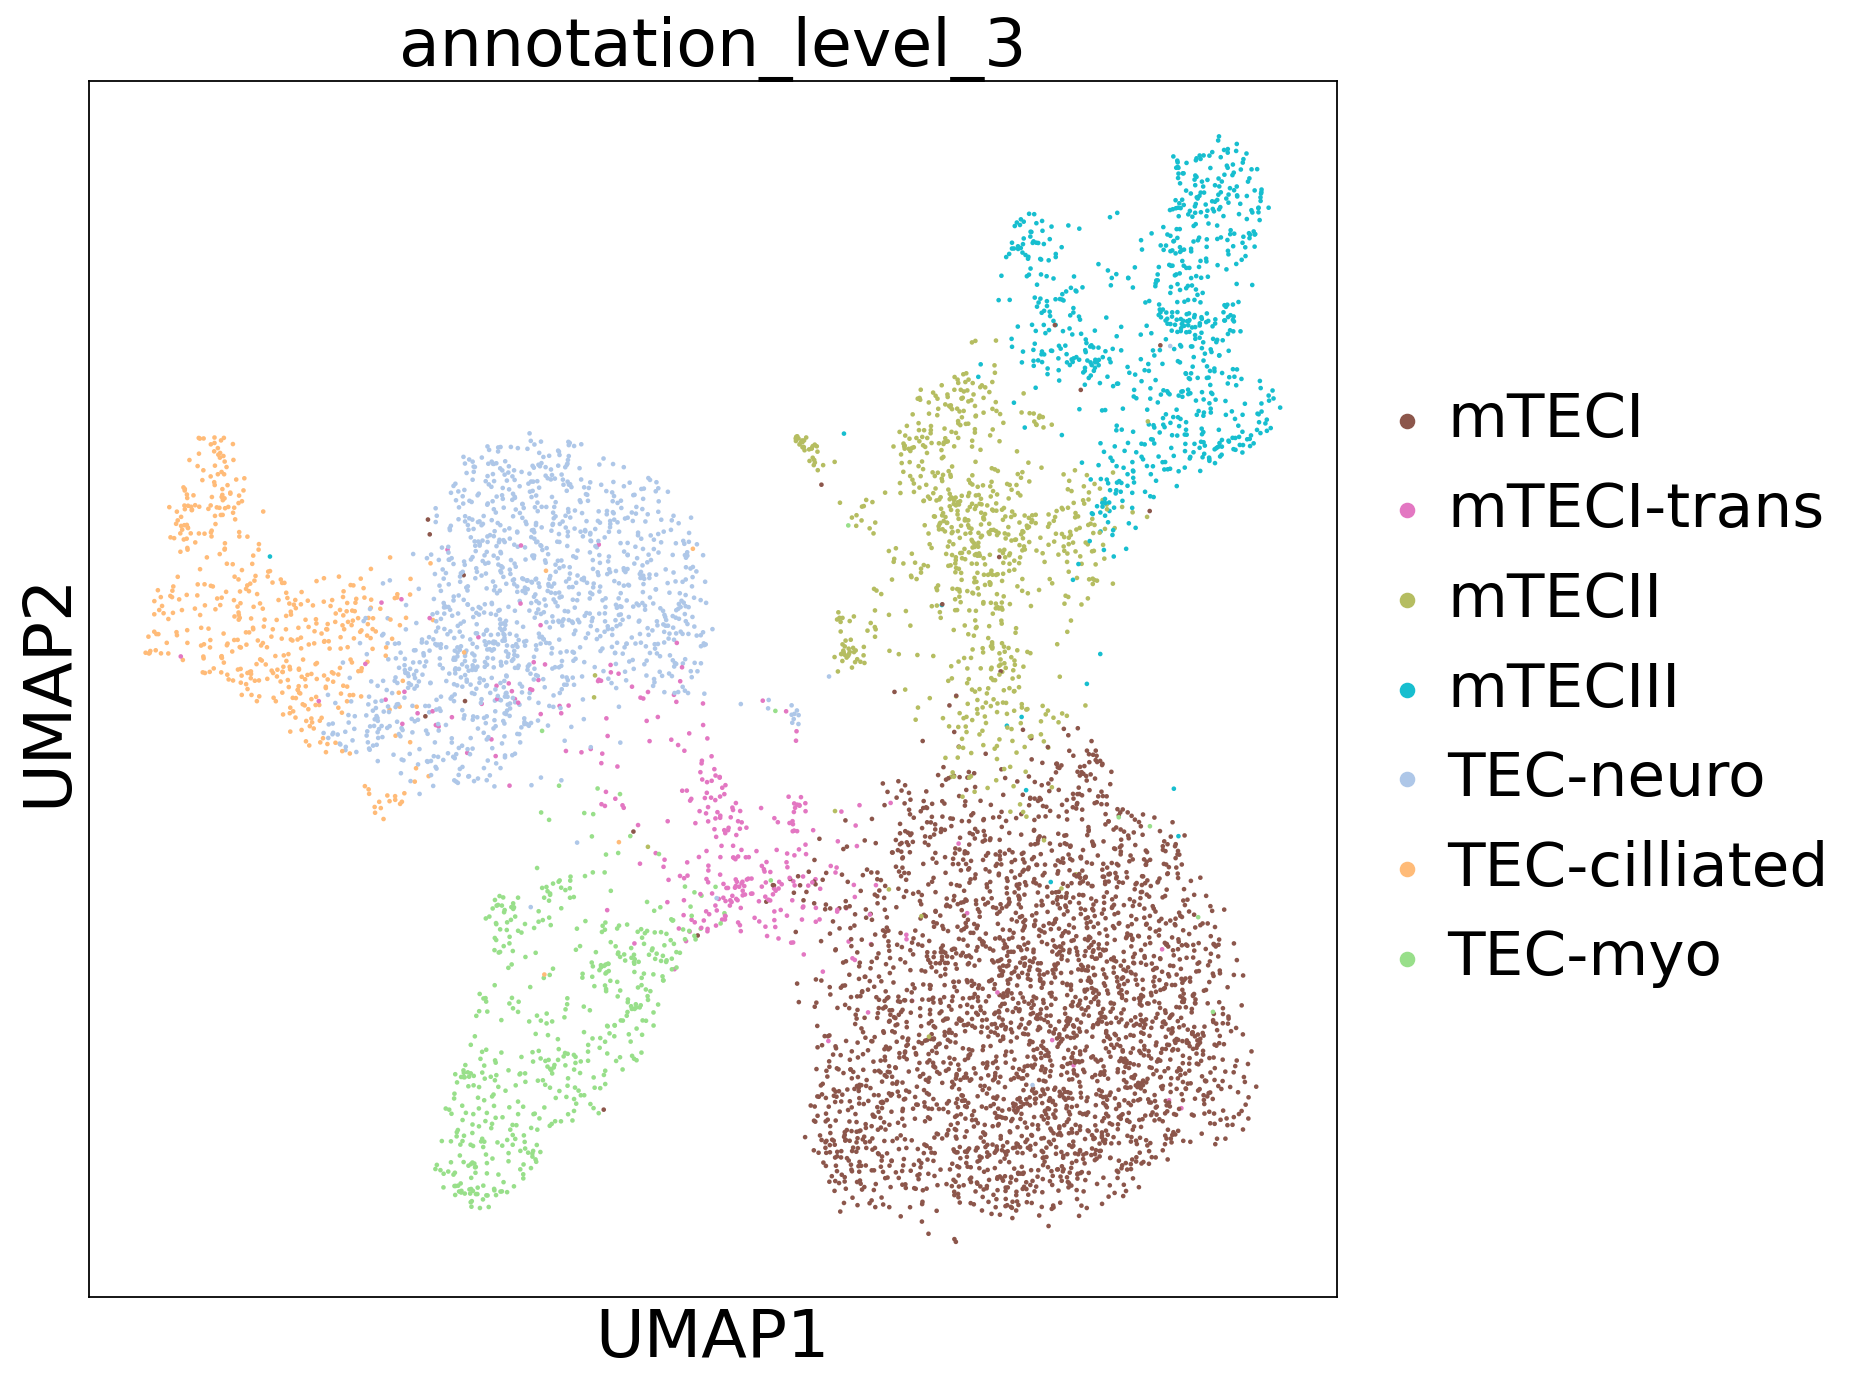

In [32]:
sc.pl.umap(adata_tec_paed_med, color = ['annotation_level_3'],save='_mTEC_HC_fig.pdf')

In [33]:
adata_tec_paed.obs['annotation_level_3'].cat.categories

Index(['cTECI', 'cTECII', 'cTECIII', 'mcTEC', 'mcTEC-Prolif', 'mTECI',
       'mTECI-trans', 'mTECII', 'mTECIII', 'TEC-neuro', 'TEC-cilliated',
       'TEC-myo'],
      dtype='object')

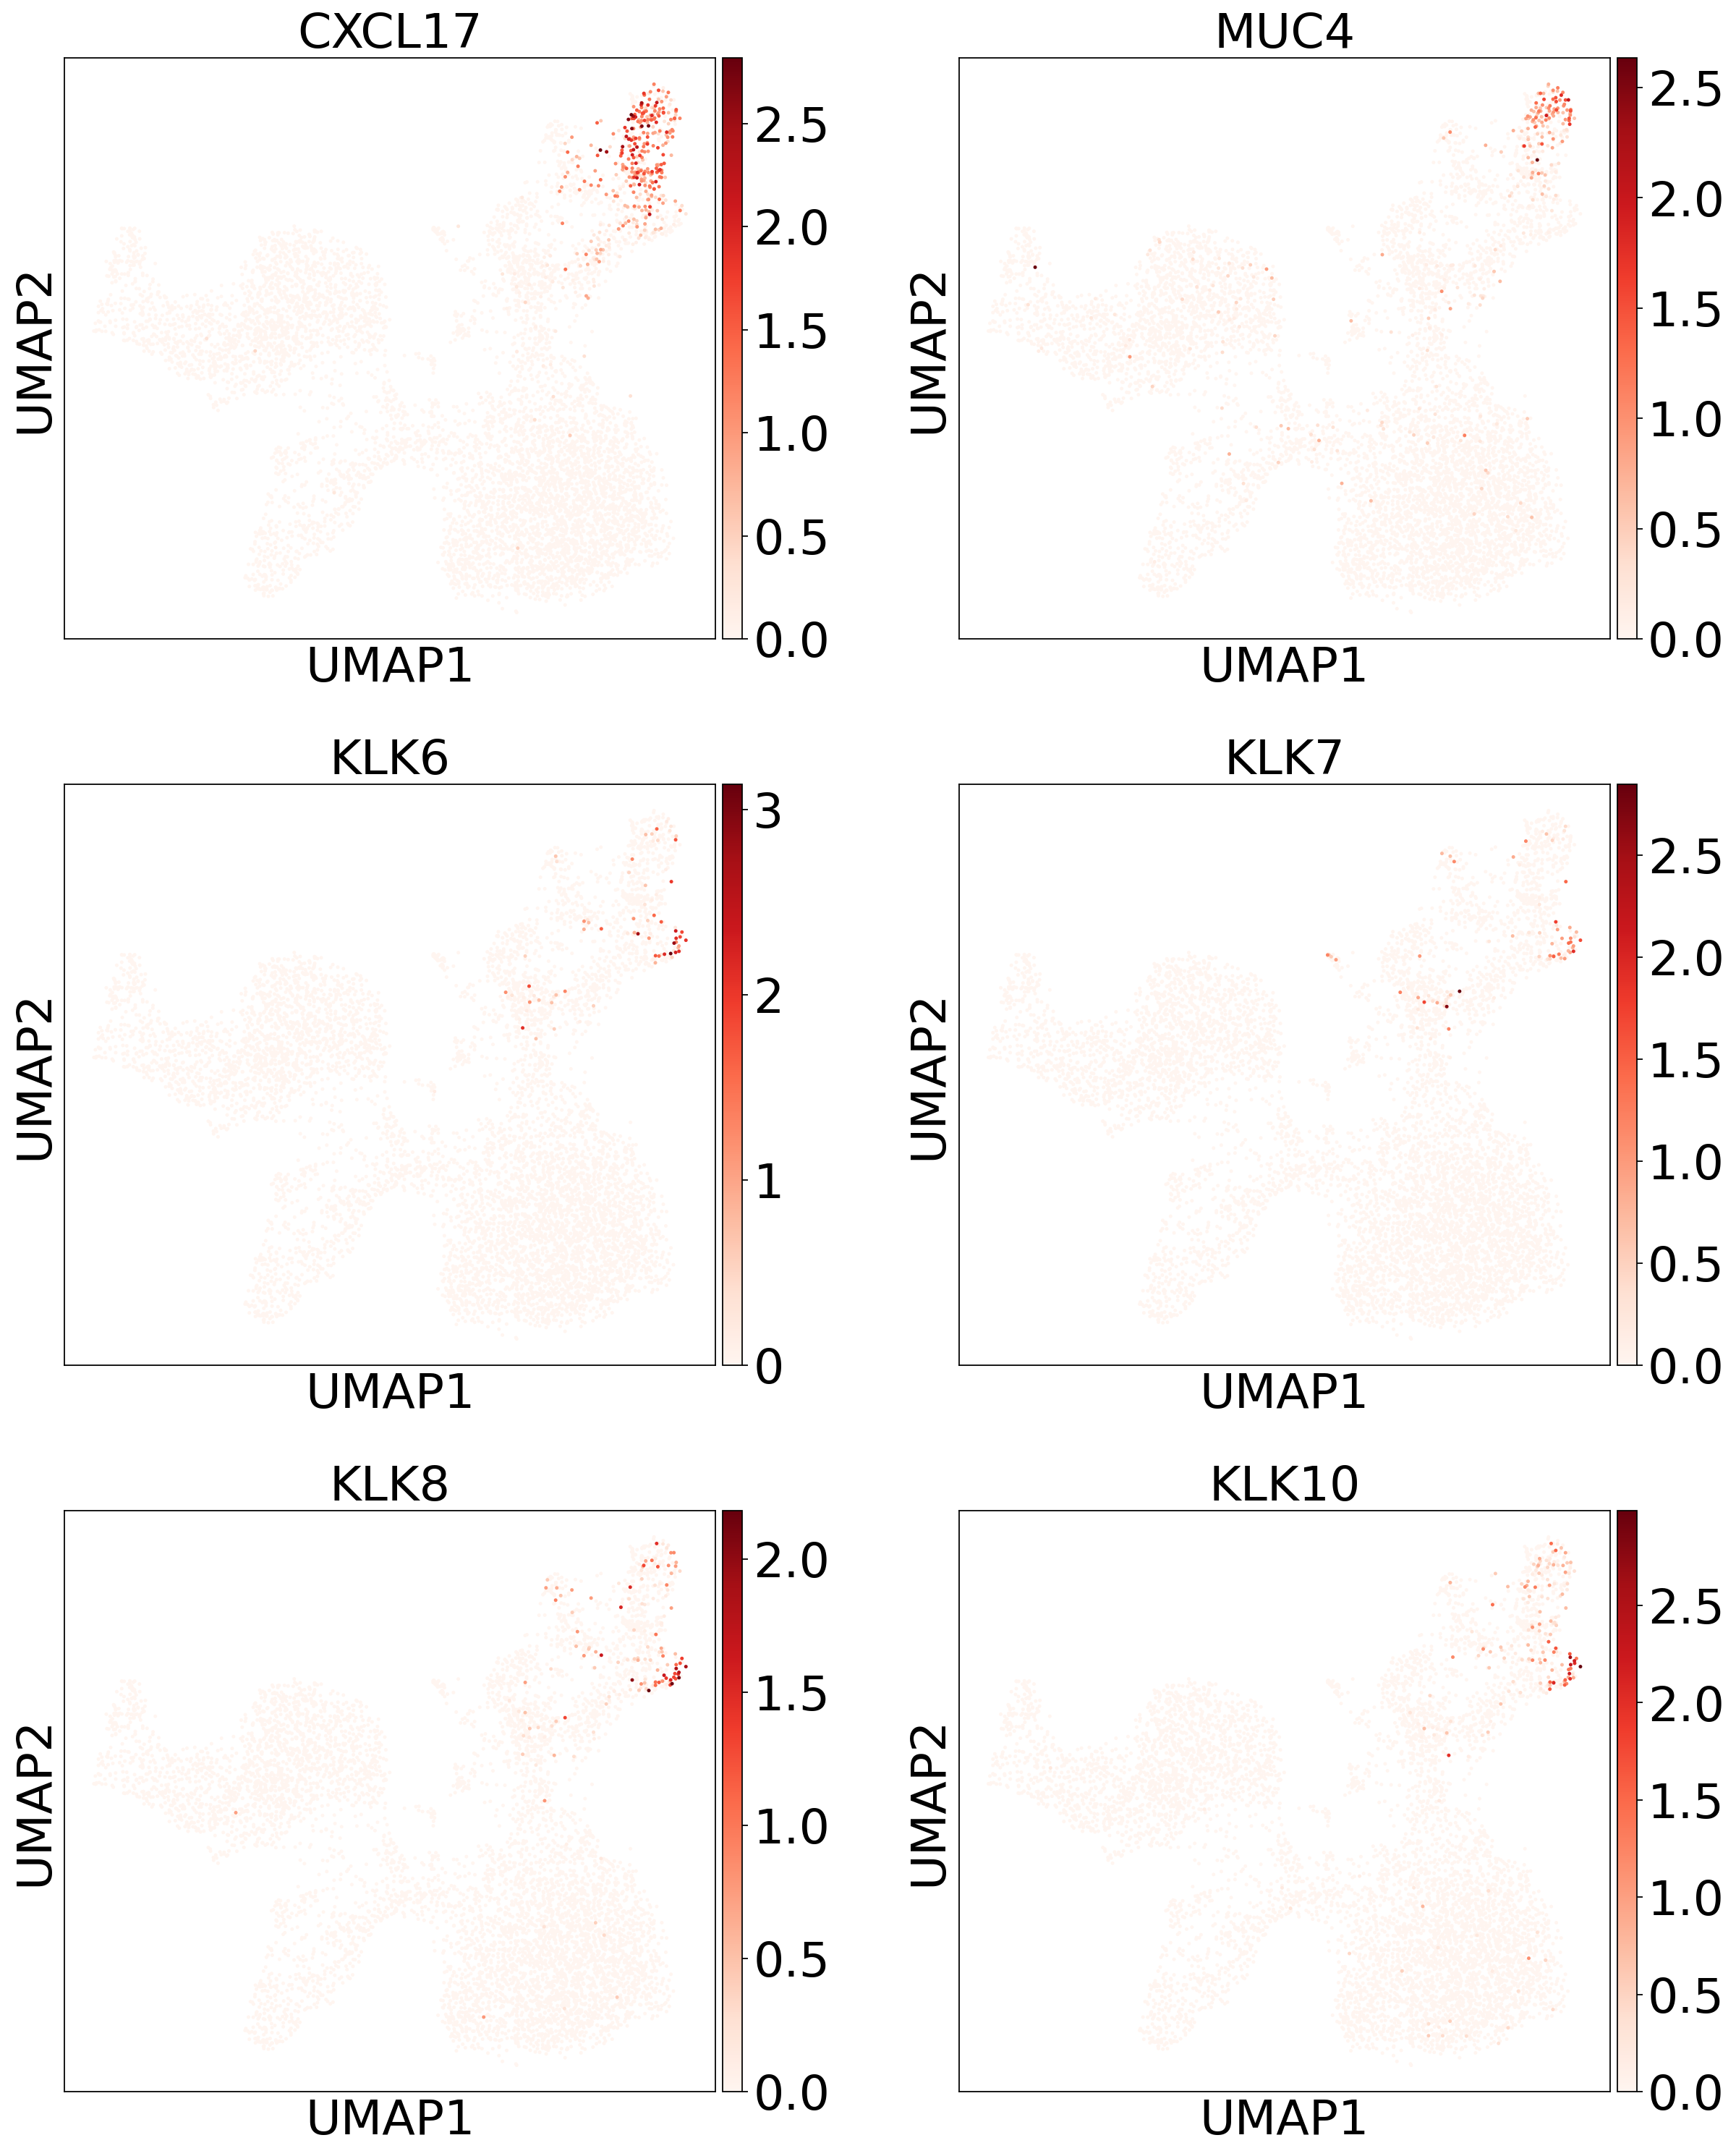

In [34]:
sc.set_figure_params(figsize=[7,7],fontsize=30)
sc.pl.umap(adata_tec_paed_med, color = [ 'CXCL17','MUC4','KLK6','KLK7','KLK8','KLK10'], legend_loc = "on data", legend_fontsize = 30,ncols=2,s=20,wspace=0.25,cmap='Reds',save='_mTECIII_HC_fig.pdf')

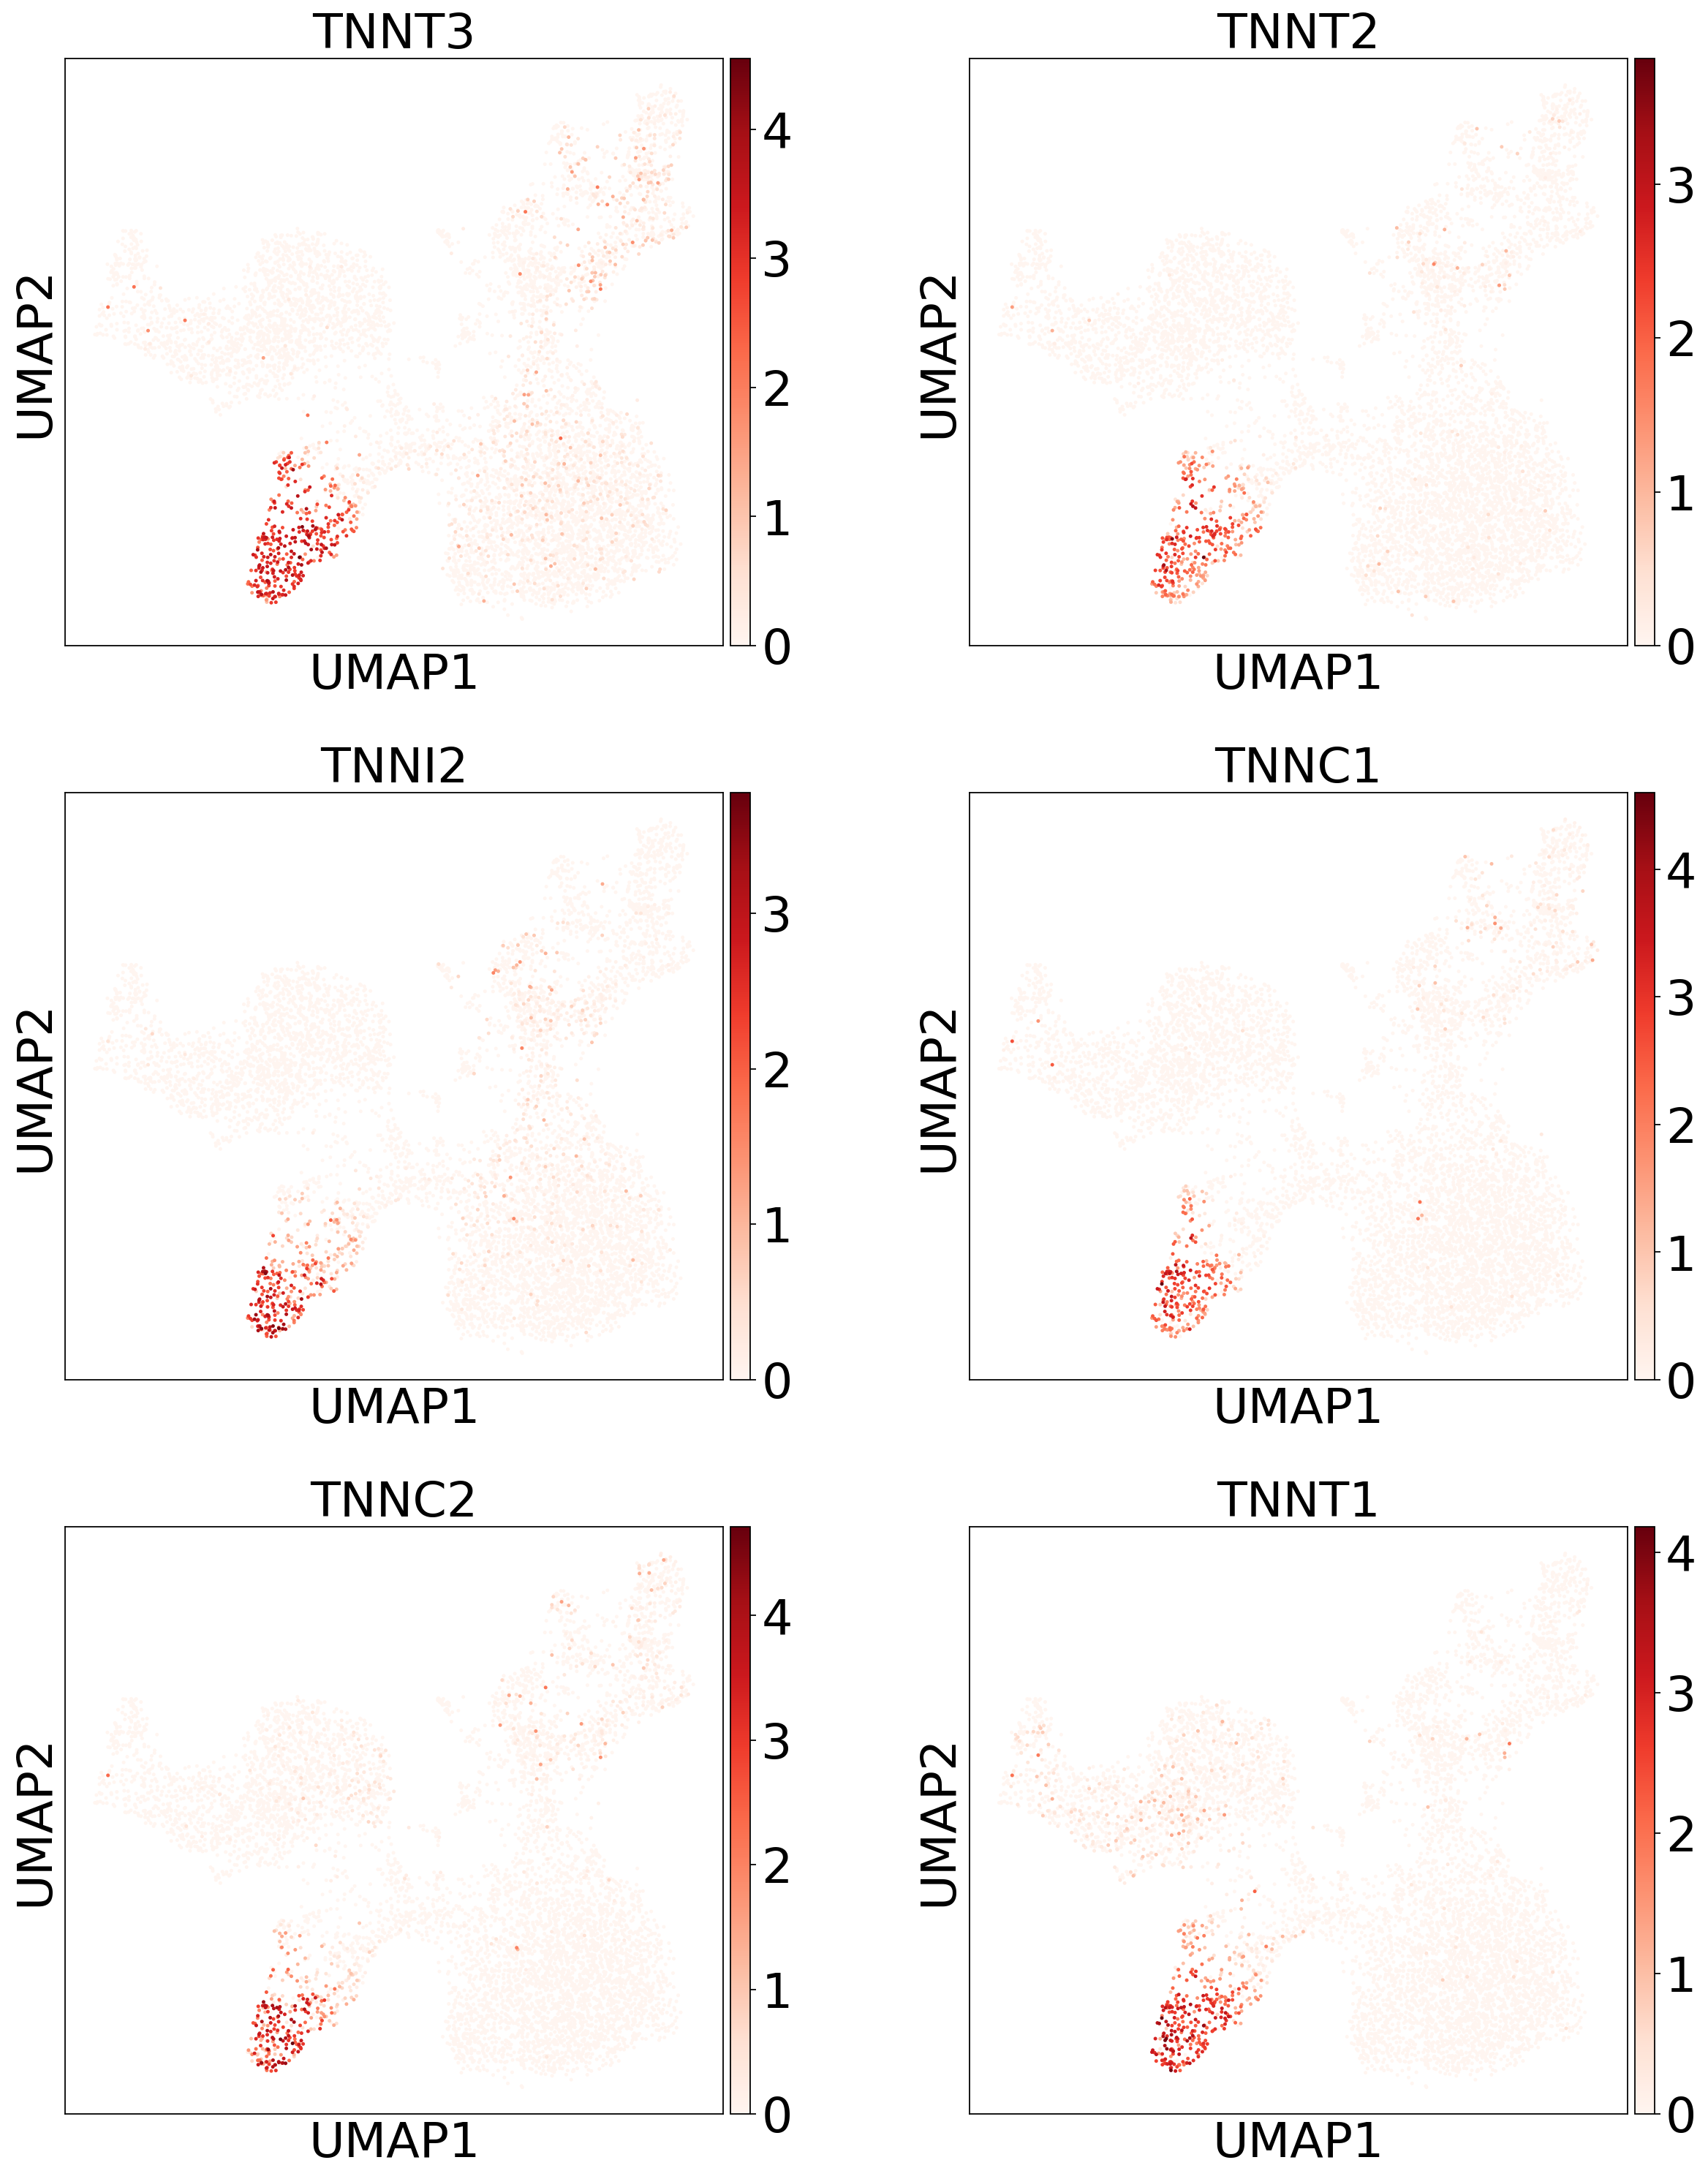

In [35]:
sc.set_figure_params(figsize=[7,7],fontsize=30)
sc.pl.umap(adata_tec_paed_med, color = [ 'TNNT3','TNNT2','TNNI2','TNNC1','TNNC2','TNNT1',], legend_loc = "on data", legend_fontsize = 30,ncols=2,s=20,wspace=0.25,cmap='Reds',save='_myoTEC_HC_fig.pdf')

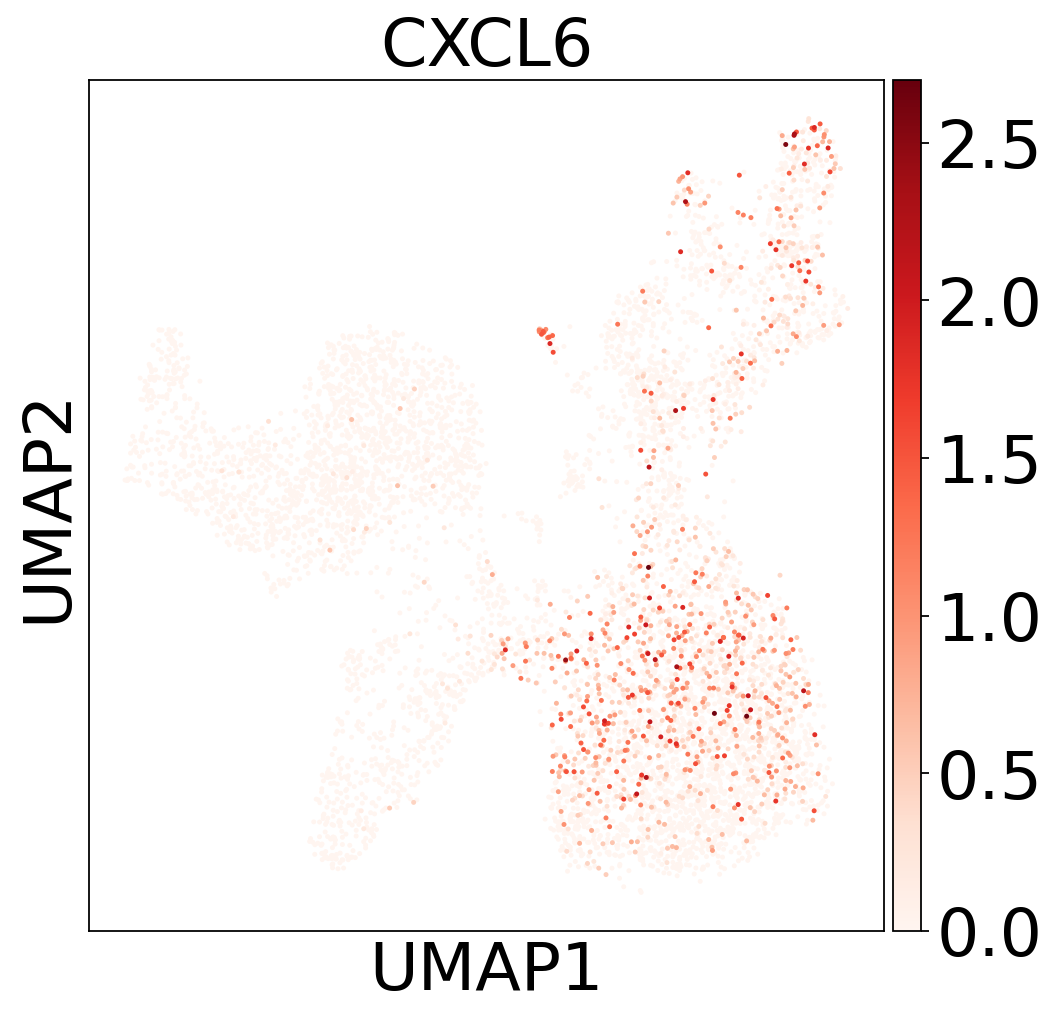

In [40]:
sc.set_figure_params(figsize=[7,7],fontsize=30)
sc.pl.umap(adata_tec_paed_med, color = [ 'CXCL6'], legend_loc = "on data", legend_fontsize = 30,ncols=2,s=20,wspace=0.25,cmap='Reds',save='_myoTEC_HC_fig.pdf')

In [36]:
col = adata_tec_paed.uns['annotation_level_3_colors']
cat = adata_tec_paed.obs['annotation_level_3'].cat.categories

In [37]:
color_dict = {category: color for category, color in zip(cat, col)}
color_dict

{'cTECI': '#1f77b4',
 'cTECII': '#ff7f0e',
 'cTECIII': '#279e68',
 'mcTEC': '#d62728',
 'mcTEC-Prolif': '#aa40fc',
 'mTECI': '#8c564b',
 'mTECI-trans': '#e377c2',
 'mTECII': '#b5bd61',
 'mTECIII': '#17becf',
 'TEC-neuro': '#aec7e8',
 'TEC-cilliated': '#ffbb78',
 'TEC-myo': '#98df8a'}

space_map_cma  space_map_hc  B-memory_unique  DC1_unique  \
AGRN             0.637796    107.629249            False       False   
AL390719.2       0.619878     79.755674            False       False   
TNFRSF18         0.642635    131.810371            False       False   
TNFRSF4          0.572574    161.734681            False       False   
TP73             0.640571    127.909767            False       False   
...                   ...           ...              ...         ...   
SLITRK2          0.650449     34.025981            False       False   
GABRE            0.622722    130.940622            False       False   
PNMA3            0.625008    158.945739            False       False   
CLIC2            0.600574    158.352162            False       False   
AC145212.1       0.551247     79.979523            False       False   

            Macrophage-APOC2_unique  TEC-myo_unique  T_CD8αα(II)_unique  \
AGRN                          False           False               False   
AL390719.2                    False           False               False   
TNFRSF18                      False           False               False   
TNFRSF4                       False           False               False   
TP73                          False           False               False   
...                             ...             ...                 ...   
SLITRK2                       False           False               False   
GABRE                         False           False               False   
PNMA3                         False           False               False   
CLIC2                         False           False               False   
AC145212.1                    False           False               False   

            T_NK_unique  T_Treg_recirc_unique  aDC3_unique  mTECII_unique  \
AGRN              False                 False        False          False   
AL390719.2        False                 False        False          False   
TNFRSF18          False                  True        False          False   
TNFRSF4           False                 False        False          False   
TP73              False                 False        False          False   
...                 ...                   ...          ...            ...   
SLITRK2           False                 False        False          False   
GABRE             False                 False        False          False   
PNMA3             False                 False        False          False   
CLIC2             False                 False        False          False   
AC145212.1        False                 False        False          False   

            mTECIII_unique  pDC_unique  
AGRN                 False       False  
AL390719.2           False       False  
TNFRSF18             False       False  
TNFRSF4              False       False  
TP73                 False       False  
...                    ...         ...  
SLITRK2              False       False  
GABRE                False       False  
PNMA3                False       False  
CLIC2                False       False  
AC145212.1           False       False  

[848 rows x 13 columns]

Text(0.5741813881331658, 173.47771145629076, 'B-memory')

Text(0.5860732624364002, 158.91627052302186, 'B-memory')

Text(0.6050570616730506, 154.2750519493682, 'B-memory')

Text(0.6129030936383744, 202.43247977984313, 'DC1')

Text(0.6130358243600741, 144.3633095937499, 'Macrophage-APOC2')

Text(0.6817775522411504, 90.07065893838092, 'TEC-myo')

Text(0.6859524972275348, 91.01892759855409, 'TEC-myo')

Text(0.7184081172053411, 93.81774457747046, 'TEC-myo')

Text(0.7012512525468032, 81.94460176684274, 'TEC-myo')

Text(0.6642432713410047, 91.08715746736698, 'TEC-myo')

Text(0.7044007662854525, 81.72516123968316, 'TEC-myo')

Text(0.6903650623297757, 108.16703345610843, 'TEC-myo')

Text(0.7132177055306556, 67.29122107315837, 'TEC-myo')

Text(0.5911038617445302, 122.07758039254695, 'TEC-myo')

Text(0.6626649108753487, 131.43182548291975, 'TEC-myo')

Text(0.679192165930096, 106.30693207036319, 'TEC-myo')

Text(0.6276688003886872, 130.8322678328054, 'TEC-myo')

Text(0.6427149377035661, 116.25784636175295, 'TEC-myo')

Text(0.6829536372835423, 46.67149434699925, 'TEC-myo')

Text(0.7118043803847911, 83.03347123579782, 'TEC-myo')

Text(0.6608928467459038, 86.50824675551412, 'TEC-myo')

Text(0.692018924850263, 88.8896784300256, 'TEC-myo')

Text(0.7025984404210903, 76.10590838660899, 'TEC-myo')

Text(0.6159768147922033, 204.3891941096224, 'T_CD8αα(II)')

Text(0.6525273665344419, 163.19155917335965, 'T_NK')

Text(0.6557187270711923, 159.91038707022798, 'T_NK')

Text(0.6426345463502141, 131.81037102194225, 'T_Treg_recirc')

Text(0.5957054374171656, 158.7676066074907, 'T_Treg_recirc')

Text(0.6508800150560003, 159.35563327270918, 'T_Treg_recirc')

Text(0.6391336946482127, 171.0868897355508, 'T_Treg_recirc')

Text(0.6210506862856383, 192.92548731335228, 'aDC3')

Text(0.5821905376551568, 134.67571595792216, 'aDC3')

Text(0.6638293018081112, 20.920533387089534, 'mTECII')

Text(0.6736445883229866, 39.76667696983281, 'mTECII')

Text(0.6710904354103664, 65.94109571258556, 'mTECII')

Text(0.6629979334468769, 42.84611239425876, 'mTECII')

Text(0.6935236132693081, 28.131593143304585, 'mTECII')

Text(0.6189897947014951, 65.51774357149709, 'mTECII')

Text(0.6359867264760152, 93.81222415947661, 'mTECII')

Text(0.6324532542841171, 64.42986672054282, 'mTECII')

Text(0.6585523645103971, 71.49735598179905, 'mTECII')

Text(0.674544749335663, 88.13375223783775, 'mTECII')

Text(0.7047668451218749, 62.96436954599161, 'mTECII')

Text(0.6485422648206471, 45.02659881964357, 'mTECII')

Text(0.668334883597085, 33.580863960181205, 'mTECII')

Text(0.6648861447796361, 71.81131690526806, 'mTECII')

Text(0.6762571453897929, 20.982191518912604, 'mTECII')

Text(0.6375020550389938, 32.28258285790517, 'mTECII')

Text(0.6908385577098638, 67.20753156867588, 'mTECII')

Text(0.6479610768280339, 76.06795353424987, 'mTECII')

Text(0.6565304225146065, 44.54978467346742, 'mTECII')

Text(0.6431614491516516, 101.76098678411758, 'mTECII')

Text(0.6726024380820547, 65.69223193537785, 'mTECII')

Text(0.6840392290417302, 70.96371516378855, 'mTECII')

Text(0.6574039358650744, 72.78416454340773, 'mTECII')

Text(0.638669709065759, 77.1841502218046, 'mTECII')

Text(0.6608099559008642, 64.70225914519223, 'mTECII')

Text(0.6569050289756051, 27.705534845289055, 'mTECII')

Text(0.6086220689619088, 120.88234844941245, 'mTECII')

Text(0.6464350805493516, 63.37454082423691, 'mTECIII')

Text(0.6640602917913592, 61.38228177622945, 'mTECIII')

Text(0.6716818295570157, 51.337771229008204, 'mTECIII')

Text(0.6230821713939693, 39.56990002973886, 'mTECIII')

Text(0.6562916883111064, 47.29805075177792, 'mTECIII')

Text(0.6764816306830573, 18.431105855266374, 'mTECIII')

Text(0.6427465697870929, 62.00098006217565, 'mTECIII')

Text(0.6725150509227428, 24.820133127970177, 'mTECIII')

Text(0.6249133253108724, 69.86918751516386, 'mTECIII')

Text(0.6760137598533343, 26.57864785572218, 'mTECIII')

Text(0.6669563367165356, 29.806642885666864, 'mTECIII')

Text(0.6191976939574603, 72.43889069183713, 'mTECIII')

Text(0.6132380261442054, 79.40467854156802, 'mTECIII')

Text(0.6465659043956272, 36.25940617203859, 'mTECIII')

Text(0.6686426018723327, 46.54006187282647, 'mTECIII')

Text(0.6512210629052269, 96.38919438814695, 'mTECIII')

Text(0.6695360445917975, 51.95493775491459, 'mTECIII')

Text(0.6567006297514268, 30.259092883315915, 'mTECIII')

Text(0.6832673895087941, 28.08083208916675, 'mTECIII')

Text(0.6401995035340172, 24.944287534873872, 'mTECIII')

Text(0.6432187077565887, 57.18665219449494, 'mTECIII')

Text(0.6734619867823464, 33.375029282140304, 'mTECIII')

Text(0.6202550882530141, 84.67714000220924, 'mTECIII')

Text(0.6566837613170367, 44.35828516538401, 'mTECIII')

Text(0.6464304558600695, 35.941071906574415, 'mTECIII')

Text(0.6558430811605913, 50.96261603303554, 'mTECIII')

Text(0.6271694018534708, 45.69791051546259, 'mTECIII')

Text(0.6739278120104731, 34.44045903582425, 'mTECIII')

Text(0.6599469669067477, 52.767658410843666, 'mTECIII')

Text(0.6734410817960517, 40.20492905177443, 'mTECIII')

Text(0.668980262918029, 33.31379093217532, 'mTECIII')

Text(0.6715600457002993, 36.78484969705207, 'mTECIII')

Text(0.665759368361999, 30.963339476803544, 'mTECIII')

Text(0.6232506507264856, 89.96136042218335, 'mTECIII')

Text(0.6544433559241174, 48.41547742191334, 'mTECIII')

Text(0.6263617044788754, 79.76047042175469, 'mTECIII')

Text(0.6405657282700439, 27.10184985123637, 'mTECIII')

Text(0.6076882506904688, 78.13775939863586, 'mTECIII')

Text(0.5982707455830902, 108.94261074170558, 'mTECIII')

Text(0.681349436294698, 42.9876069574286, 'mTECIII')

Text(0.6400144933952132, 29.117865898134323, 'mTECIII')

Text(0.6554064748339363, 71.42449427290778, 'mTECIII')

Text(0.6553643562187937, 54.8784628563265, 'mTECIII')

Text(0.689405700150085, 39.06718278235209, 'mTECIII')

Text(0.6344453492651169, 79.69973801857346, 'mTECIII')

Text(0.6736414595850967, 29.914071485181683, 'mTECIII')

Text(0.6388466442069203, 40.610383861435025, 'mTECIII')

Text(0.6460769663519842, 60.56575134745627, 'mTECIII')

Text(0.6852882911331546, 48.89702915827143, 'mTECIII')

Text(0.6388226089883169, 41.33189763458591, 'mTECIII')

Text(0.6497670191850142, 61.392813147266025, 'mTECIII')

Text(0.6564476047217557, 23.60849349629623, 'mTECIII')

Text(0.6789532468171516, 28.180015076350443, 'mTECIII')

Text(0.6700086235861358, 37.11009883041309, 'mTECIII')

Text(0.6742092992010493, 45.825648324256285, 'mTECIII')

Text(0.6269649614681935, 52.94065973709035, 'mTECIII')

Text(0.6405134591585663, 35.266347226587335, 'mTECIII')

Text(0.6561686668665642, 50.87624756993556, 'mTECIII')

Text(0.65563988699052, 59.49713229019905, 'mTECIII')

Text(0.6528044268783134, 62.962920675109466, 'mTECIII')

Text(0.6479855401037542, 50.26991151652105, 'mTECIII')

Text(0.6657731794873365, 34.08354232128487, 'mTECIII')

Text(0.6816392553174344, 30.18321040072383, 'mTECIII')

Text(0.6054443141672626, 100.42227129022278, 'mTECIII')

Text(0.5975034994483923, 109.87797265745218, 'mTECIII')

Text(0.6332128389393482, 24.744352849119284, 'mTECIII')

Text(0.6774035642339545, 16.02828868160084, 'mTECIII')

Text(0.6627203459603626, 19.24123695769594, 'mTECIII')

Text(0.659003760518755, 36.77478066962509, 'mTECIII')

Text(0.6559996209079055, 38.30217292647183, 'mTECIII')

Text(0.673856473375594, 29.61860723434776, 'mTECIII')

Text(0.6595330734328658, 45.72697543877867, 'mTECIII')

Text(0.6378385078269194, 26.775145918700133, 'mTECIII')

Text(0.5724645208241392, 112.1746274104614, 'mTECIII')

Text(0.5742148989512359, 118.80106952011566, 'mTECIII')

Text(0.6664994140109628, 54.30351821792431, 'mTECIII')

Text(0.6326892708526635, 131.68728358044783, 'pDC')

Text(0.6407197691605212, 131.6444089997222, 'pDC')

Text(0.5, 0, 'space_map_cma')

Text(0, 0.5, 'space_map_hc')

(0.75, 0.55)

(0.0, 250.0)

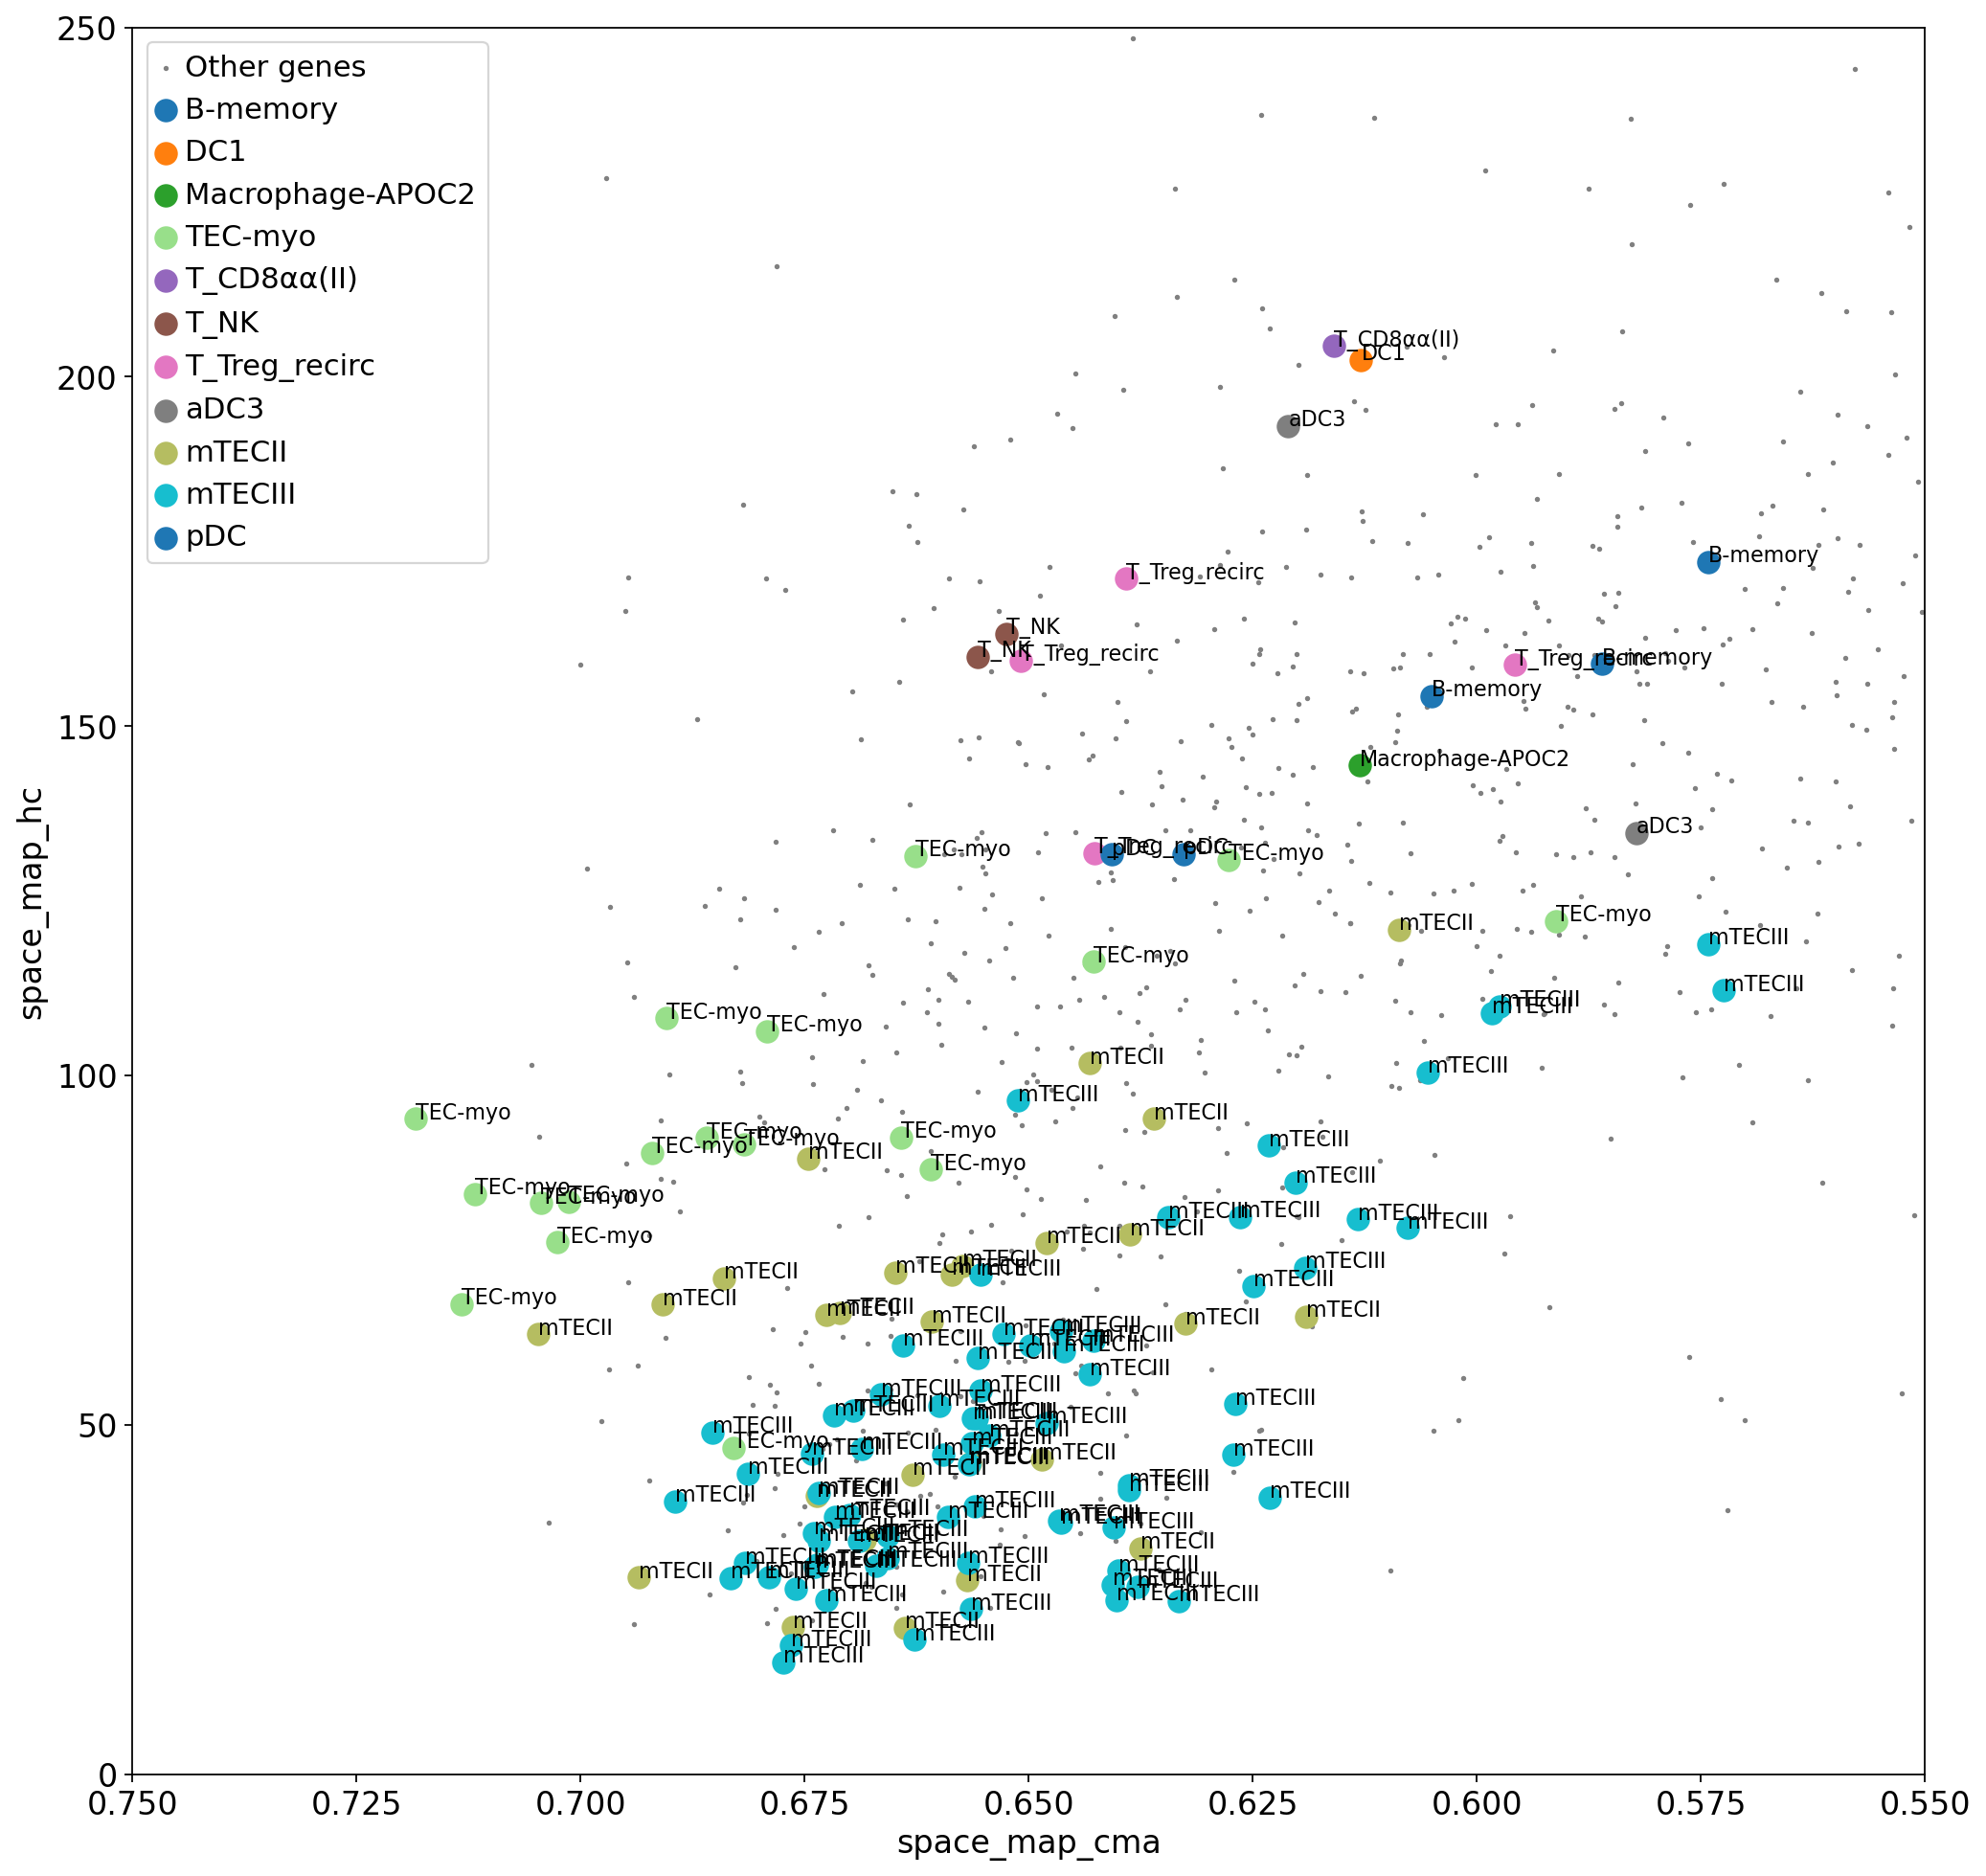

In [38]:
import matplotlib.pyplot as plt
sc.set_figure_params(figsize=[15,15],fontsize=15)
cmap = plt.get_cmap('tab20')
cell_spots = {}
for key in marker_dict_1.keys():
    df[key+'_unique'] = df.index.isin(marker_dict_1[key])
df

colors = sns.color_palette('tab10', 20)
# cmap = ListedColormap(colors)

plt.scatter(df['space_map_cma'], df['space_map_hc'], c='gray', label='Other genes', s=2)
for idx, key in enumerate(marker_dict_1.keys()):
    if 'TEC' in key:
        plt.scatter(df[df[key + '_unique']]['space_map_cma'], df[df[key + '_unique']]['space_map_hc'], c=color_dict[key], label=key, s=100)
        filtered_df = df[df[key + '_unique']]
        for _, row in filtered_df.iterrows():
            plt.annotate(
                key, 
                (row['space_map_cma'], row['space_map_hc']), 
                fontname='Arial', 
                fontsize=10, 
                color='black'
            )
    if 'TEC' not in key:
        plt.scatter(df[df[key + '_unique']]['space_map_cma'], df[df[key + '_unique']]['space_map_hc'],  c=[colors[idx]], label=key, s=100)
        filtered_df = df[df[key + '_unique']]
        for _, row in filtered_df.iterrows():
            plt.annotate(
                key, 
                (row['space_map_cma'], row['space_map_hc']), 
                fontname='Arial', 
                fontsize=10, 
                color='black'
            )


        
plt.grid(False)

# add axis labels
plt.xlabel('space_map_cma')
plt.ylabel('space_map_hc')

plt.legend()
plt.gca().invert_xaxis()

# Set axis limits
plt.xlim(0.75, 0.55) # Since you're inverting the x-axis, the limits are given in reverse order
plt.ylim(0, 250)

plt.savefig('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/figures/HC_CMA_association_genes_all.pdf')
plt.show()


<AxesSubplot:ylabel='Frequency'>

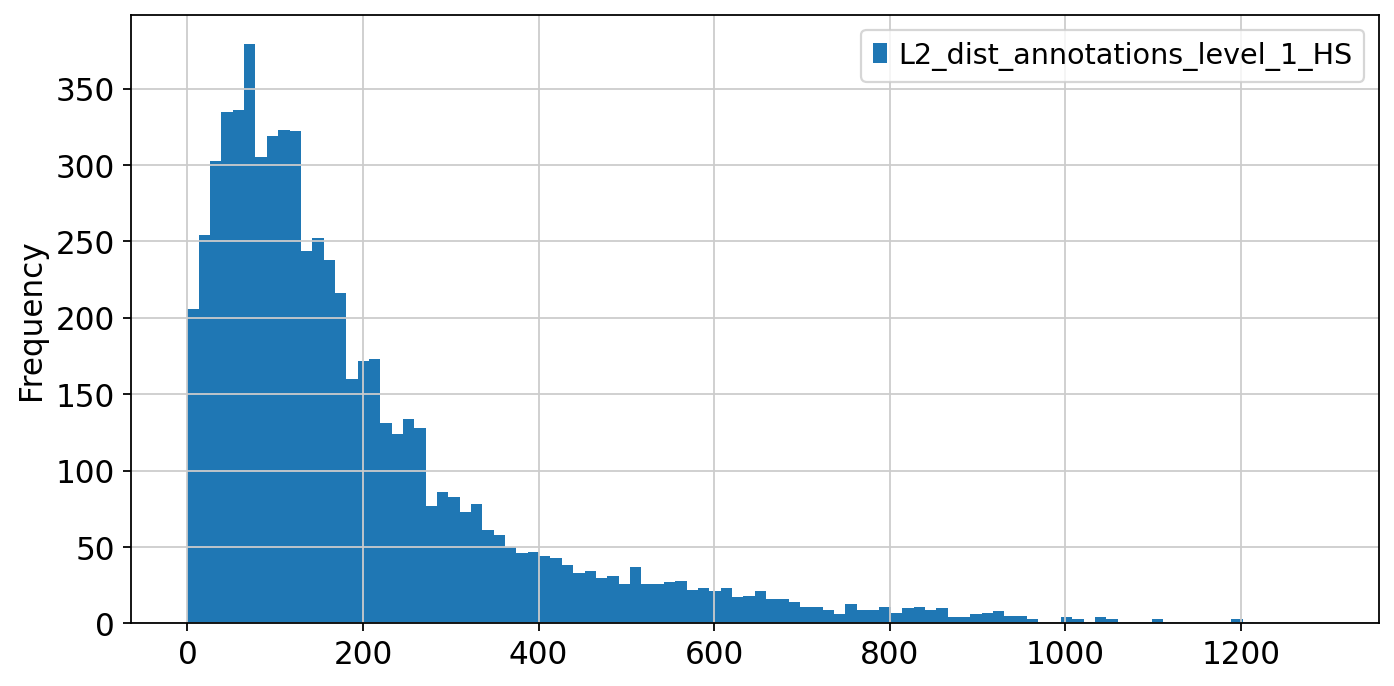

In [576]:
# plot HC distance in the medulla 
sc.set_figure_params(figsize=[10,5])
pd.DataFrame(adata_scvi[adata_scvi.obs.annotations_level_0=='Medulla'].obs['L2_dist_annotations_level_1_HS']*2).plot.hist(bins=100)
plt.savefig('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/figures/HC_hist_medulla.pdf')


# load annotated object 

In [222]:
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'pdf')

adata = sc.read('/nfs/team205/ny1/ThymusSpatialAtlas/Figure1/annotation_done/HTSA_mTECII_III_annot_traj2_2023-09-13.h5ad')

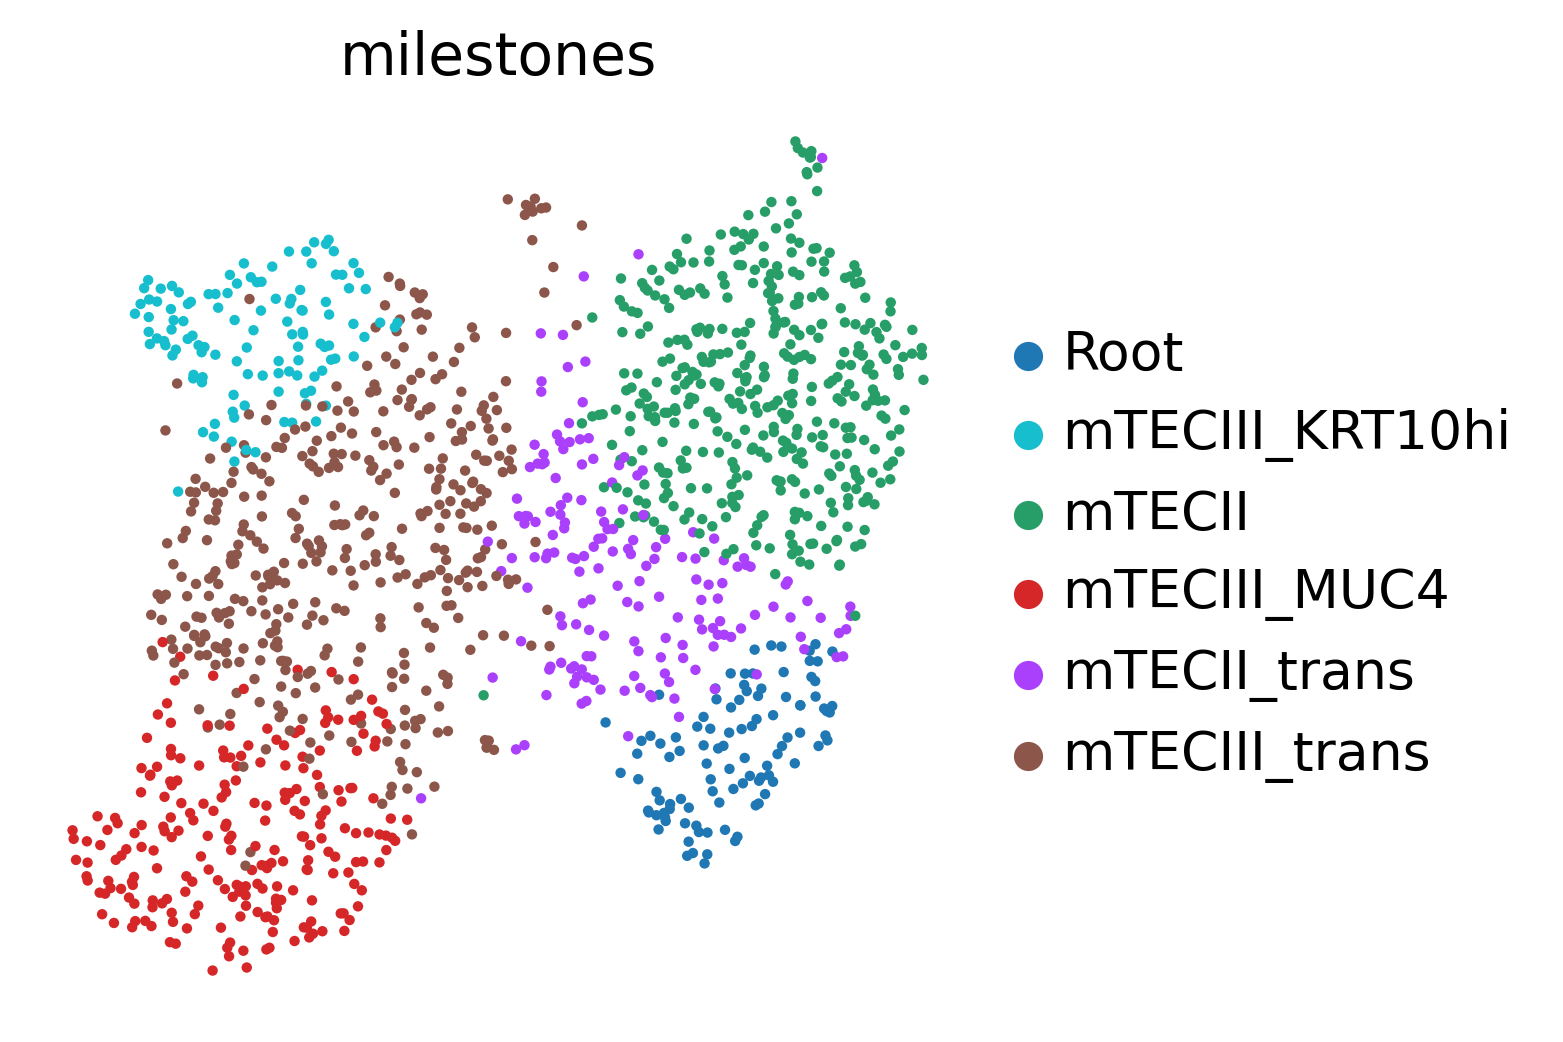

barcode
GSM4466783-TGCGGGTGTTTCGGCG    mTECIII_MUC4
GSM4466783-GTCACTCTCTGCGATA    mTECIII_MUC4
GSM4466783-GTCTAGAAGTGGTTCT    mTECIII_MUC4
GSM4466783-CTTGATTCAGCGAACA    mTECIII_MUC4
GSM4466783-CCTCCTCCAATACCTG    mTECIII_MUC4
                                   ...     
TA13072427-CTCGTCATCCGCAGTG    mTECIII_MUC4
TA13072427-CTGATCCAGTACGCCC          mTECII
TA13072427-TGAGCCGTCCTCAACC          mTECII
TA13072427-GCACATACAGCGTTCG          mTECII
TA13072427-GTAACGTGTCGAAAGC          mTECII
Name: milestones, Length: 1445, dtype: category
Categories (6, object): ['Root', 'mTECIII_KRT10hi', 'mTECII', 'mTECIII_MUC4', 'mTECII_trans', 'mTECIII_trans']

In [228]:
sc.pl.umap(adata, color = ['milestones'],save='_mTEC_HC_krt.pdf',frameon=False,s=25)
adata.obs['milestones']

['FLG', 'SERPINB13', 'SLURP2', 'KLK7', 'KLK8', 'SPINK7', 'SDR16C5', 'KLK6', 'PSORS1C2', 'KLK10', 'PDZK1IP1', 'S100P', 'FLG2', 'CDSN', 'LY6D', 'TMEM40', 'KRT77', 'PLA2G2F', 'SLC16A9', 'SPRR1B', 'SPINK9', 'KRT79', 'KRTDAP', 'CASP14', 'LOR', 'CARD18', 'S100A7', 'FAM25A', 'AC113410.2', 'ALDH3B2', 'CDKN2B', 'KRT6B', 'LY6G6C', 'SERPINB3', 'SERPINB4', 'KRT10', 'CALML5', 'PYDC1', 'SDC1', 'GABRP', 'NECTIN4', 'IGFL2-AS1', 'PIGR', 'SLPI', 'UPK1B', 'CXCL17', 'PSCA', 'CEACAM6', 'FAM3D', 'KRT4', 'MAB21L4', 'MUC4', 'ASPG', 'APOBEC3A', 'A2ML1', 'C19orf33', 'MAL2', 'SMIM5', 'KRT23', 'SPINK5', 'KRT78', 'IVL', 'CST6', 'CYP4B1', 'LCN2', 'SPRR3', 'AL121761.1', 'SPRR2D', 'SCEL', 'SERPINB7', 'LYPD2', 'KRT80', 'PI3', 'SERPINB2', 'RPTN', 'C6orf15']


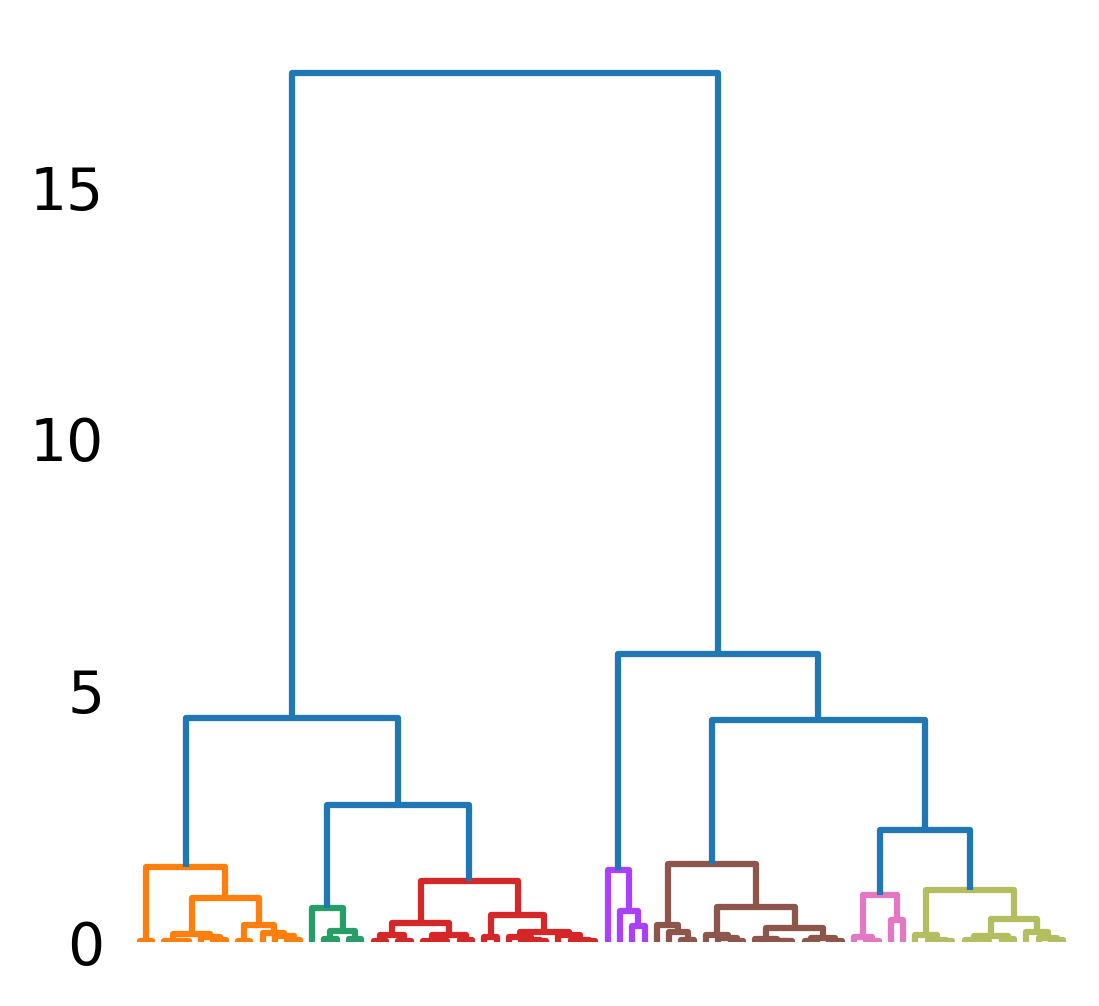

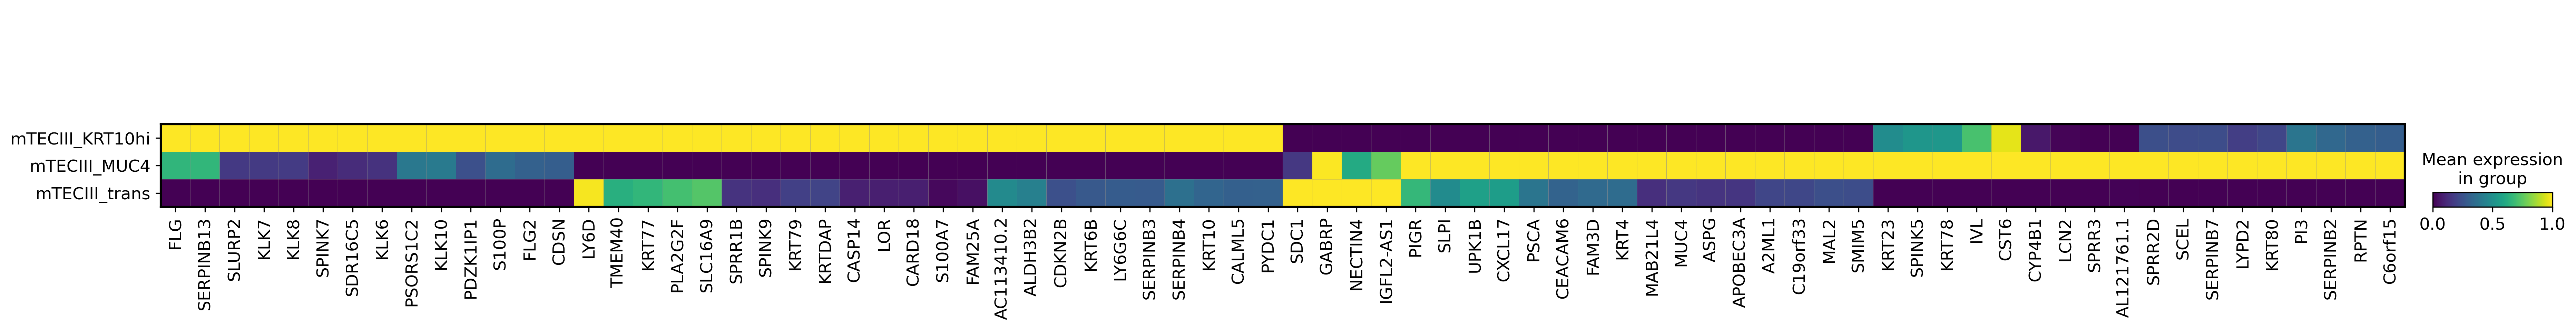

In [230]:
# cluster cytokies by expression profiles across bins
from sklearn.preprocessing import scale
from scipy.cluster.hierarchy import linkage, dendrogram
genes = marker_dict_1['mTECIII'] 
cells = ['mTECIII_KRT10hi', 'mTECIII_MUC4', 'mTECIII_trans']
groupby = 'milestones'
## For correct plotting of the images
import matplotlib
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')


# Subset dataframe, calculate mean expression and standardize
adata_selected = adata[:, adata.var_names.isin(genes)]
adata_selected = adata_selected[adata_selected.obs[groupby].isin(cells),:]

mean_expression_df = pd.DataFrame(adata_selected.X.toarray(), 
                                  columns=adata_selected.var_names, 
                                  index=adata_selected.obs_names).groupby(adata_selected.obs[groupby]).mean()
mean_expression_std = pd.DataFrame(scale(mean_expression_df, axis=0),
                                   index=mean_expression_df.index,
                                   columns=mean_expression_df.columns)

# Create dendrogram
transposed_df = mean_expression_std.transpose()
Z = linkage(transposed_df, method='ward')
dn = dendrogram(Z, orientation='top', labels=transposed_df.index, leaf_font_size=5,p=10,color_threshold=2)

# Set plotting preferences
plt.grid(False)
plt.rcParams['figure.facecolor'] = 'white'
for spine in plt.gca().spines.values(): spine.set_visible(False)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=False)

# Get and print gene order
gene_order = [transposed_df.index[i] for i in dn['leaves']]
print(gene_order)

# Save the dendrogram figure as a PDF
plt.savefig('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/figures/dendrogram_mTECIII.pdf')

plt.show()

# Create matrix plot using scanpy
# sc.pl.matrixplot(adata_tec_paed_med,var_names=gene_order,groupby=groupby,cmap='viridis',standard_scale='var',dendrogram=False)

fig = sc.pl.matrixplot(adata_selected,var_names=gene_order,groupby=groupby,cmap='viridis',standard_scale='var',dendrogram=False,save='matrixplot_mTECIII.pdf')
# plt.savefig('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/figures/matrixplot_mTECIII.pdf')



['NPB', 'CST4', 'SCGB1A1', 'MT3', 'GAST', 'MARCO', 'AIRE', 'SFTPA1', 'PYY', 'SFTPA2', 'MMP7', 'CCK', 'APOC3', 'FDCSP', 'CD70', 'DEFB4B', 'TTR', 'CST1', 'CST2', 'SST', 'MIA', 'FABP6', 'DEFB4A']


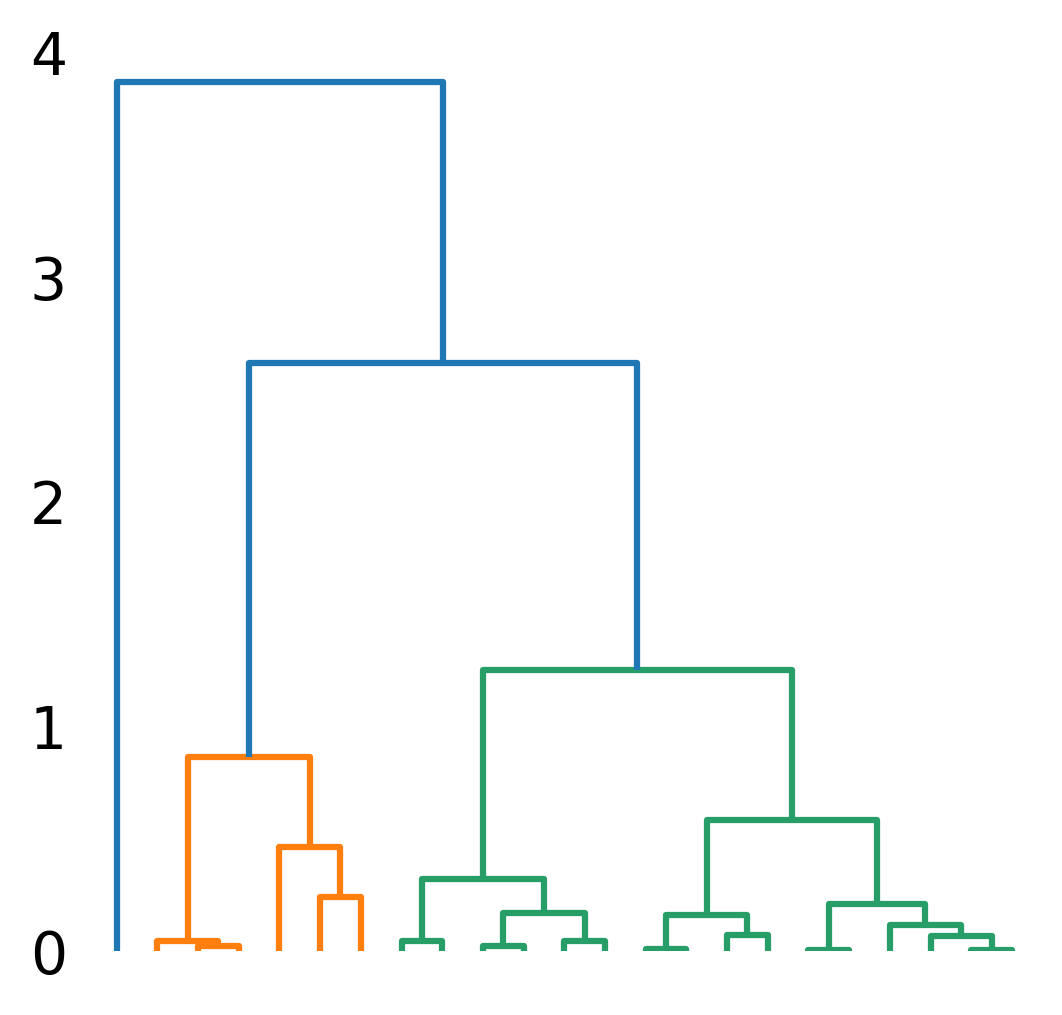

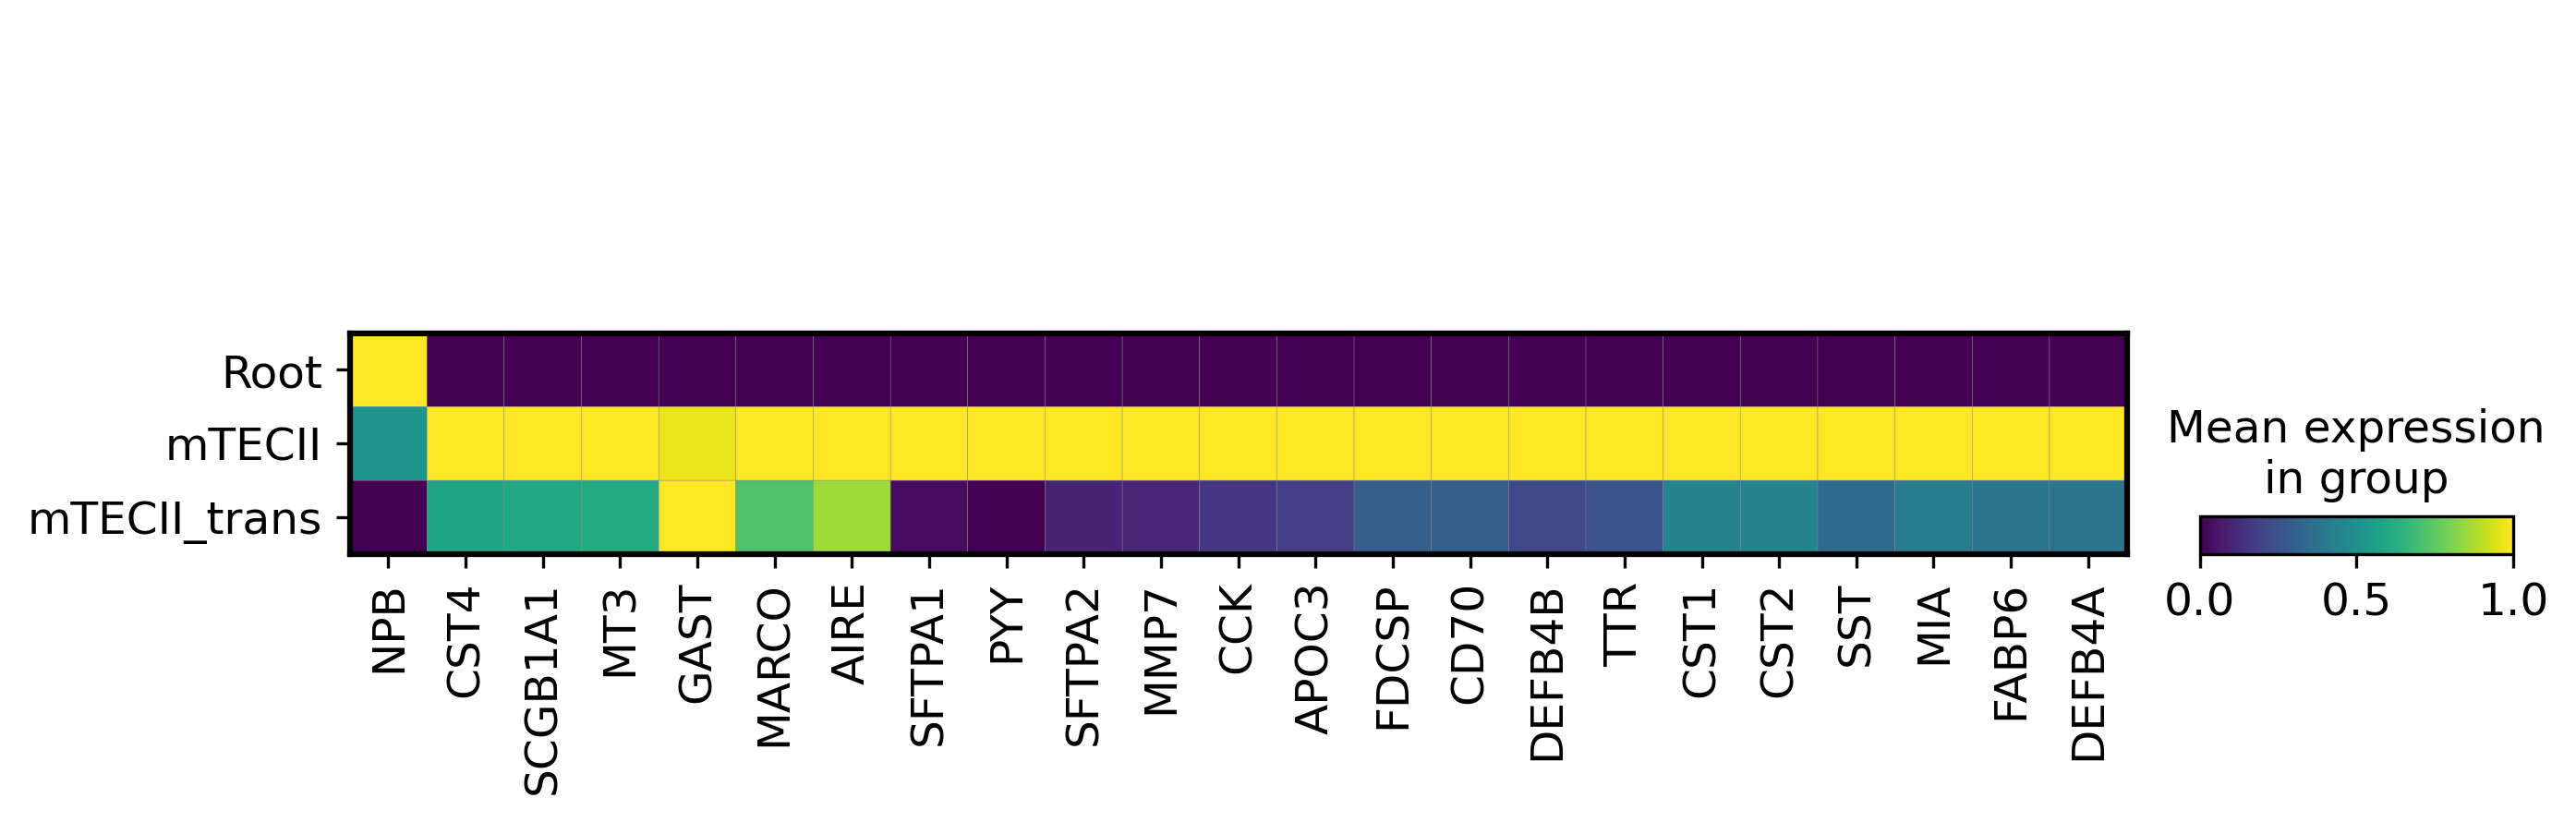

In [232]:
# cluster cytokies by expression profiles across bins
from sklearn.preprocessing import scale
from scipy.cluster.hierarchy import linkage, dendrogram
genes = marker_dict_1['mTECII'] 
cells = ['Root', 'mTECII', 'mTECII_trans']
groupby = 'milestones'
## For correct plotting of the images
import matplotlib
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')


# Subset dataframe, calculate mean expression and standardize
adata_selected = adata[:, adata.var_names.isin(genes)]
adata_selected = adata_selected[adata_selected.obs[groupby].isin(cells),:]

mean_expression_df = pd.DataFrame(adata_selected.X.toarray(), 
                                  columns=adata_selected.var_names, 
                                  index=adata_selected.obs_names).groupby(adata_selected.obs[groupby]).mean()
mean_expression_std = pd.DataFrame(scale(mean_expression_df, axis=0),
                                   index=mean_expression_df.index,
                                   columns=mean_expression_df.columns)

# Create dendrogram
transposed_df = mean_expression_std.transpose()
Z = linkage(transposed_df, method='ward')
dn = dendrogram(Z, orientation='top', labels=transposed_df.index, leaf_font_size=5,p=10,color_threshold=2)

# Set plotting preferences
plt.grid(False)
plt.rcParams['figure.facecolor'] = 'white'
for spine in plt.gca().spines.values(): spine.set_visible(False)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=False)

# Get and print gene order
gene_order = [transposed_df.index[i] for i in dn['leaves']]
print(gene_order)

# Save the dendrogram figure as a PDF
plt.savefig('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/figures/dendrogram_mTECII.pdf')

plt.show()

# Create matrix plot using scanpy
# sc.pl.matrixplot(adata_tec_paed_med,var_names=gene_order,groupby=groupby,cmap='viridis',standard_scale='var',dendrogram=False)

fig = sc.pl.matrixplot(adata_selected,var_names=gene_order,groupby=groupby,cmap='viridis',standard_scale='var',dendrogram=False,save='matrixplot_mTECII.pdf')
# plt.savefig('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/figures/matrixplot_mTECIII.pdf')



{'B-memory': 3, 'DC1': 1, 'Macrophage-APOC2': 1, 'TEC-myo': 18, 'T_CD8αα(II)': 1, 'T_NK': 2, 'T_Treg_recirc': 4, 'aDC3': 2, 'mTECII': 27, 'mTECIII': 79, 'pDC': 2}
140


Text(0.5, 0, 'space_map_cma')

Text(0, 0.5, 'space_map_hc')

(0.75, 0.55)

(0.0, 250.0)

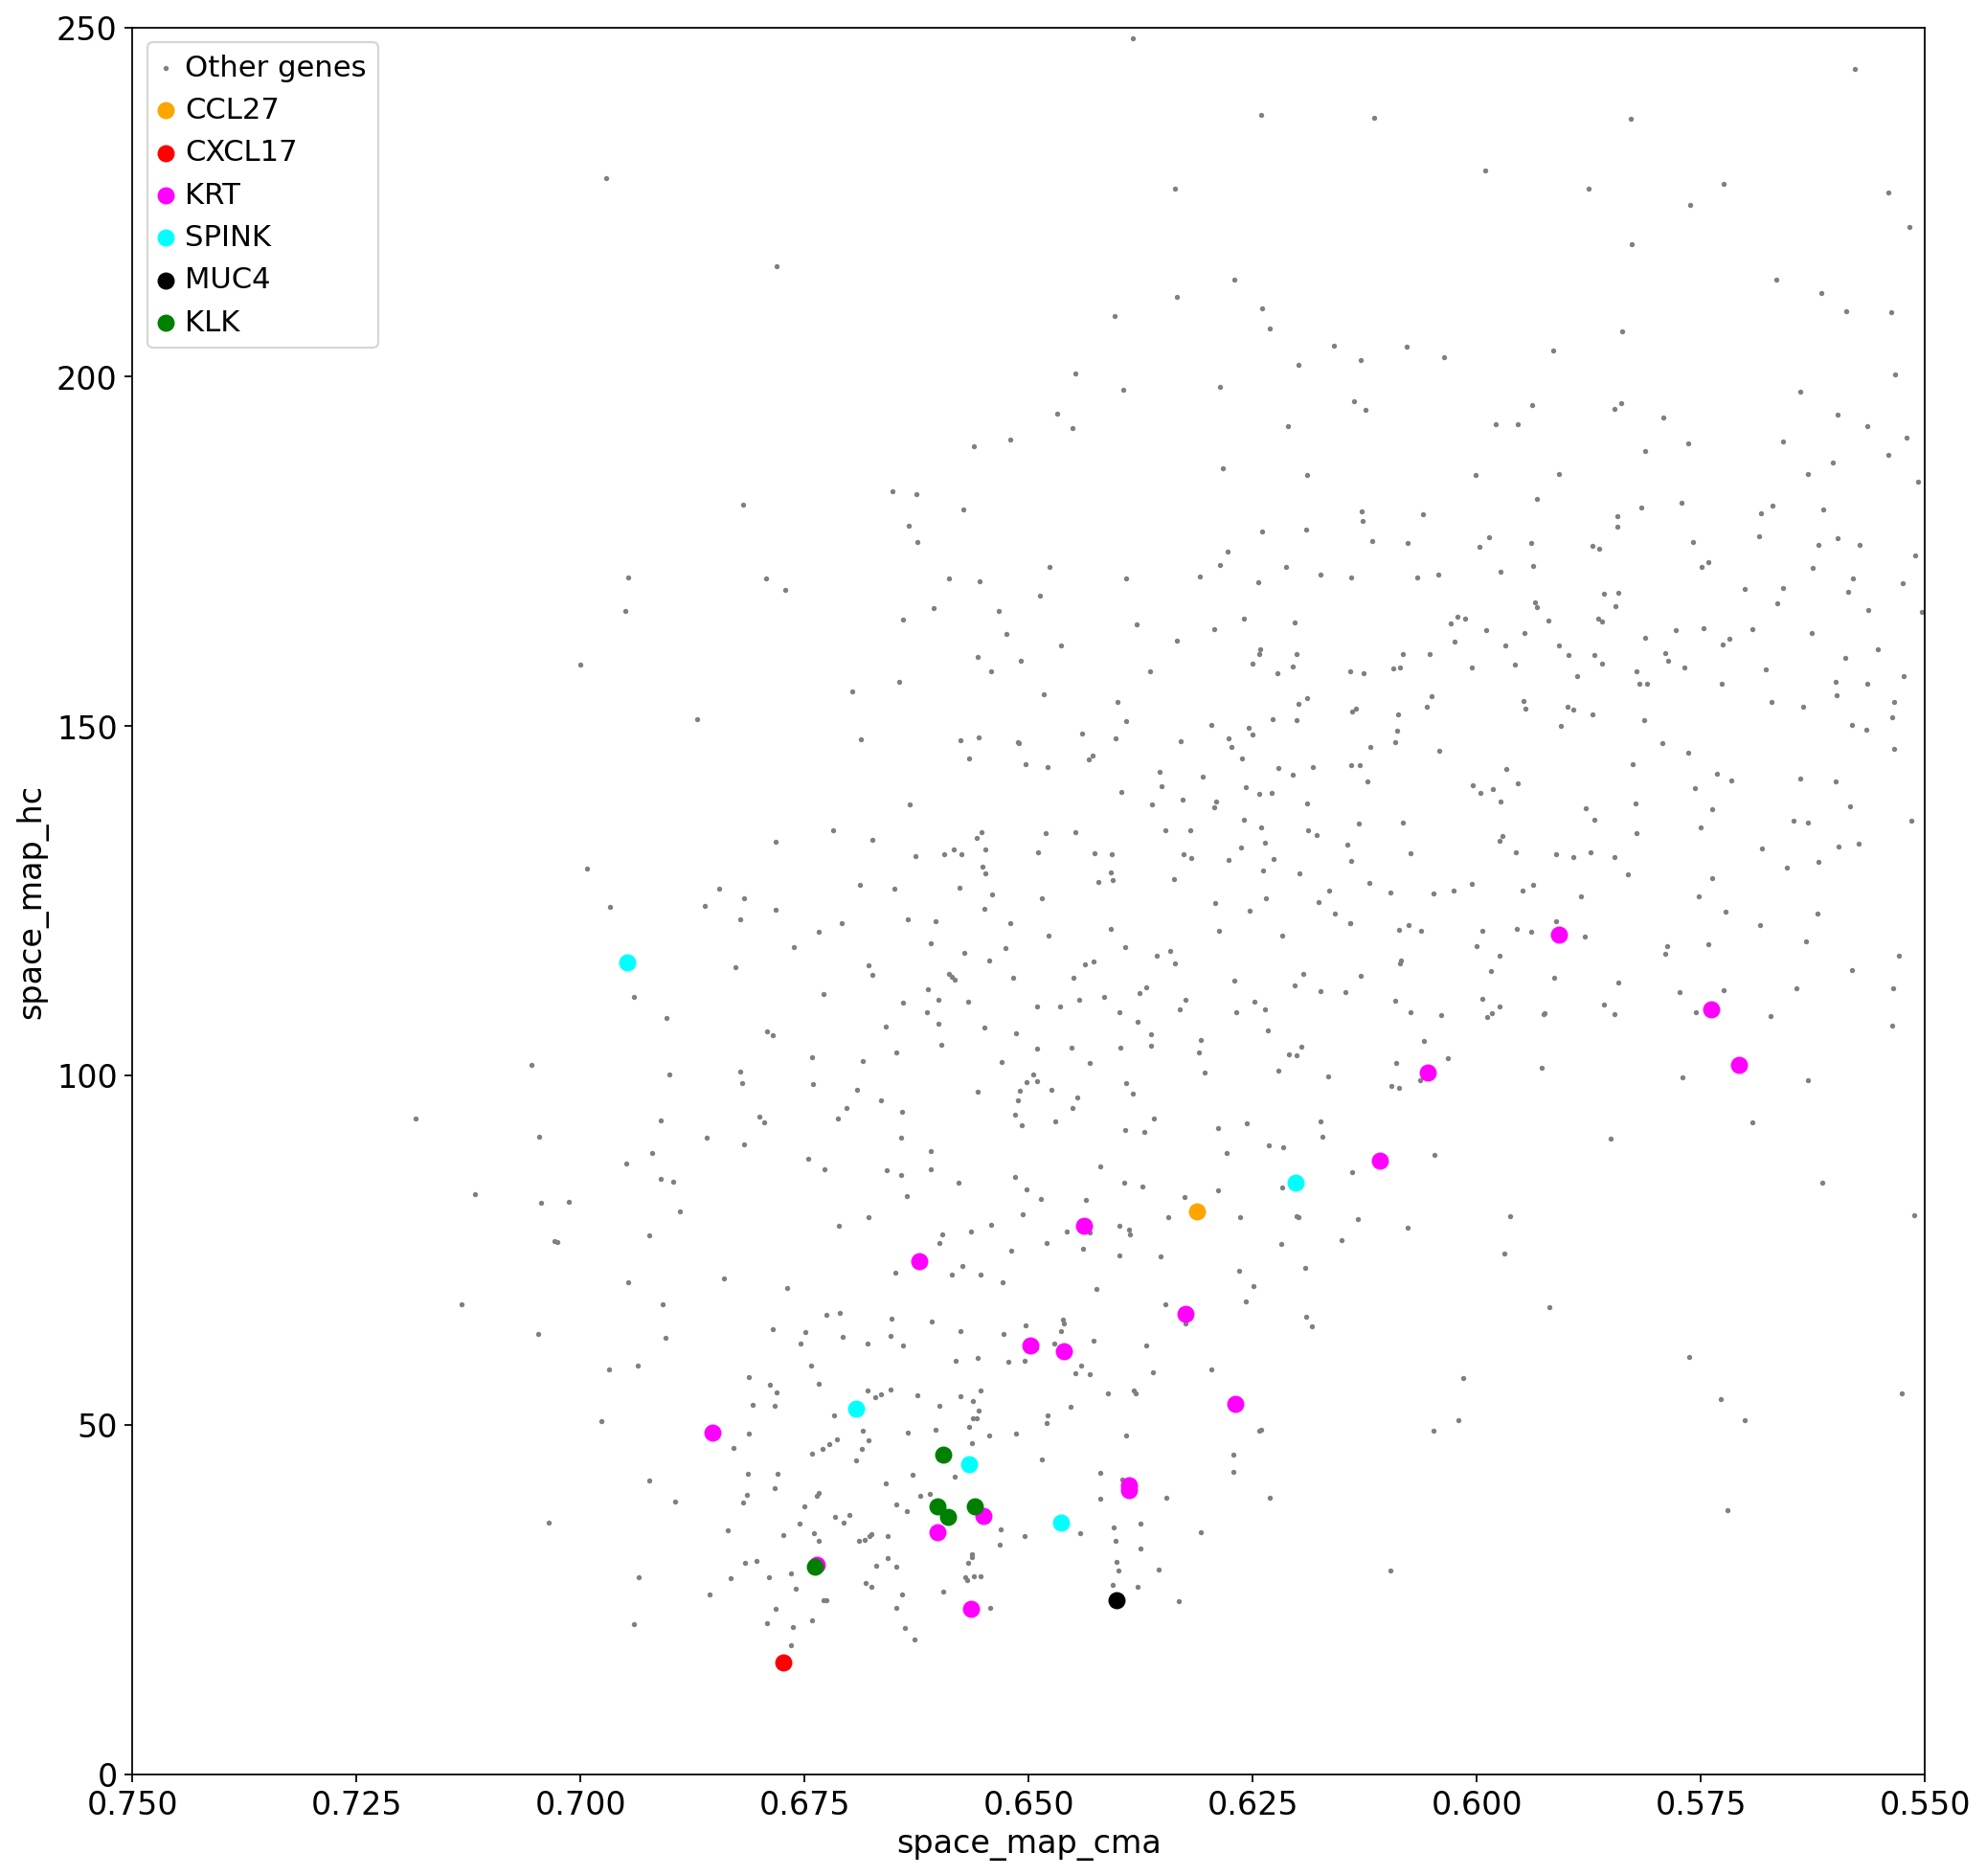

In [216]:
import matplotlib.pyplot as plt
sc.set_figure_params(figsize=[15,15],fontsize=15)
cmap = plt.get_cmap('tab20')
cell_spots = {}
for key in marker_dict_1.keys():
    df[key+'_unique'] = df.index.isin(marker_dict_1[key])

lengths = {key: len(value) for key, value in marker_dict_1.items()}
print(lengths)
total_sum = sum(lengths.values())
print(total_sum)
flattened_values = [item for sublist in marker_dict_1.values() for item in sublist]
# flattened_values
df_sg = df[df.index.isin(flattened_values)]
plt.scatter(df['space_map_cma'], df['space_map_hc'], c='gray', label='Other genes', s=2)

colors = sns.color_palette('tab10', 20)


# Define strings to search for and corresponding colors
search_strings = ['CCL27', 'CXCL17', 'KRT', 'SPINK','MUC4', 'KLK']
colors = ['orange', 'red','magenta', 'cyan','black','green','blue','brown']

# Define strings to search for and corresponding colors
# search_strings = ['KRT','IVL']
# colors = ['green','magenta']
def annotate_matching_positions(df,search_string, color,anno=True):
    matching_positions = np.where(df.index.str.contains(search_string))[0]
    df_tmp = df.iloc[matching_positions, :]
    plt.scatter(df_tmp['space_map_cma'], df_tmp['space_map_hc'], c=color, label=search_string, s=50)
    for i in matching_positions:
        if anno:
            plt.annotate(df.index[i], (df['space_map_cma'][i], df['space_map_hc'][i]), fontname='Arial', fontsize=15, color=color)
# Use a loop to match partial strings, plot scatter points, and add annotations
for search_string, color in zip(search_strings, colors):
    annotate_matching_positions(df,search_string, color,anno=False)

        
plt.grid(False)

# add axis labels
plt.xlabel('space_map_cma')
plt.ylabel('space_map_hc')

plt.legend()
plt.gca().invert_xaxis()

# Set axis limits
plt.xlim(0.75, 0.55) # Since you're inverting the x-axis, the limits are given in reverse order
plt.ylim(0, 250)

plt.savefig('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/figures/HC_CMA_association_selected_genes_broad.pdf')
plt.show()


{'B-memory': 3, 'DC1': 1, 'Macrophage-APOC2': 1, 'TEC-myo': 18, 'T_CD8αα(II)': 1, 'T_NK': 2, 'T_Treg_recirc': 4, 'aDC3': 2, 'mTECII': 27, 'mTECIII': 79, 'pDC': 2}
140


Text(0.5, 0, 'space_map_cma')

Text(0, 0.5, 'space_map_hc')

(0.75, 0.55)

(0.0, 250.0)

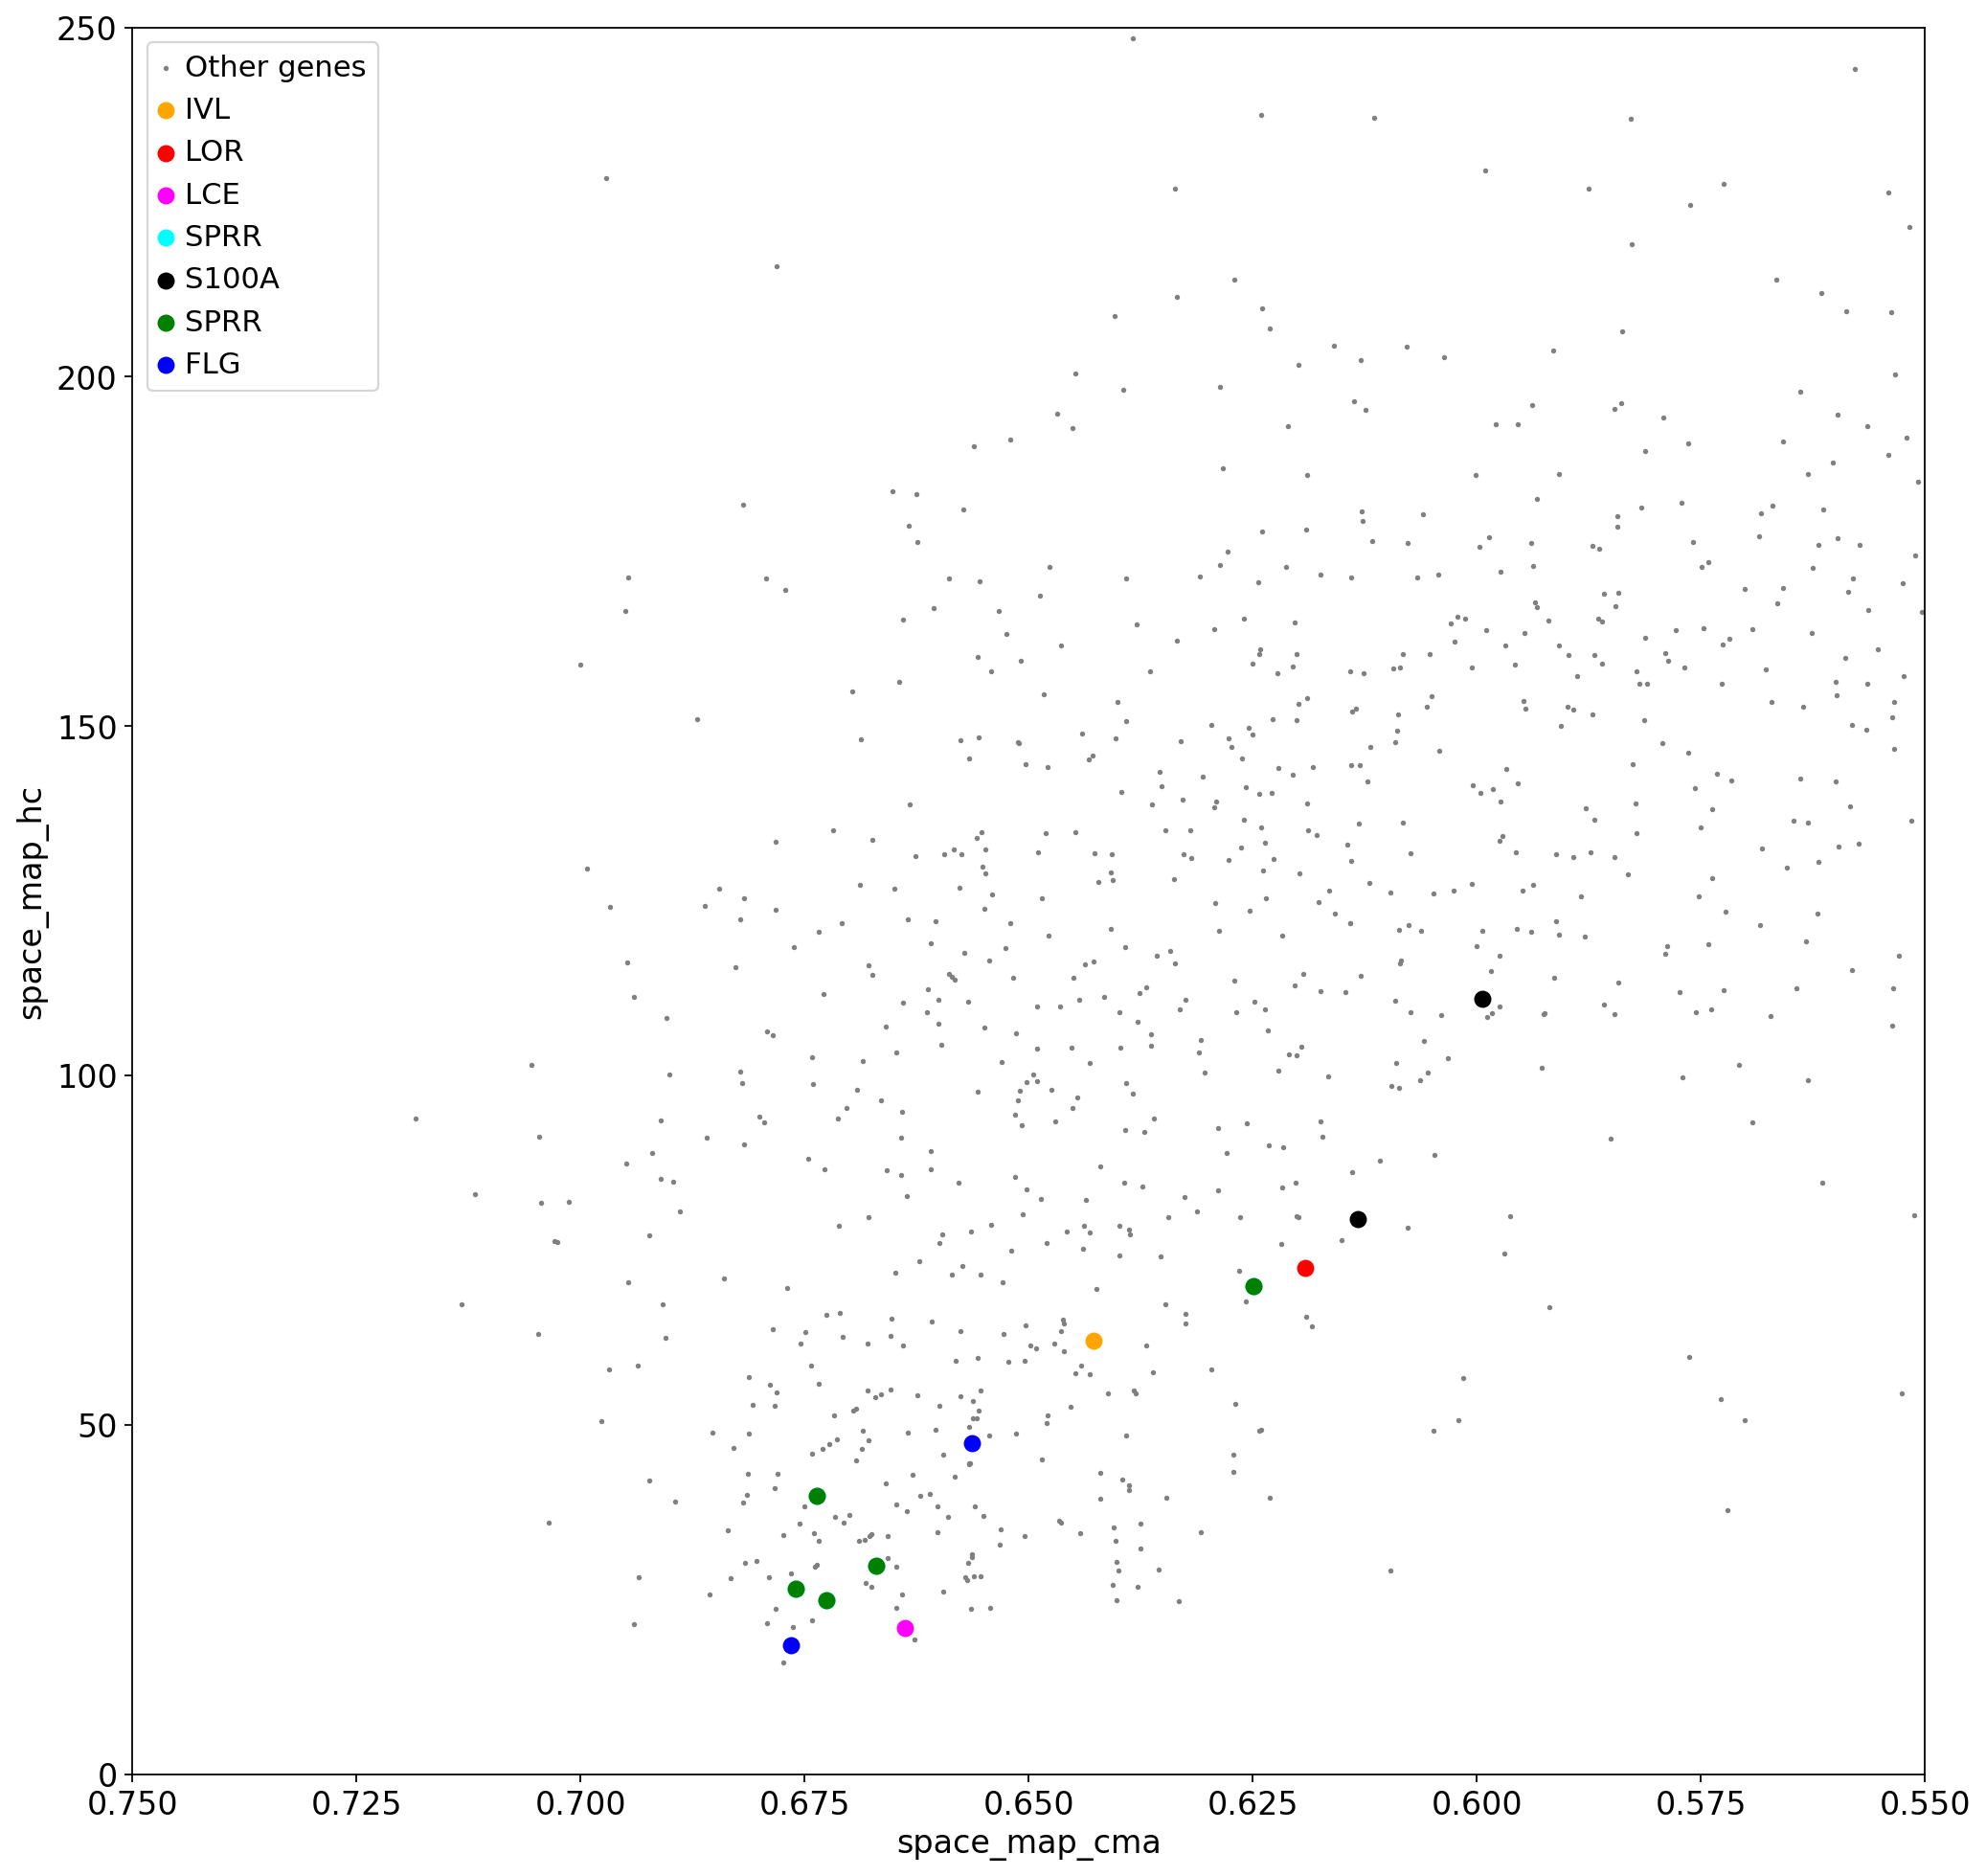

In [217]:
import matplotlib.pyplot as plt
sc.set_figure_params(figsize=[15,15],fontsize=15)
cmap = plt.get_cmap('tab20')
cell_spots = {}
for key in marker_dict_1.keys():
    df[key+'_unique'] = df.index.isin(marker_dict_1[key])

lengths = {key: len(value) for key, value in marker_dict_1.items()}
print(lengths)
total_sum = sum(lengths.values())
print(total_sum)
flattened_values = [item for sublist in marker_dict_1.values() for item in sublist]
# flattened_values
df_sg = df[df.index.isin(flattened_values)]
plt.scatter(df['space_map_cma'], df['space_map_hc'], c='gray', label='Other genes', s=2)

colors = sns.color_palette('tab10', 20)


# Define strings to search for and corresponding colors
search_strings = ['IVL', 'LOR', 'LCE', 'SPRR', 'S100A','SPRR','FLG']
colors = ['orange', 'red','magenta', 'cyan','black','green','blue']

# Define strings to search for and corresponding colors
# search_strings = ['KRT','IVL']
# colors = ['green','magenta']
def annotate_matching_positions(df,search_string, color,anno=True):
    matching_positions = np.where(df.index.str.contains(search_string))[0]
    df_tmp = df.iloc[matching_positions, :]
    plt.scatter(df_tmp['space_map_cma'], df_tmp['space_map_hc'], c=color, label=search_string, s=50)
    for i in matching_positions:
        if anno:
            plt.annotate(df.index[i], (df['space_map_cma'][i], df['space_map_hc'][i]), fontname='Arial', fontsize=15, color=color)
# Use a loop to match partial strings, plot scatter points, and add annotations
for search_string, color in zip(search_strings, colors):
    annotate_matching_positions(df,search_string, color,anno=False)

        
plt.grid(False)

# add axis labels
plt.xlabel('space_map_cma')
plt.ylabel('space_map_hc')

plt.legend()
plt.gca().invert_xaxis()

# Set axis limits
plt.xlim(0.75, 0.55) # Since you're inverting the x-axis, the limits are given in reverse order
plt.ylim(0, 250)

plt.savefig('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/figures/HC_CMA_association_selected_genes_EDC.pdf')
plt.show()


space_map_cma  space_map_hc  B-memory_unique  DC1_unique  \
AGRN             0.637796    107.629249            False       False   
AL390719.2       0.619878     79.755674            False       False   
TNFRSF18         0.642635    131.810371            False       False   
TNFRSF4          0.572574    161.734681            False       False   
TP73             0.640571    127.909767            False       False   
...                   ...           ...              ...         ...   
SLITRK2          0.650449     34.025981            False       False   
GABRE            0.622722    130.940622            False       False   
PNMA3            0.625008    158.945739            False       False   
CLIC2            0.600574    158.352162            False       False   
AC145212.1       0.551247     79.979523            False       False   

            Macrophage-APOC2_unique  TEC-myo_unique  T_CD8αα(II)_unique  \
AGRN                          False           False               False   
AL390719.2                    False           False               False   
TNFRSF18                      False           False               False   
TNFRSF4                       False           False               False   
TP73                          False           False               False   
...                             ...             ...                 ...   
SLITRK2                       False           False               False   
GABRE                         False           False               False   
PNMA3                         False           False               False   
CLIC2                         False           False               False   
AC145212.1                    False           False               False   

            T_NK_unique  T_Treg_recirc_unique  aDC3_unique  mTECII_unique  \
AGRN              False                 False        False          False   
AL390719.2        False                 False        False          False   
TNFRSF18          False                  True        False          False   
TNFRSF4           False                 False        False          False   
TP73              False                 False        False          False   
...                 ...                   ...          ...            ...   
SLITRK2           False                 False        False          False   
GABRE             False                 False        False          False   
PNMA3             False                 False        False          False   
CLIC2             False                 False        False          False   
AC145212.1        False                 False        False          False   

            mTECIII_unique  pDC_unique  
AGRN                 False       False  
AL390719.2           False       False  
TNFRSF18             False       False  
TNFRSF4              False       False  
TP73                 False       False  
...                    ...         ...  
SLITRK2              False       False  
GABRE                False       False  
PNMA3                False       False  
CLIC2                False       False  
AC145212.1           False       False  

[848 rows x 13 columns]

Text(0.5741813881331658, 173.47771145629076, 'B-memory')

Text(0.5860732624364002, 158.91627052302186, 'B-memory')

Text(0.6050570616730506, 154.2750519493682, 'B-memory')

Text(0.6129030936383744, 202.43247977984313, 'DC1')

Text(0.6130358243600741, 144.3633095937499, 'Macrophage-APOC2')

Text(0.6817775522411504, 90.07065893838092, 'TEC-myo')

Text(0.6859524972275348, 91.01892759855409, 'TEC-myo')

Text(0.7184081172053411, 93.81774457747046, 'TEC-myo')

Text(0.7012512525468032, 81.94460176684274, 'TEC-myo')

Text(0.6642432713410047, 91.08715746736698, 'TEC-myo')

Text(0.7044007662854525, 81.72516123968316, 'TEC-myo')

Text(0.6903650623297757, 108.16703345610843, 'TEC-myo')

Text(0.7132177055306556, 67.29122107315837, 'TEC-myo')

Text(0.5911038617445302, 122.07758039254695, 'TEC-myo')

Text(0.6626649108753487, 131.43182548291975, 'TEC-myo')

Text(0.679192165930096, 106.30693207036319, 'TEC-myo')

Text(0.6276688003886872, 130.8322678328054, 'TEC-myo')

Text(0.6427149377035661, 116.25784636175295, 'TEC-myo')

Text(0.6829536372835423, 46.67149434699925, 'TEC-myo')

Text(0.7118043803847911, 83.03347123579782, 'TEC-myo')

Text(0.6608928467459038, 86.50824675551412, 'TEC-myo')

Text(0.692018924850263, 88.8896784300256, 'TEC-myo')

Text(0.7025984404210903, 76.10590838660899, 'TEC-myo')

Text(0.6159768147922033, 204.3891941096224, 'T_CD8αα(II)')

Text(0.6525273665344419, 163.19155917335965, 'T_NK')

Text(0.6557187270711923, 159.91038707022798, 'T_NK')

Text(0.6426345463502141, 131.81037102194225, 'T_Treg_recirc')

Text(0.5957054374171656, 158.7676066074907, 'T_Treg_recirc')

Text(0.6508800150560003, 159.35563327270918, 'T_Treg_recirc')

Text(0.6391336946482127, 171.0868897355508, 'T_Treg_recirc')

Text(0.6210506862856383, 192.92548731335228, 'aDC3')

Text(0.5821905376551568, 134.67571595792216, 'aDC3')

Text(0.6638293018081112, 20.920533387089534, 'mTECII')

Text(0.6736445883229866, 39.76667696983281, 'mTECII')

Text(0.6710904354103664, 65.94109571258556, 'mTECII')

Text(0.6629979334468769, 42.84611239425876, 'mTECII')

Text(0.6935236132693081, 28.131593143304585, 'mTECII')

Text(0.6189897947014951, 65.51774357149709, 'mTECII')

Text(0.6359867264760152, 93.81222415947661, 'mTECII')

Text(0.6324532542841171, 64.42986672054282, 'mTECII')

Text(0.6585523645103971, 71.49735598179905, 'mTECII')

Text(0.674544749335663, 88.13375223783775, 'mTECII')

Text(0.7047668451218749, 62.96436954599161, 'mTECII')

Text(0.6485422648206471, 45.02659881964357, 'mTECII')

Text(0.668334883597085, 33.580863960181205, 'mTECII')

Text(0.6648861447796361, 71.81131690526806, 'mTECII')

Text(0.6762571453897929, 20.982191518912604, 'mTECII')

Text(0.6375020550389938, 32.28258285790517, 'mTECII')

Text(0.6908385577098638, 67.20753156867588, 'mTECII')

Text(0.6479610768280339, 76.06795353424987, 'mTECII')

Text(0.6565304225146065, 44.54978467346742, 'mTECII')

Text(0.6431614491516516, 101.76098678411758, 'mTECII')

Text(0.6726024380820547, 65.69223193537785, 'mTECII')

Text(0.6840392290417302, 70.96371516378855, 'mTECII')

Text(0.6574039358650744, 72.78416454340773, 'mTECII')

Text(0.638669709065759, 77.1841502218046, 'mTECII')

Text(0.6608099559008642, 64.70225914519223, 'mTECII')

Text(0.6569050289756051, 27.705534845289055, 'mTECII')

Text(0.6086220689619088, 120.88234844941245, 'mTECII')

Text(0.6464350805493516, 63.37454082423691, 'mTECIII')

Text(0.6640602917913592, 61.38228177622945, 'mTECIII')

Text(0.6716818295570157, 51.337771229008204, 'mTECIII')

Text(0.6230821713939693, 39.56990002973886, 'mTECIII')

Text(0.6562916883111064, 47.29805075177792, 'mTECIII')

Text(0.6764816306830573, 18.431105855266374, 'mTECIII')

Text(0.6427465697870929, 62.00098006217565, 'mTECIII')

Text(0.6725150509227428, 24.820133127970177, 'mTECIII')

Text(0.6249133253108724, 69.86918751516386, 'mTECIII')

Text(0.6760137598533343, 26.57864785572218, 'mTECIII')

Text(0.6669563367165356, 29.806642885666864, 'mTECIII')

Text(0.6191976939574603, 72.43889069183713, 'mTECIII')

Text(0.6132380261442054, 79.40467854156802, 'mTECIII')

Text(0.6465659043956272, 36.25940617203859, 'mTECIII')

Text(0.6686426018723327, 46.54006187282647, 'mTECIII')

Text(0.6512210629052269, 96.38919438814695, 'mTECIII')

Text(0.6695360445917975, 51.95493775491459, 'mTECIII')

Text(0.6567006297514268, 30.259092883315915, 'mTECIII')

Text(0.6832673895087941, 28.08083208916675, 'mTECIII')

Text(0.6401995035340172, 24.944287534873872, 'mTECIII')

Text(0.6432187077565887, 57.18665219449494, 'mTECIII')

Text(0.6734619867823464, 33.375029282140304, 'mTECIII')

Text(0.6202550882530141, 84.67714000220924, 'mTECIII')

Text(0.6566837613170367, 44.35828516538401, 'mTECIII')

Text(0.6464304558600695, 35.941071906574415, 'mTECIII')

Text(0.6558430811605913, 50.96261603303554, 'mTECIII')

Text(0.6271694018534708, 45.69791051546259, 'mTECIII')

Text(0.6739278120104731, 34.44045903582425, 'mTECIII')

Text(0.6599469669067477, 52.767658410843666, 'mTECIII')

Text(0.6734410817960517, 40.20492905177443, 'mTECIII')

Text(0.668980262918029, 33.31379093217532, 'mTECIII')

Text(0.6715600457002993, 36.78484969705207, 'mTECIII')

Text(0.665759368361999, 30.963339476803544, 'mTECIII')

Text(0.6232506507264856, 89.96136042218335, 'mTECIII')

Text(0.6544433559241174, 48.41547742191334, 'mTECIII')

Text(0.6263617044788754, 79.76047042175469, 'mTECIII')

Text(0.6405657282700439, 27.10184985123637, 'mTECIII')

Text(0.6076882506904688, 78.13775939863586, 'mTECIII')

Text(0.5982707455830902, 108.94261074170558, 'mTECIII')

Text(0.681349436294698, 42.9876069574286, 'mTECIII')

Text(0.6400144933952132, 29.117865898134323, 'mTECIII')

Text(0.6554064748339363, 71.42449427290778, 'mTECIII')

Text(0.6553643562187937, 54.8784628563265, 'mTECIII')

Text(0.689405700150085, 39.06718278235209, 'mTECIII')

Text(0.6344453492651169, 79.69973801857346, 'mTECIII')

Text(0.6736414595850967, 29.914071485181683, 'mTECIII')

Text(0.6388466442069203, 40.610383861435025, 'mTECIII')

Text(0.6460769663519842, 60.56575134745627, 'mTECIII')

Text(0.6852882911331546, 48.89702915827143, 'mTECIII')

Text(0.6388226089883169, 41.33189763458591, 'mTECIII')

Text(0.6497670191850142, 61.392813147266025, 'mTECIII')

Text(0.6564476047217557, 23.60849349629623, 'mTECIII')

Text(0.6789532468171516, 28.180015076350443, 'mTECIII')

Text(0.6700086235861358, 37.11009883041309, 'mTECIII')

Text(0.6742092992010493, 45.825648324256285, 'mTECIII')

Text(0.6269649614681935, 52.94065973709035, 'mTECIII')

Text(0.6405134591585663, 35.266347226587335, 'mTECIII')

Text(0.6561686668665642, 50.87624756993556, 'mTECIII')

Text(0.65563988699052, 59.49713229019905, 'mTECIII')

Text(0.6528044268783134, 62.962920675109466, 'mTECIII')

Text(0.6479855401037542, 50.26991151652105, 'mTECIII')

Text(0.6657731794873365, 34.08354232128487, 'mTECIII')

Text(0.6816392553174344, 30.18321040072383, 'mTECIII')

Text(0.6054443141672626, 100.42227129022278, 'mTECIII')

Text(0.5975034994483923, 109.87797265745218, 'mTECIII')

Text(0.6332128389393482, 24.744352849119284, 'mTECIII')

Text(0.6774035642339545, 16.02828868160084, 'mTECIII')

Text(0.6627203459603626, 19.24123695769594, 'mTECIII')

Text(0.659003760518755, 36.77478066962509, 'mTECIII')

Text(0.6559996209079055, 38.30217292647183, 'mTECIII')

Text(0.673856473375594, 29.61860723434776, 'mTECIII')

Text(0.6595330734328658, 45.72697543877867, 'mTECIII')

Text(0.6378385078269194, 26.775145918700133, 'mTECIII')

Text(0.5724645208241392, 112.1746274104614, 'mTECIII')

Text(0.5742148989512359, 118.80106952011566, 'mTECIII')

Text(0.6664994140109628, 54.30351821792431, 'mTECIII')

Text(0.6326892708526635, 131.68728358044783, 'pDC')

Text(0.6407197691605212, 131.6444089997222, 'pDC')

Text(0.5, 0, 'space_map_cma')

Text(0, 0.5, 'space_map_hc')

(0.75, 0.55)

(0.0, 250.0)

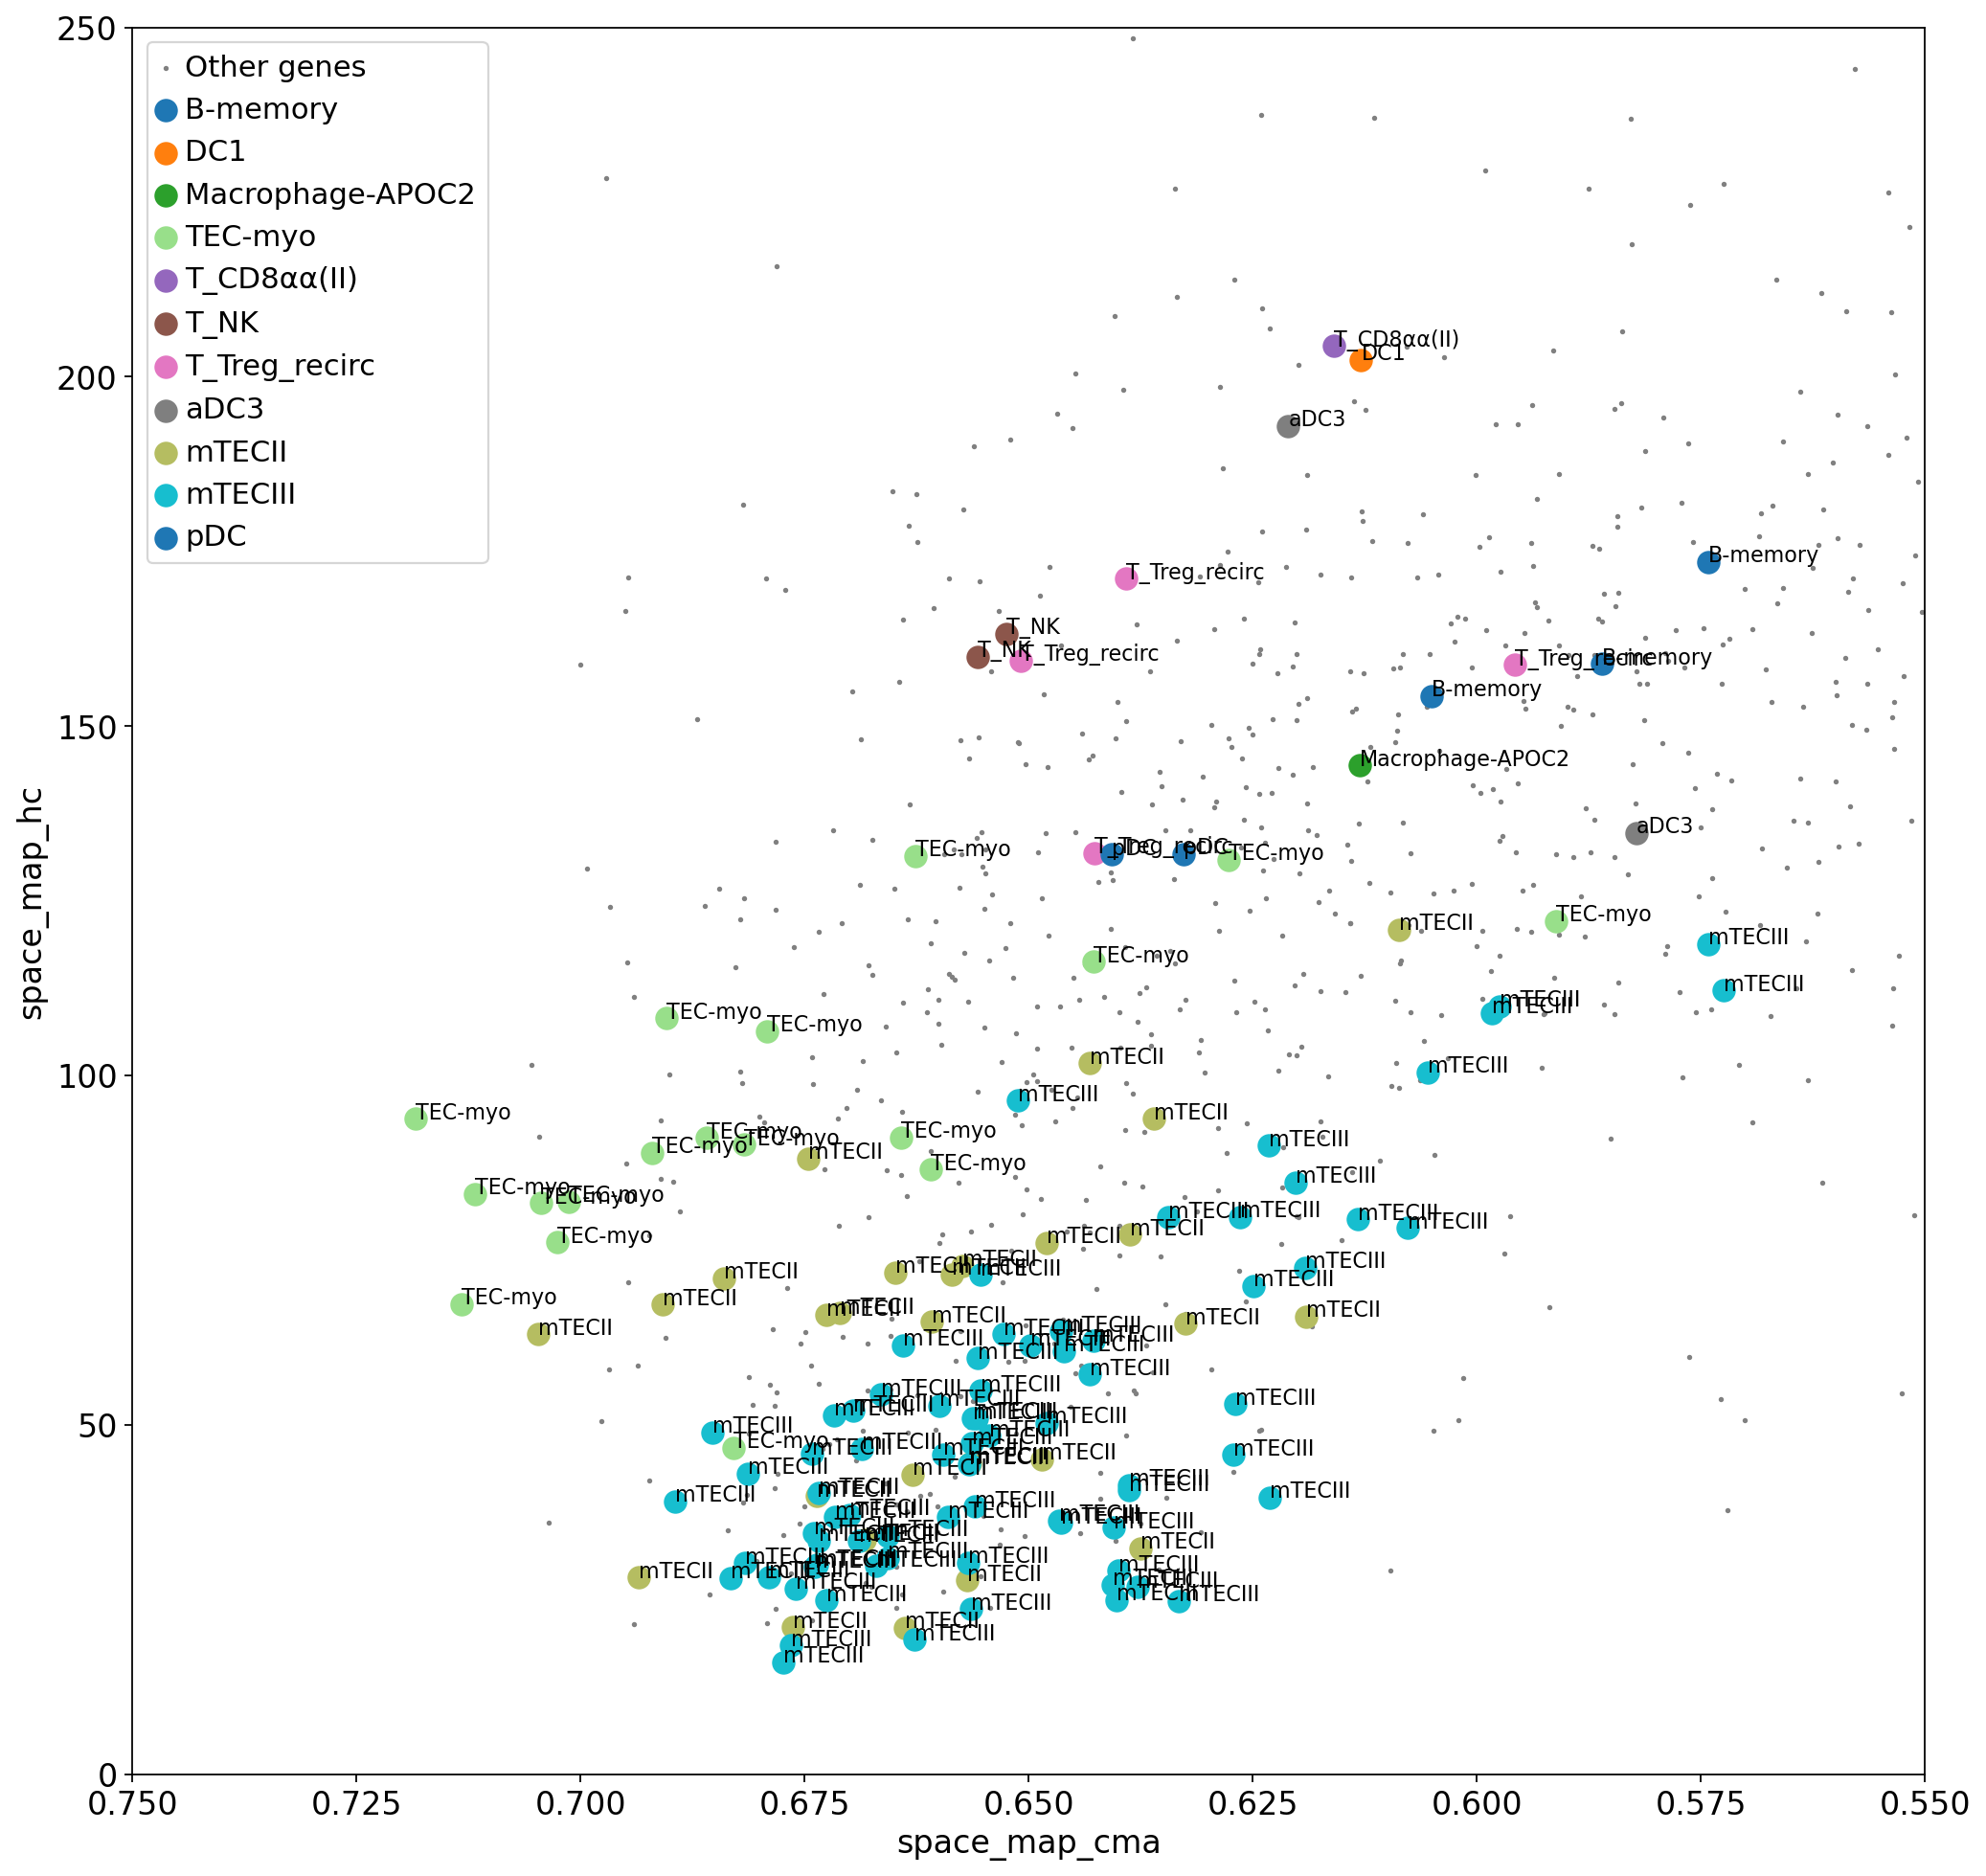

In [38]:
import matplotlib.pyplot as plt
sc.set_figure_params(figsize=[15,15],fontsize=15)
cmap = plt.get_cmap('tab20')
cell_spots = {}
for key in marker_dict_1.keys():
    df[key+'_unique'] = df.index.isin(marker_dict_1[key])
df

colors = sns.color_palette('tab10', 20)
# cmap = ListedColormap(colors)

plt.scatter(df['space_map_cma'], df['space_map_hc'], c='gray', label='Other genes', s=2)
for idx, key in enumerate(marker_dict_1.keys()):
    if 'TEC' in key:
        plt.scatter(df[df[key + '_unique']]['space_map_cma'], df[df[key + '_unique']]['space_map_hc'], c=color_dict[key], label=key, s=100)
        filtered_df = df[df[key + '_unique']]
        for _, row in filtered_df.iterrows():
            plt.annotate(
                key, 
                (row['space_map_cma'], row['space_map_hc']), 
                fontname='Arial', 
                fontsize=10, 
                color='black'
            )
    if 'TEC' not in key:
        plt.scatter(df[df[key + '_unique']]['space_map_cma'], df[df[key + '_unique']]['space_map_hc'],  c=[colors[idx]], label=key, s=100)
        filtered_df = df[df[key + '_unique']]
        for _, row in filtered_df.iterrows():
            plt.annotate(
                key, 
                (row['space_map_cma'], row['space_map_hc']), 
                fontname='Arial', 
                fontsize=10, 
                color='black'
            )


        
plt.grid(False)

# add axis labels
plt.xlabel('space_map_cma')
plt.ylabel('space_map_hc')

plt.legend()
plt.gca().invert_xaxis()

# Set axis limits
plt.xlim(0.75, 0.55) # Since you're inverting the x-axis, the limits are given in reverse order
plt.ylim(0, 250)

plt.savefig('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/figures/HC_CMA_association_genes_all.pdf')
plt.show()


## 